<a href="https://colab.research.google.com/github/Syed-Al-Khwarizmi/time-series-practices/blob/master/KSE100_using_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cp "gdrive/My Drive/Data Science Dataset.zip" "Data Science Dataset.zip"

In [0]:
!unzip "Data Science Dataset.zip"

Archive:  Data Science Dataset.zip
  inflating: sample_solution.csv     
   creating: __MACOSX/
  inflating: __MACOSX/._sample_solution.csv  
  inflating: Stock_Data_06-11.csv    
  inflating: __MACOSX/._Stock_Data_06-11.csv  
  inflating: Market_Data_06-11.csv   
  inflating: __MACOSX/._Market_Data_06-11.csv  


In [0]:
ls

'Data Science Dataset.zip'   Market_Data_06-11.csv   Stock_Data_06-11.csv
 gdrive/                     sample_data/
 __MACOSX/                   sample_solution.csv


In [0]:
# !pip list

In [0]:
# !pip install pandas==0.23.4

In [0]:
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt
from keras.callbacks import ModelCheckpoint
from fbprophet import Prophet
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import ipywidgets as widgets
from ipywidgets import interact
%matplotlib inline

In [0]:
# convert series to supervised learning
def series_to_supervised(data, column_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{}(t-{})'.format(j, i)) for j in column_names]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
#         print("This should not be happening")
        cols.append(df.shift(-i))
#         print(cols)
        if i == 0:
            names += [('{}(t)'.format(j)) for j in column_names]
        else:
            names += [('{}(t+{})'.format(j, i)) for j in column_names]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [0]:
def gen_next_data(inp, model, scaler, n_freq, l):
  past = list(inp)
  outs = []
#   inp = np.array([[past]])
#   out = model.predict(inp)
#   templol = [0]*54261
#   templol.append(o)
#   templol = np.array(templol).reshape(-1, 1)
#   # print(templol)
#   inverted_val = scaler_target.inverse_transform(templol)[-1][0]
#   outs.append(inverted_val)
  for i in range(n_freq):
    print(i)
#     print("Past array: {}".format(past))
#     print("Value popped: {}".format(past.pop(0)))
#     print("Value appended: {}".format(inverted_val))
    inp = np.array([[past]])
    out = model.predict(inp)[0][0]
    past.pop(0)
    past.append(out)
#     print("Out: {}".format(out))
    templol = [0]*int(l-1)
    templol.append(out)
    templol = np.array(templol).reshape(-1, 1)
    # print(templol)
    inverted_val = scaler_target.inverse_transform(templol)[-1][0]
    outs.append(inverted_val)
  return outs

In [0]:
# test_X[1][0]
outs = gen_next_data(test_X[-1][0], model, scaler_target, 50)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
future_X = []
next_row = test_X[-100][0]
for i in range(200):
  print(i)
  next_row = gen_next_data(next_row, model, scaler_target)
  future_X.append(next_row)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [0]:
trg = test_X[0][0]
print(trg)
sampinp = np.array([[trg]])
# print(sampinp)
# print(sampinp.shape)
o = model.predict(sampinp)
# print(o)
templol = [0]*54261
templol.append(o)
templol = np.array(templol).reshape(-1, 1)
# print(templol)
inverted_val = scaler_target.inverse_transform(templol)[-1][0]
print(inverted_val)

[0.25208681 0.25208681 0.25208681 0.25208681 0.25208681 0.25208681
 0.25208681 0.25208681 0.25208681 0.25208681 0.25208681 0.25208681
 0.25208681 0.25208681 0.25208681 0.25208681 0.25208681 0.25208681
 0.25208681 0.25208681]
24.24332004442811


In [0]:
future_X = np.array(future_X)
future_X2 = np.expand_dims(future_X, 1)
future_X2.shape

NameError: ignored

In [0]:
future_X2

array([[[147.43831034, 147.51241068, 147.55163975, ..., 147.93232077,
         147.95110955, 147.97572864]],

       [[182.57291162, 182.57291162, 182.57291162, ..., 175.00259024,
         183.30968704, 164.78012322]],

       [[182.57291162, 182.57291162, 182.57291162, ..., 175.00259024,
         173.76239201, 164.7804422 ]],

       ...,

       [[182.57291162, 182.57291162, 182.57291162, ..., 175.00259024,
         174.46930335, 164.78043913]],

       [[182.57291162, 182.57291162, 182.57291162, ..., 175.00259024,
         174.46930335, 164.78043913]],

       [[182.57291162, 182.57291162, 182.57291162, ..., 175.00259024,
         174.46930335, 164.78043913]]])

In [0]:
len(offset_list+list(test_y)), len(offset_list)

(54257, 40692)

In [0]:
test_X.shape

(13565, 1, 20)

fpreds [[0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7817256]
 [0.7

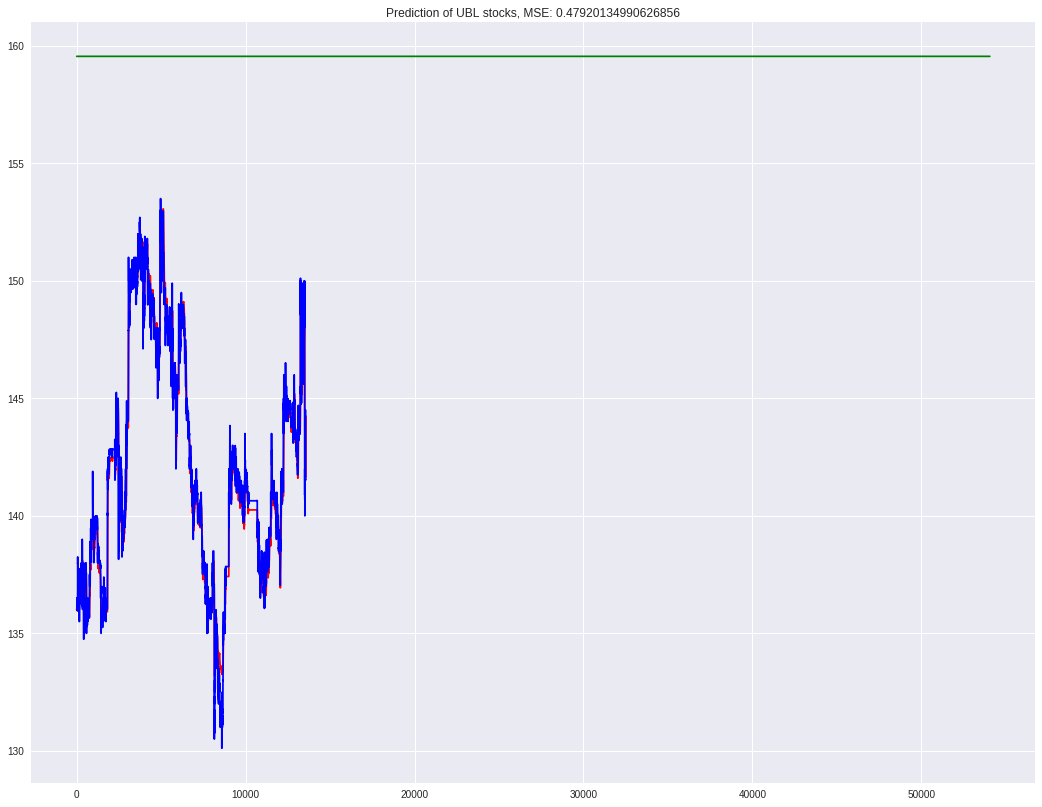

In [0]:
preds = model.predict(test_X)
f_preds = model.predict(future_X2)
print("fpreds", f_preds)
# print("Preds: {}".format(preds))
offset_list = [0]*n_train_periods
offset_list2 = [0]*int(len(offset_list+list(test_y))-200)
t = offset_list+list(preds.flatten())
# print("t len: {}".format(len(t)))
preds_inv = scaler_target.inverse_transform([offset_list+list(preds.flatten())])[0].reshape(-1, 1)
actu_inv = scaler_target.inverse_transform([offset_list+list(test_y)])[0].reshape(-1, 1)
f_preds_inv = scaler_target.inverse_transform([offset_list2+list(f_preds.flatten())])[0].reshape(-1, 1)
preds_inv = np.array(preds_inv)[n_train_periods:]
actu_inv = np.array(actu_inv)[n_train_periods:]
f_preds_inv = np.array(f_preds_inv)[:-200]
#   print(preds.flatten().shape, test_y.shape, preds_inv.shape, actu_inv.shape)
# print("predsOnly: {}".format(preds_inv))
preds_inv = preds_inv.flatten()
actu_inv = actu_inv.flatten()
preds = preds.flatten()
scaled_target = scaled_target.flatten()
f_preds_inv = f_preds_inv.flatten()

print(f_preds_inv, len(f_preds_inv))

plt.figure(figsize=(18, 14))
plt.title("Prediction of {} stocks, MSE: {}".format(k, mean_squared_error(preds_inv, actu_inv)))
plt.plot(preds_inv, 'r-')
plt.plot(actu_inv, 'b-')
plt.plot(f_preds_inv, 'g-')
plt.show()

In [0]:
market_data_df = pd.read_csv('Market_Data_06-11.csv', header=None)

In [0]:
xyz = [1, 2, 3, 4, 5, 6]

In [0]:
xyz.pop(0)

1

In [0]:
xyz

[2, 3, 4, 5, 6]

In [0]:
market_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275687 entries, 0 to 275686
Data columns (total 11 columns):
0     275687 non-null int64
1     275687 non-null object
2     275687 non-null float64
3     275687 non-null float64
4     275687 non-null float64
5     275687 non-null float64
6     275687 non-null float64
7     275687 non-null int64
8     275687 non-null int64
9     275687 non-null object
10    275687 non-null int64
dtypes: float64(5), int64(4), object(2)
memory usage: 23.1+ MB


In [0]:
market_data_df.head()

0       1         2      3     4         5         6        7   \
0  191861  KSE100  42858.58  11.94  0.03  42880.37  42780.91   591320   
1  191862  KSEALL  31376.32  14.04  0.04  31393.35  31353.03  1208720   
2  191863   KSE30  20951.53 -69.55 -0.33  21021.08  20901.61   542000   
3  191864   KMI30  72961.73 -20.35 -0.03  73099.45  72952.45   361100   
4  191865  PSXKMI  21401.29  19.26  0.09  21422.84  21382.03   524100   

         8                    9   10  
0  77607254  2018-06-01 09:00:05   0  
1  98990460  2018-06-01 09:00:07   0  
2  71496560  2018-06-01 09:00:09   0  
3  61040318  2018-06-01 09:00:10   0  
4  71892118  2018-06-01 09:00:11   0

In [0]:
print(reframed.expanding(min_periods=10000))

Expanding [min_periods=10000,center=False,axis=0]


In [0]:
market_data_df[1].value_counts()

KSE100    55149
KSEALL    55142
KSE30     55135
KMI30     55132
PSXKMI    55129
Name: 1, dtype: int64

In [0]:
stock_data_df = pd.read_csv('Stock_Data_06-11.csv', header=None)

In [0]:
stock_data_df.columns = ['id', 'symbol', 'last_price', 'change', 'change_percentage', 'bid_size', 'bid', 'offer', 'offer_size',
                         'turnover', 'high', 'low', 'open', 'last_volume', 'total_trades','last_trade', 'timestamp']

In [0]:
grouped_stock_data_dfs = stock_data_df.groupby('symbol')

In [0]:
from scipy.optimize import curve_fit

In [0]:
stk_df = grouped_stock_data_dfs.get_group(k)
proph_df = stk_df[['last_price']]
proph_df.columns = ['y']
#   proph_df.head()
reframed = series_to_supervised(proph_df, 'y', 20, 1)

In [0]:
reframed = reframed.append(pd.DataFrame(
    {
        cols12[0]: [np.nan]*27000,
        cols12[1]: [np.nan]*27000,
        cols12[2]: [np.nan]*27000,
        cols12[3]: [np.nan]*27000,
        cols12[4]: [np.nan]*27000,
        cols12[5]: [np.nan]*27000,
        cols12[6]: [np.nan]*27000,
        cols12[7]: [np.nan]*27000,
        cols12[8]: [np.nan]*27000,
        cols12[9]: [np.nan]*27000,
        cols12[10]: [np.nan]*27000,
        cols12[11]: [np.nan]*27000,
        cols12[12]: [np.nan]*27000,
        cols12[13]: [np.nan]*27000,
        cols12[14]: [np.nan]*27000,
        cols12[15]: [np.nan]*27000,
        cols12[16]: [np.nan]*27000,
        cols12[17]: [np.nan]*27000,
        cols12[18]: [np.nan]*27000,
        cols12[19]: [np.nan]*27000,
        cols12[20]: [np.nan]*27000,
    }
))

In [0]:
# def estimate_coef(x, y): 
#     # number of observations/points 
#     n = np.size(x) 
  
#     # mean of x and y vector 
#     m_x, m_y = np.mean(x), np.mean(y) 
  
#     # calculating cross-deviation and deviation about x 
#     SS_xy = np.sum(y*x) - n*m_y*m_x 
#     SS_xx = np.sum(x*x) - n*m_x*m_x 
  
#     # calculating regression coefficients 
#     b_1 = SS_xy / SS_xx 
#     b_0 = m_y - b_1*m_x 
  
#     return b_0 + b_11*x

In [0]:
# guess = (0.5, 0.5)
# # Curve fit each column
# for col in reframed.columns:
#     # Get x & y
#     x = reframed.index.astype(float).values
#     y = reframed[col].values
#     # Curve fit column and get curve parameters
#     params = curve_fit(estimate_coef, x, y, guess)
#     # Store optimized parameters
#     col_params[col] = params[0]

In [0]:
for k, v in grouped_stock_data_dfs:
  print("Stock: {}\tLength: {}".format(k, len(v)))

Stock: AKBL	Length: 54280
Stock: ANL	Length: 54279
Stock: ATLH	Length: 54276
Stock: BAFL	Length: 54279
Stock: BOP	Length: 54279
Stock: BYCO	Length: 54279
Stock: DAWH	Length: 54276
Stock: DCL	Length: 54279
Stock: DFML	Length: 54279
Stock: DGKC	Length: 54279
Stock: ENGRO	Length: 54279
Stock: FABL	Length: 54280
Stock: FDIBL	Length: 54279
Stock: FEROZ	Length: 54279
Stock: FFBL	Length: 54279
Stock: GHNI	Length: 54276
Stock: GHNL	Length: 54279
Stock: HASCOL	Length: 54279
Stock: HBL	Length: 54282
Stock: HCAR	Length: 54279
Stock: HUBC	Length: 54279
Stock: INDU	Length: 54279
Stock: INIL	Length: 54276
Stock: ISL	Length: 54279
Stock: JSBL	Length: 54276
Stock: KAPCO	Length: 54279
Stock: KEL	Length: 54279
Stock: KOHC	Length: 54279
Stock: LUCK	Length: 54278
Stock: MARI	Length: 54278
Stock: MCB	Length: 54277
Stock: MTL	Length: 54277
Stock: NBP	Length: 54277
Stock: OGDC	Length: 54277
Stock: PAEL	Length: 54277
Stock: PASL	Length: 54277
Stock: PIAA	Length: 54277
Stock: POL	Length: 54277
Stock: POWER	Len

AKBL
Train on 40695 samples, validate on 13565 samples
Epoch 1/30
40695/40695 [==============================] - 8s 188us/step - loss: 0.1888 - val_loss: 0.1992
Epoch 2/30
40695/40695 [==============================] - 1s 20us/step - loss: 0.0926 - val_loss: 0.2051
Epoch 3/30
40695/40695 [==============================] - 1s 20us/step - loss: 0.0540 - val_loss: 0.1991
Epoch 4/30
40695/40695 [==============================] - 1s 20us/step - loss: 0.0438 - val_loss: 0.1688
Epoch 5/30
40695/40695 [==============================] - 1s 20us/step - loss: 0.0387 - val_loss: 0.1437
Epoch 6/30
40695/40695 [==============================] - 1s 20us/step - loss: 0.0363 - val_loss: 0.1287
Epoch 7/30
40695/40695 [==============================] - 1s 20us/step - loss: 0.0342 - val_loss: 0.1154
Epoch 8/30
40695/40695 [==============================] - 1s 20us/step - loss: 0.0332 - val_loss: 0.1045
Epoch 9/30
40695/40695 [==============================] - 1s 20us/step - loss: 0.0318 - val_loss: 0.0948

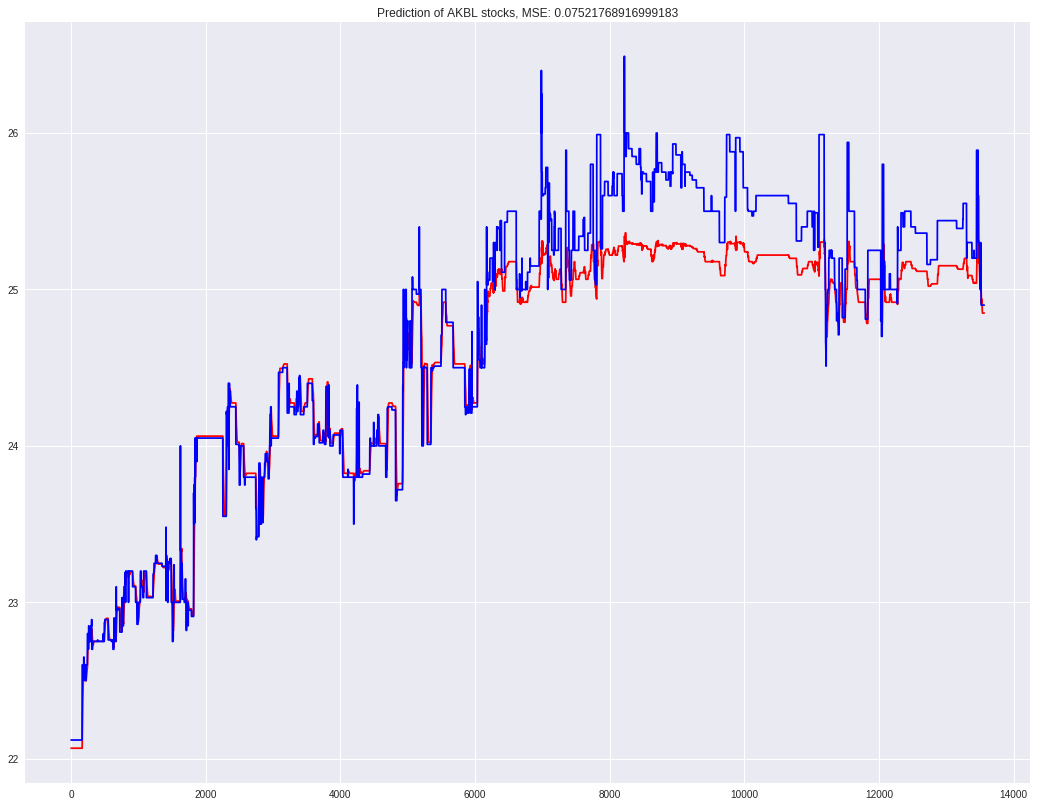

ANL
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 7s 183us/step - loss: 0.2316 - val_loss: 0.0970
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1109 - val_loss: 0.0455
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0832 - val_loss: 0.0285
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0707 - val_loss: 0.0350
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0632 - val_loss: 0.0365
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0587 - val_loss: 0.0328
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0541 - val_loss: 0.0287
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0507 - val_loss: 0.0254
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0484 - val_loss: 0.0245


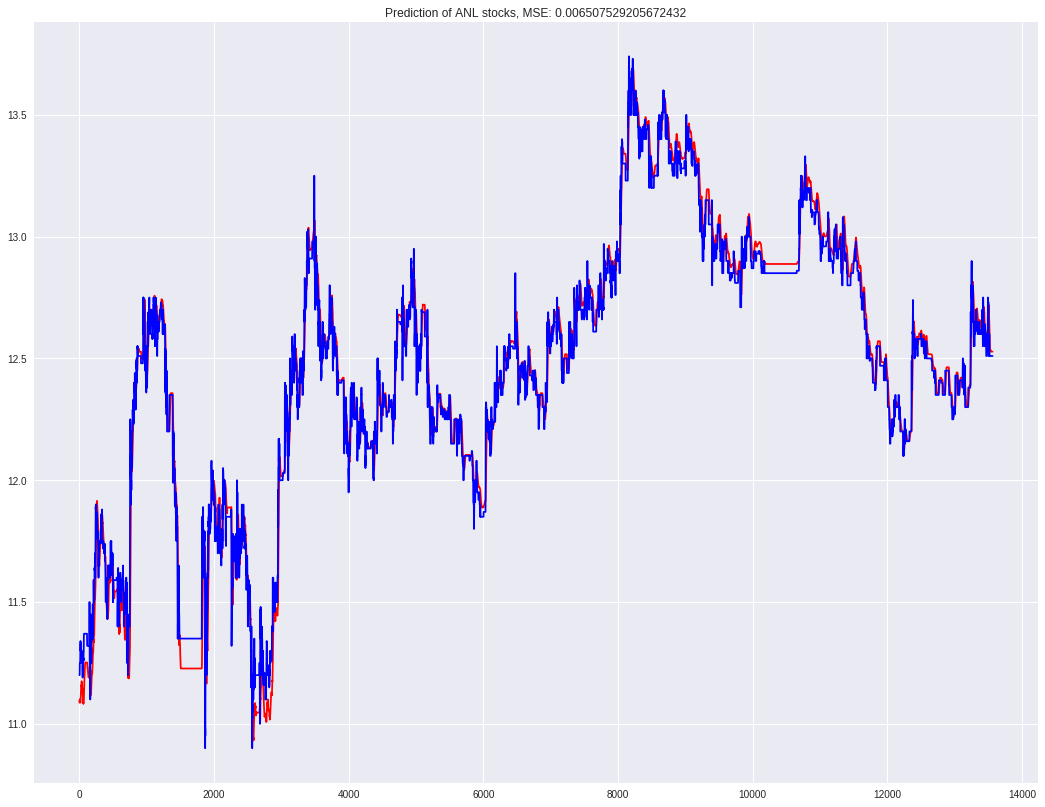

ATLH
Train on 40692 samples, validate on 13564 samples
Epoch 1/30
40692/40692 [==============================] - 8s 189us/step - loss: 0.3808 - val_loss: 0.1057
Epoch 2/30
40692/40692 [==============================] - 1s 19us/step - loss: 0.1564 - val_loss: 0.0865
Epoch 3/30
40692/40692 [==============================] - 1s 19us/step - loss: 0.1274 - val_loss: 0.0648
Epoch 4/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.1093 - val_loss: 0.0595
Epoch 5/30
40692/40692 [==============================] - 1s 19us/step - loss: 0.0952 - val_loss: 0.0516
Epoch 6/30
40692/40692 [==============================] - 1s 19us/step - loss: 0.0867 - val_loss: 0.0467
Epoch 7/30
40692/40692 [==============================] - 1s 19us/step - loss: 0.0794 - val_loss: 0.0457
Epoch 8/30
40692/40692 [==============================] - 1s 19us/step - loss: 0.0749 - val_loss: 0.0450
Epoch 9/30
40692/40692 [==============================] - 1s 19us/step - loss: 0.0711 - val_loss: 0.0408

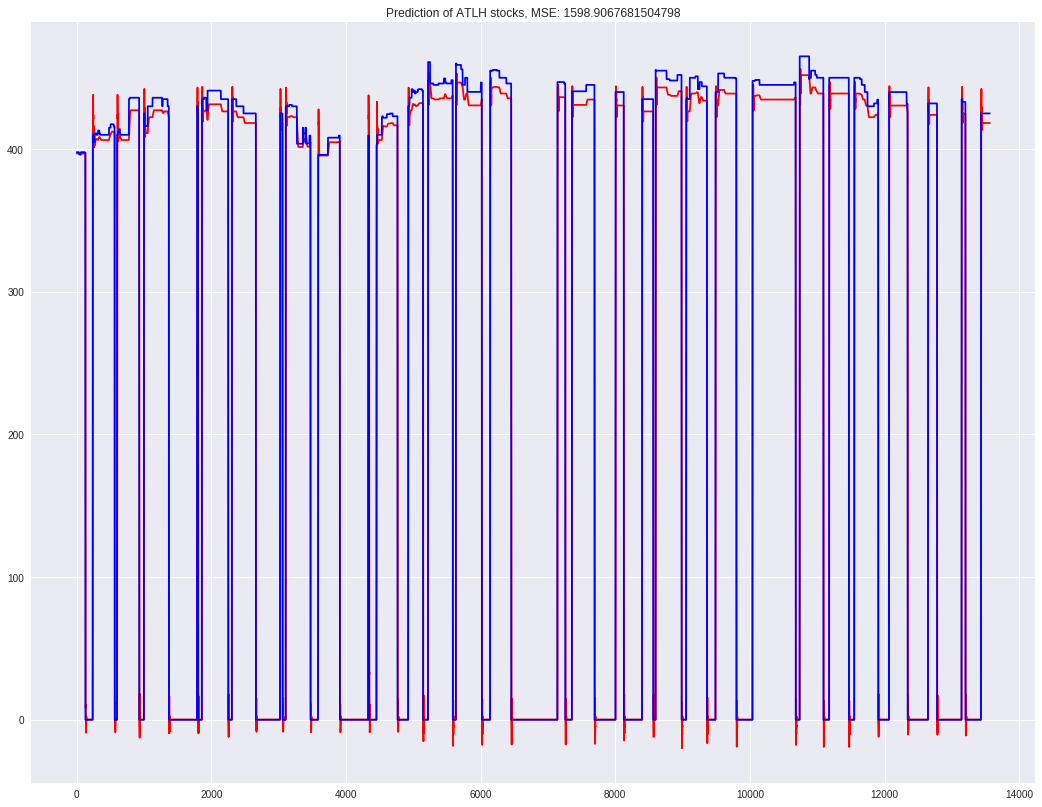

BAFL
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 8s 192us/step - loss: 0.2501 - val_loss: 0.1628
Epoch 2/30
40694/40694 [==============================] - 1s 19us/step - loss: 0.1091 - val_loss: 0.1390
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1034 - val_loss: 0.1257
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0952 - val_loss: 0.1074
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0901 - val_loss: 0.0911
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0861 - val_loss: 0.0763
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0811 - val_loss: 0.0622
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0763 - val_loss: 0.0476
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0712 - val_loss: 0.0361

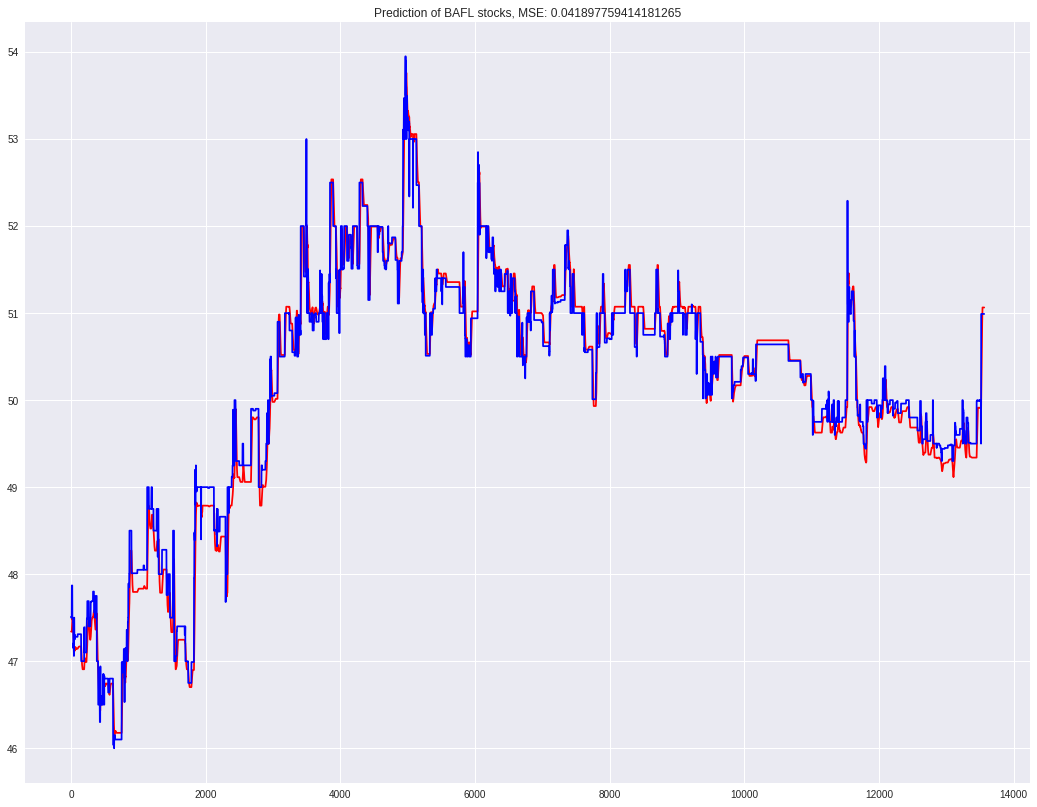

BOP
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 8s 197us/step - loss: 0.1768 - val_loss: 0.2155
Epoch 2/30
40694/40694 [==============================] - 1s 19us/step - loss: 0.0782 - val_loss: 0.0199
Epoch 3/30
40694/40694 [==============================] - 1s 19us/step - loss: 0.0424 - val_loss: 0.0544
Epoch 4/30
40694/40694 [==============================] - 1s 19us/step - loss: 0.0386 - val_loss: 0.0555
Epoch 5/30
40694/40694 [==============================] - 1s 19us/step - loss: 0.0348 - val_loss: 0.0327
Epoch 6/30
40694/40694 [==============================] - 1s 19us/step - loss: 0.0310 - val_loss: 0.0241
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0296 - val_loss: 0.0255
Epoch 8/30
40694/40694 [==============================] - 1s 19us/step - loss: 0.0290 - val_loss: 0.0263
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0290 - val_loss: 0.0232


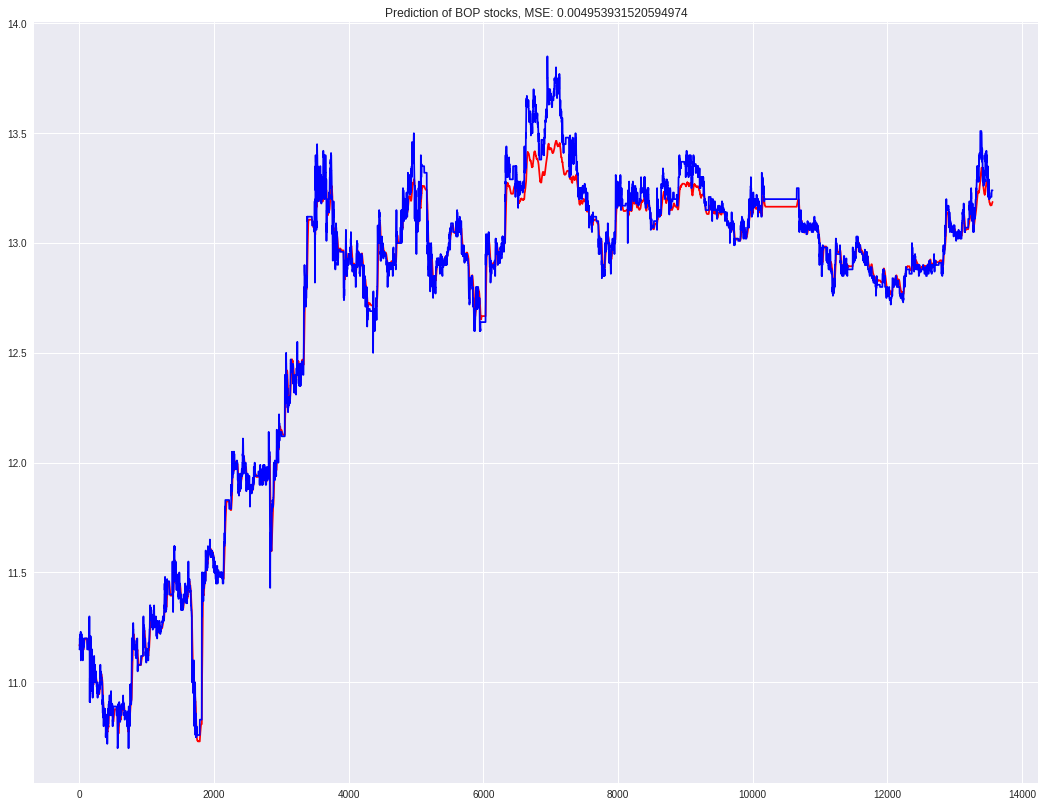

BYCO
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 9s 211us/step - loss: 0.3222 - val_loss: 0.0774
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1386 - val_loss: 0.0821
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1014 - val_loss: 0.0194
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0757 - val_loss: 0.0222
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0693 - val_loss: 0.0209
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0698 - val_loss: 0.0169
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0650 - val_loss: 0.0238
Epoch 8/30
40694/40694 [==============================] - 1s 19us/step - loss: 0.0672 - val_loss: 0.0168
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0630 - val_loss: 0.0282

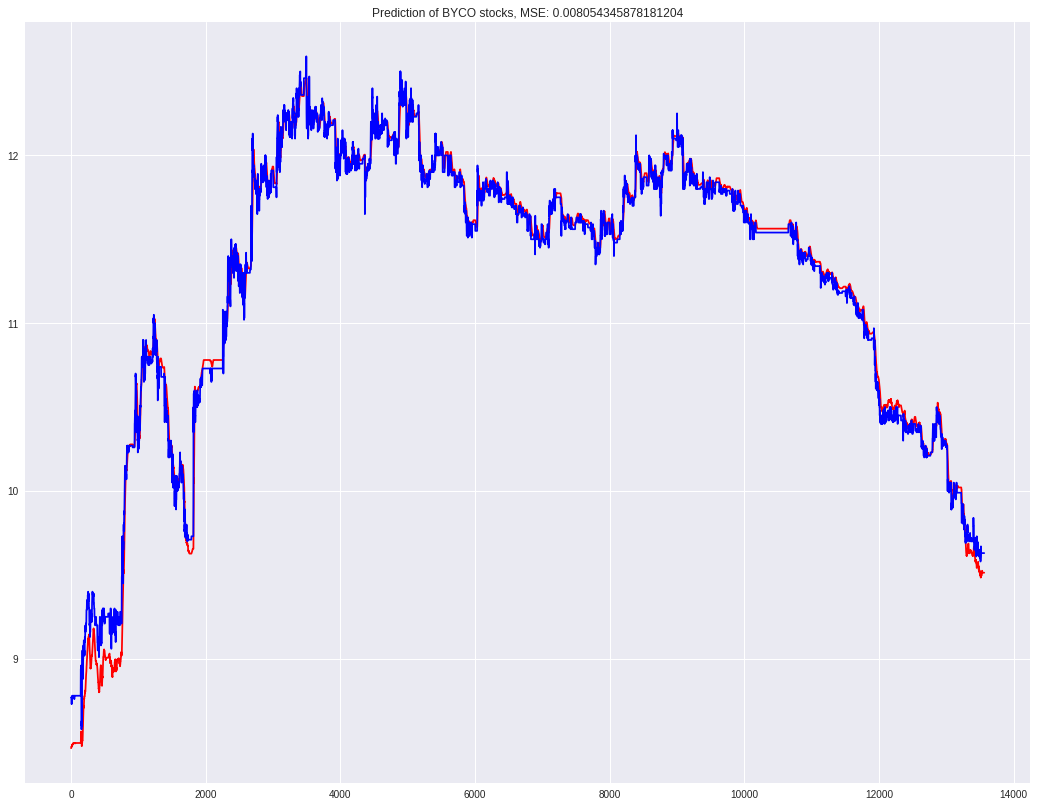

DAWH
Train on 40692 samples, validate on 13564 samples
Epoch 1/30
40692/40692 [==============================] - 9s 214us/step - loss: 0.3113 - val_loss: 0.1276
Epoch 2/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.1020 - val_loss: 0.0697
Epoch 3/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0749 - val_loss: 0.1054
Epoch 4/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0673 - val_loss: 0.1189
Epoch 5/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0624 - val_loss: 0.1343
Epoch 6/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0592 - val_loss: 0.1384
Epoch 7/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0569 - val_loss: 0.1501
Epoch 8/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0550 - val_loss: 0.1524
Epoch 9/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0537 - val_loss: 0.1556

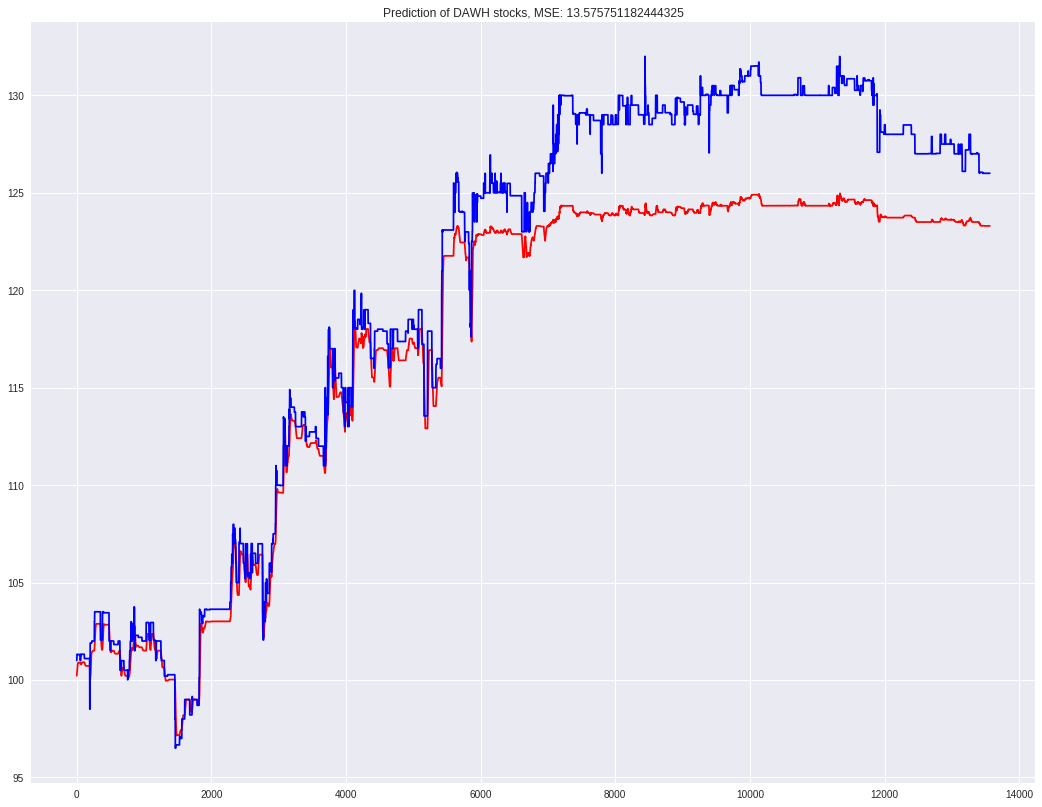

DCL
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 9s 223us/step - loss: 0.3637 - val_loss: 0.0781
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1336 - val_loss: 0.0558
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1204 - val_loss: 0.0449
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1095 - val_loss: 0.0404
Epoch 5/30
40694/40694 [==============================] - 1s 21us/step - loss: 0.1004 - val_loss: 0.0346
Epoch 6/30
40694/40694 [==============================] - 1s 21us/step - loss: 0.0880 - val_loss: 0.0311
Epoch 7/30
40694/40694 [==============================] - 1s 21us/step - loss: 0.0752 - val_loss: 0.0294
Epoch 8/30
40694/40694 [==============================] - 1s 21us/step - loss: 0.0649 - val_loss: 0.0243
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0550 - val_loss: 0.0190


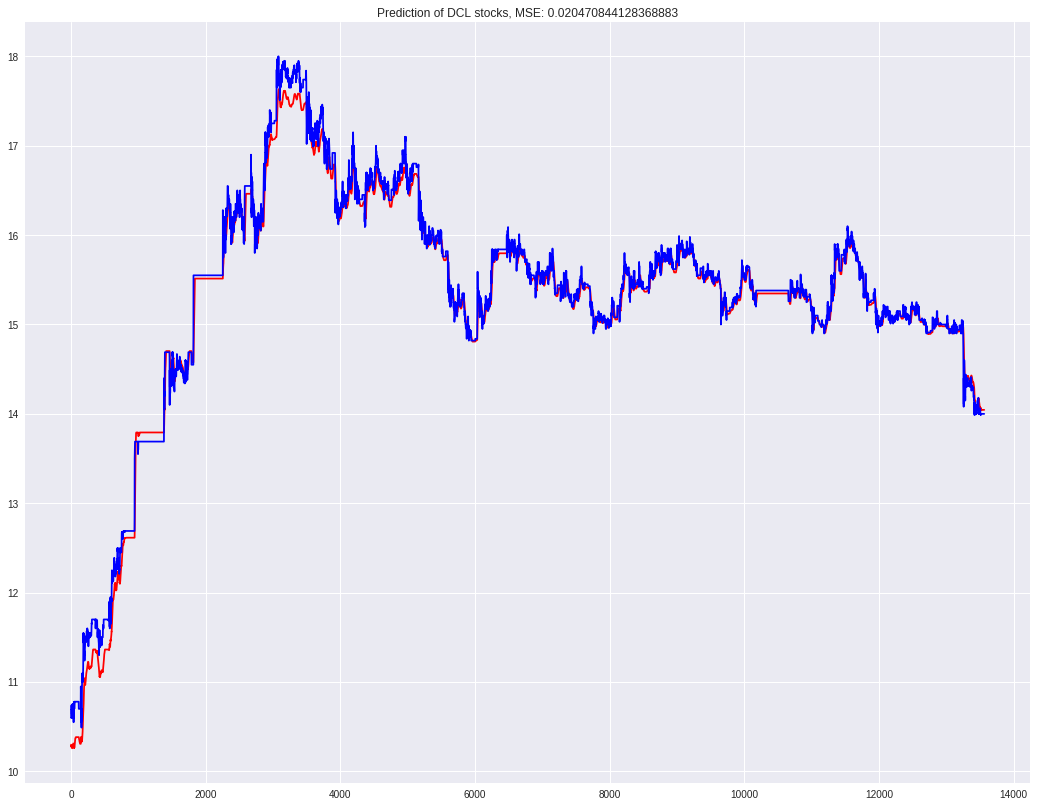

DFML
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 9s 231us/step - loss: 0.2106 - val_loss: 0.4055
Epoch 2/30
40694/40694 [==============================] - 1s 21us/step - loss: 0.1410 - val_loss: 0.2550
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1041 - val_loss: 0.1519
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0826 - val_loss: 0.0765
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0777 - val_loss: 0.0607
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0722 - val_loss: 0.0840
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0666 - val_loss: 0.0958
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0618 - val_loss: 0.0882
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0576 - val_loss: 0.0794

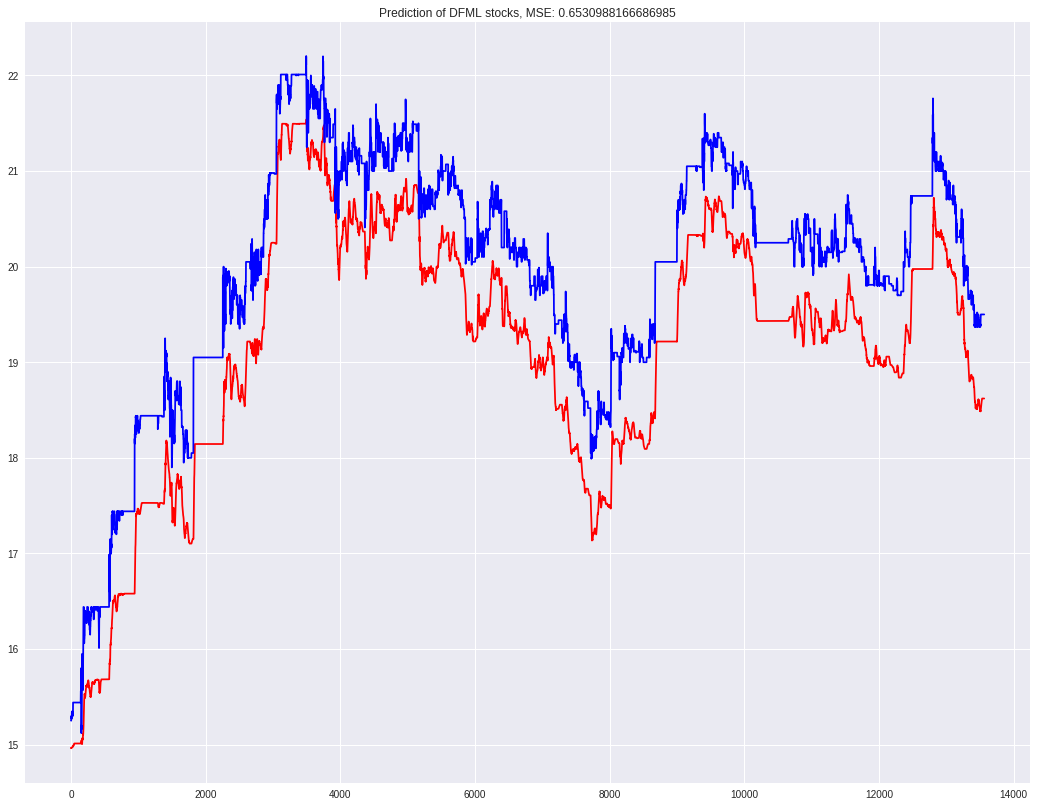

DGKC
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 10s 236us/step - loss: 0.2750 - val_loss: 0.1873
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1179 - val_loss: 0.0922
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0803 - val_loss: 0.0471
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0700 - val_loss: 0.0335
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0646 - val_loss: 0.0307
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0571 - val_loss: 0.0353
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0540 - val_loss: 0.0353
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0498 - val_loss: 0.0349
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0485 - val_loss: 0.032

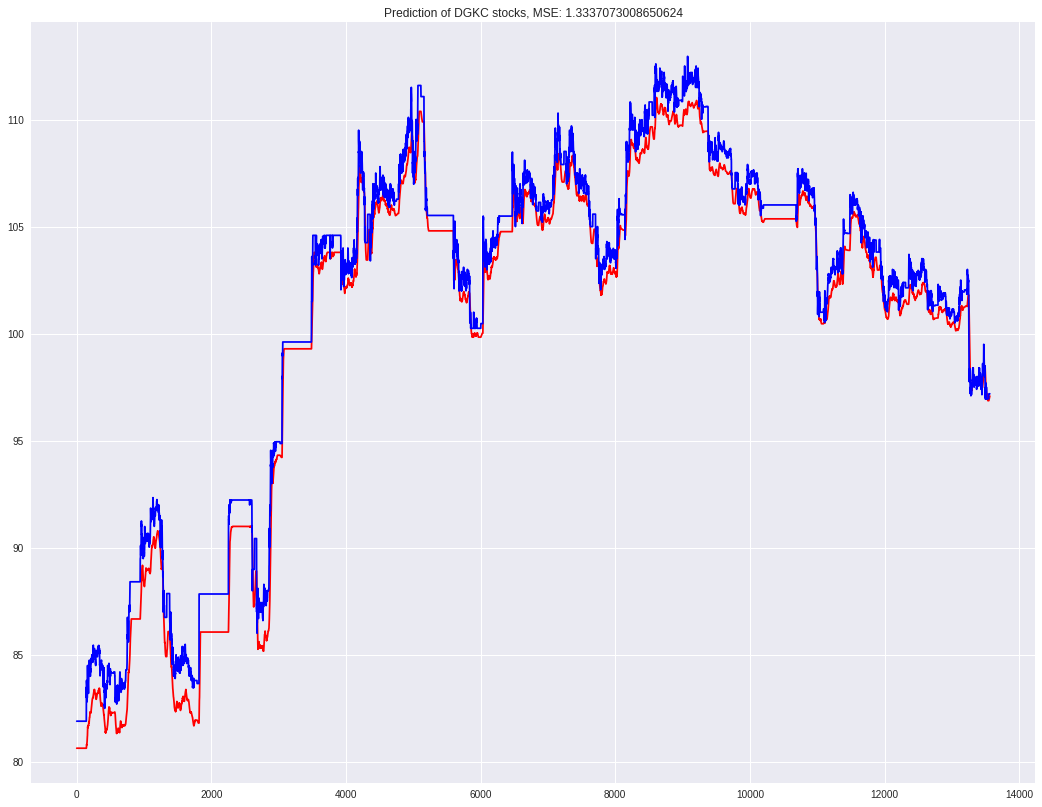

ENGRO
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 10s 241us/step - loss: 0.2426 - val_loss: 0.2206
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1257 - val_loss: 0.0642
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0815 - val_loss: 0.0533
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0654 - val_loss: 0.0376
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0569 - val_loss: 0.0281
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0485 - val_loss: 0.0314
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0438 - val_loss: 0.0344
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0412 - val_loss: 0.0326
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0393 - val_loss: 0.03

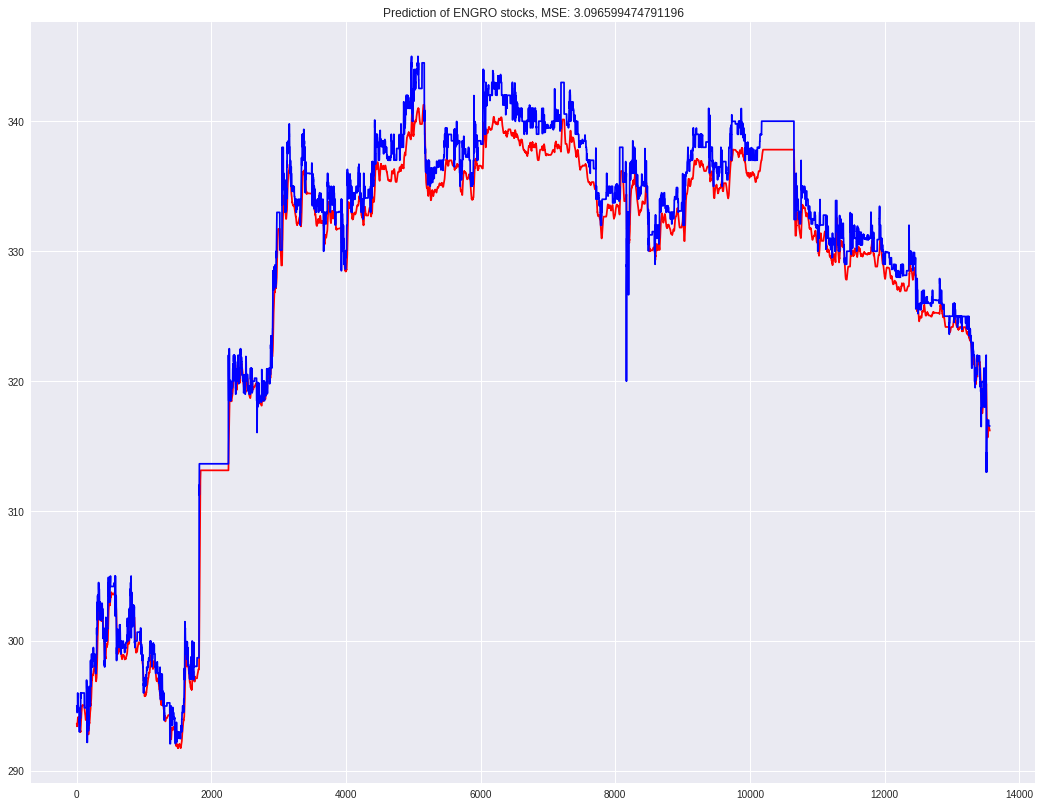

FABL
Train on 40695 samples, validate on 13565 samples
Epoch 1/30
40695/40695 [==============================] - 10s 246us/step - loss: 0.1760 - val_loss: 0.1438
Epoch 2/30
40695/40695 [==============================] - 1s 20us/step - loss: 0.0614 - val_loss: 0.0328
Epoch 3/30
40695/40695 [==============================] - 1s 20us/step - loss: 0.0584 - val_loss: 0.0276
Epoch 4/30
40695/40695 [==============================] - 1s 21us/step - loss: 0.0556 - val_loss: 0.0300
Epoch 5/30
40695/40695 [==============================] - 1s 20us/step - loss: 0.0526 - val_loss: 0.0299
Epoch 6/30
40695/40695 [==============================] - 1s 20us/step - loss: 0.0469 - val_loss: 0.0319
Epoch 7/30
40695/40695 [==============================] - 1s 20us/step - loss: 0.0435 - val_loss: 0.0313
Epoch 8/30
40695/40695 [==============================] - 1s 20us/step - loss: 0.0420 - val_loss: 0.0278
Epoch 9/30
40695/40695 [==============================] - 1s 21us/step - loss: 0.0401 - val_loss: 0.027

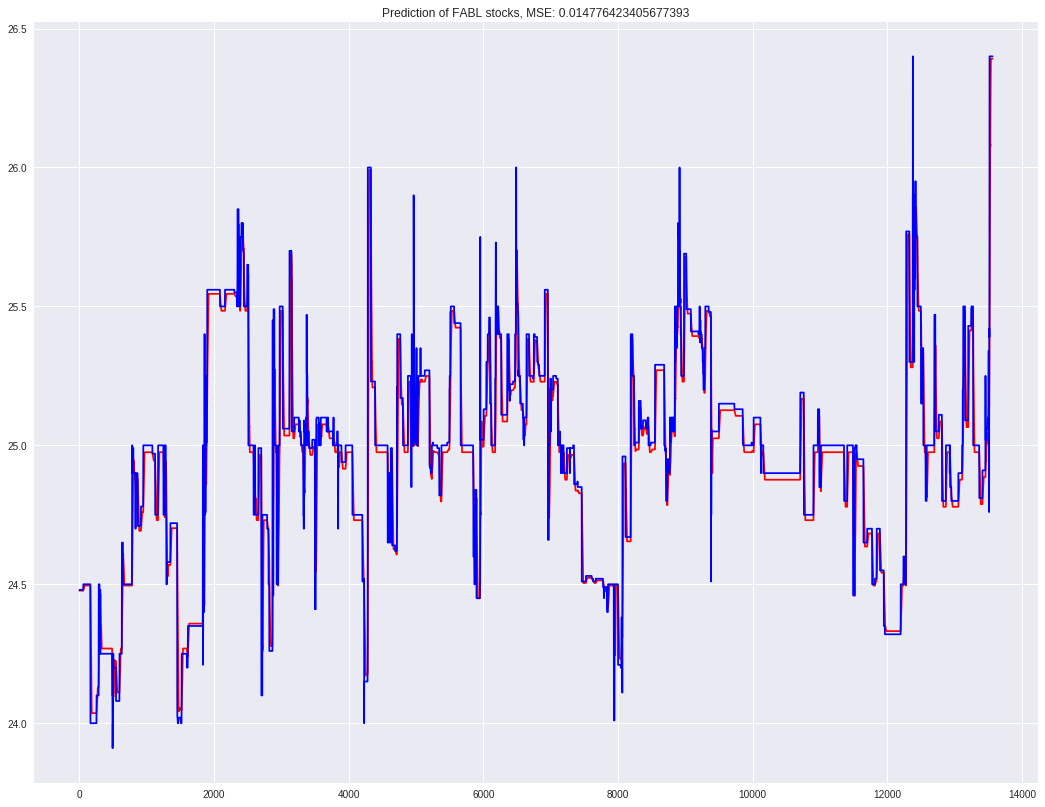

FDIBL
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 10s 254us/step - loss: 0.2806 - val_loss: 0.0562
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1381 - val_loss: 0.0459
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1115 - val_loss: 0.0325
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0988 - val_loss: 0.0291
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0807 - val_loss: 0.0277
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0724 - val_loss: 0.0272
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0691 - val_loss: 0.0253
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0669 - val_loss: 0.0291
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0654 - val_loss: 0.02

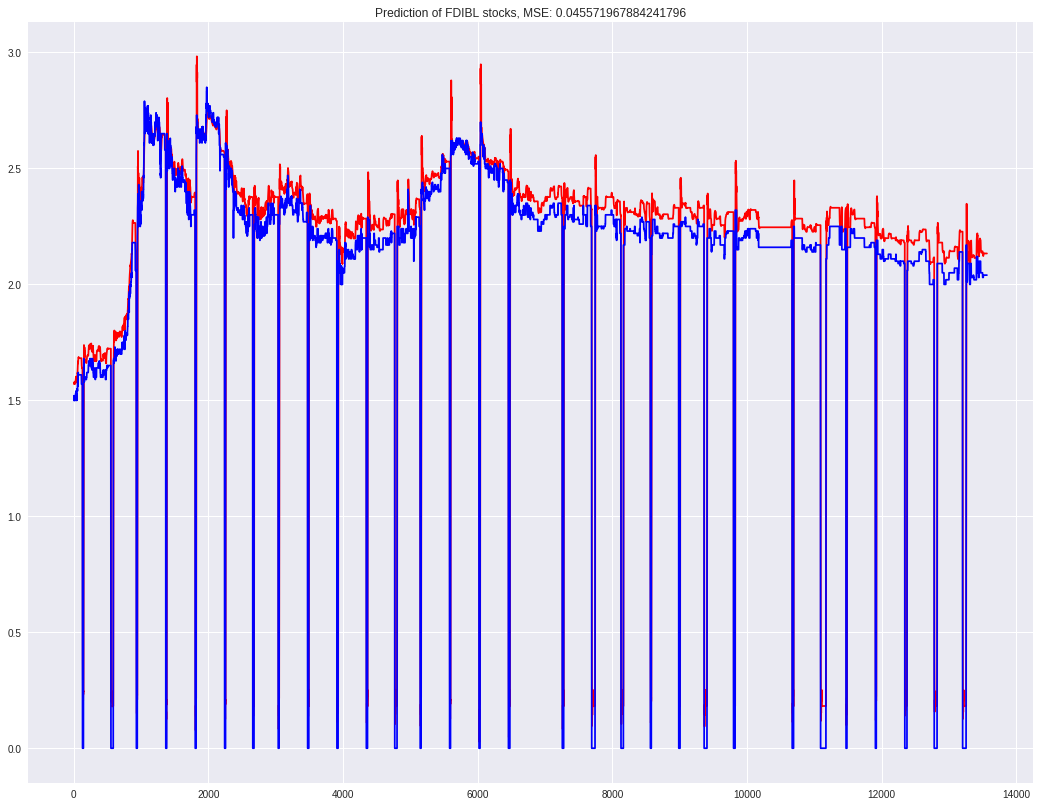

FEROZ
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 10s 255us/step - loss: 0.3425 - val_loss: 0.2138
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1394 - val_loss: 0.1259
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0917 - val_loss: 0.0828
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0762 - val_loss: 0.0371
Epoch 5/30
40694/40694 [==============================] - 1s 21us/step - loss: 0.0639 - val_loss: 0.0287
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0520 - val_loss: 0.0229
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0459 - val_loss: 0.0228
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0447 - val_loss: 0.0222
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0442 - val_loss: 0.02

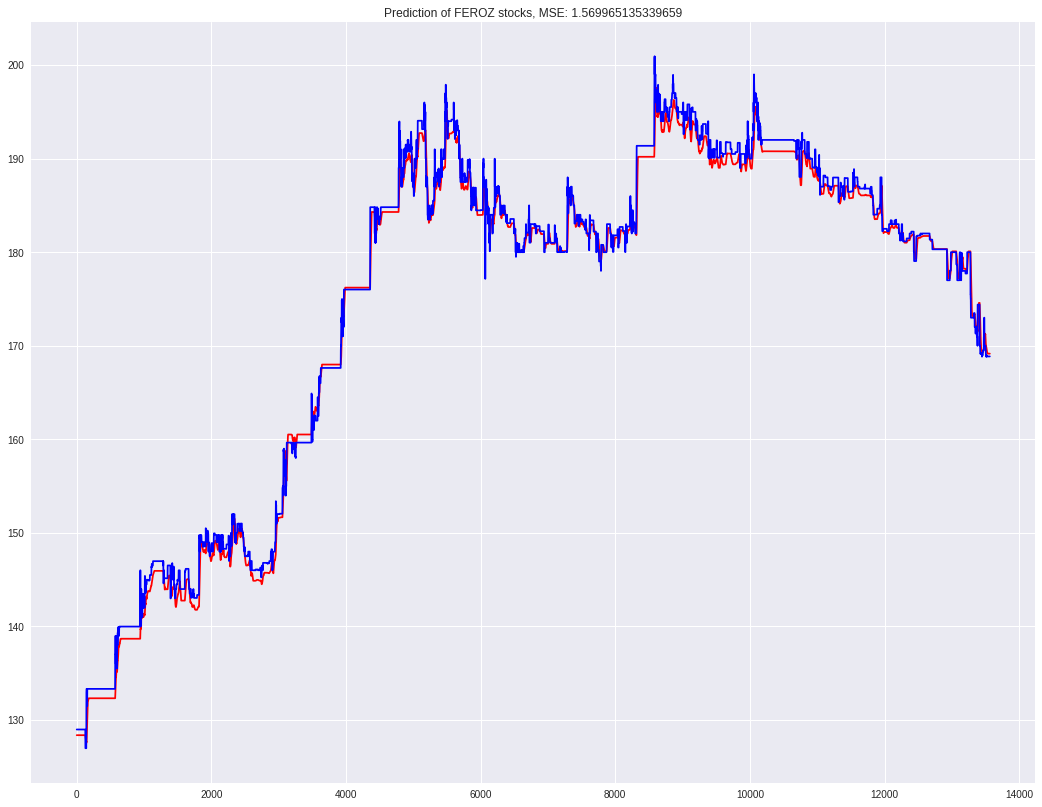

FFBL
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 10s 258us/step - loss: 0.1629 - val_loss: 0.1387
Epoch 2/30
40694/40694 [==============================] - 1s 21us/step - loss: 0.0826 - val_loss: 0.1027
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0756 - val_loss: 0.1136
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0704 - val_loss: 0.1076
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0670 - val_loss: 0.0970
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0633 - val_loss: 0.0924
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0587 - val_loss: 0.0904
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0540 - val_loss: 0.0818
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0488 - val_loss: 0.076

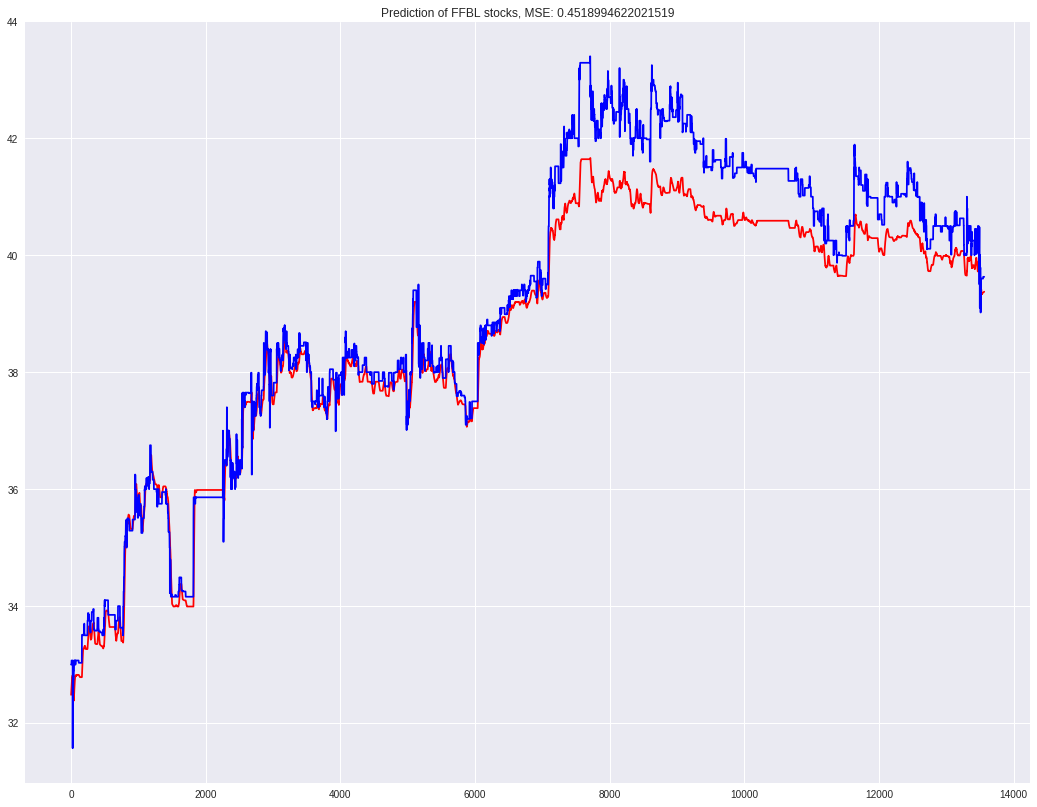

GHNI
Train on 40692 samples, validate on 13564 samples
Epoch 1/30
40692/40692 [==============================] - 11s 265us/step - loss: 0.2357 - val_loss: 0.6326
Epoch 2/30
40692/40692 [==============================] - 1s 19us/step - loss: 0.1004 - val_loss: 0.5274
Epoch 3/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0915 - val_loss: 0.4055
Epoch 4/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0831 - val_loss: 0.2379
Epoch 5/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0721 - val_loss: 0.0690
Epoch 6/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0635 - val_loss: 0.1855
Epoch 7/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0632 - val_loss: 0.1181
Epoch 8/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0642 - val_loss: 0.2714
Epoch 9/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0615 - val_loss: 0.110

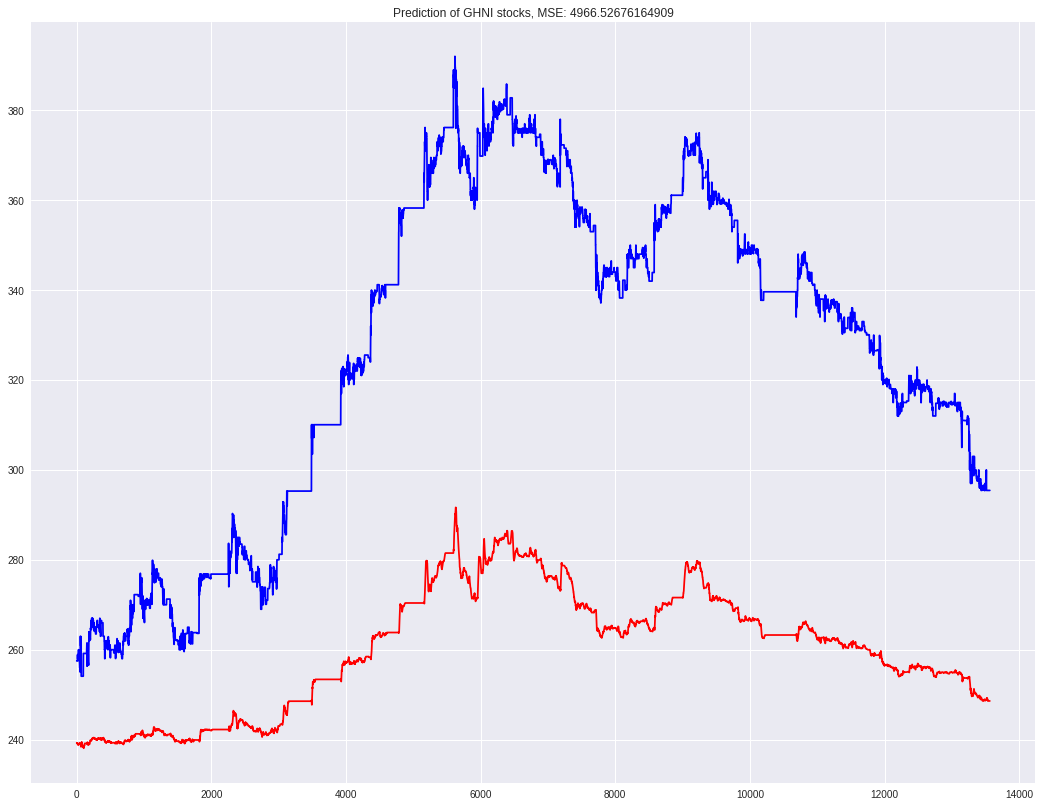

GHNL
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 11s 272us/step - loss: 0.3357 - val_loss: 0.4336
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1386 - val_loss: 0.1159
Epoch 3/30
40694/40694 [==============================] - 1s 19us/step - loss: 0.1128 - val_loss: 0.0722
Epoch 4/30
40694/40694 [==============================] - 1s 21us/step - loss: 0.0715 - val_loss: 0.0257
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0561 - val_loss: 0.0165
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0494 - val_loss: 0.0132
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0402 - val_loss: 0.0174
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0417 - val_loss: 0.0216
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0390 - val_loss: 0.022

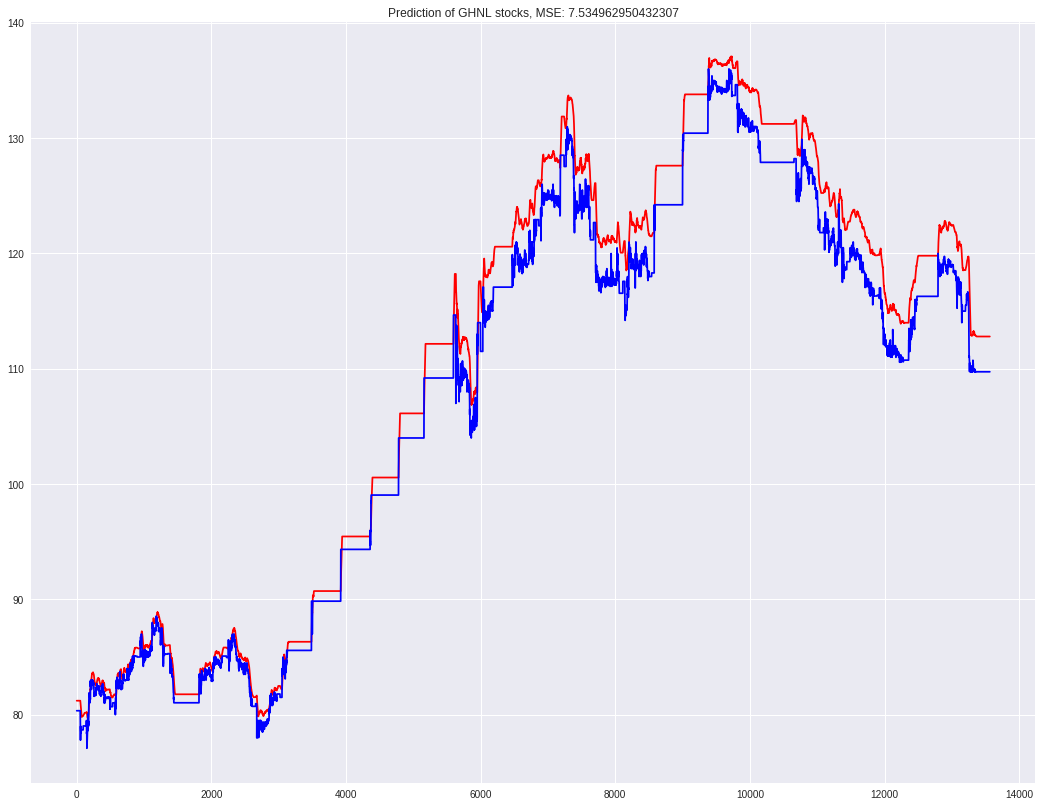

HASCOL
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 11s 279us/step - loss: 0.3217 - val_loss: 0.1467
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1621 - val_loss: 0.1459
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1509 - val_loss: 0.1397
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1326 - val_loss: 0.1327
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1103 - val_loss: 0.1286
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1016 - val_loss: 0.1277
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0978 - val_loss: 0.1261
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0934 - val_loss: 0.1223
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0911 - val_loss: 0.1

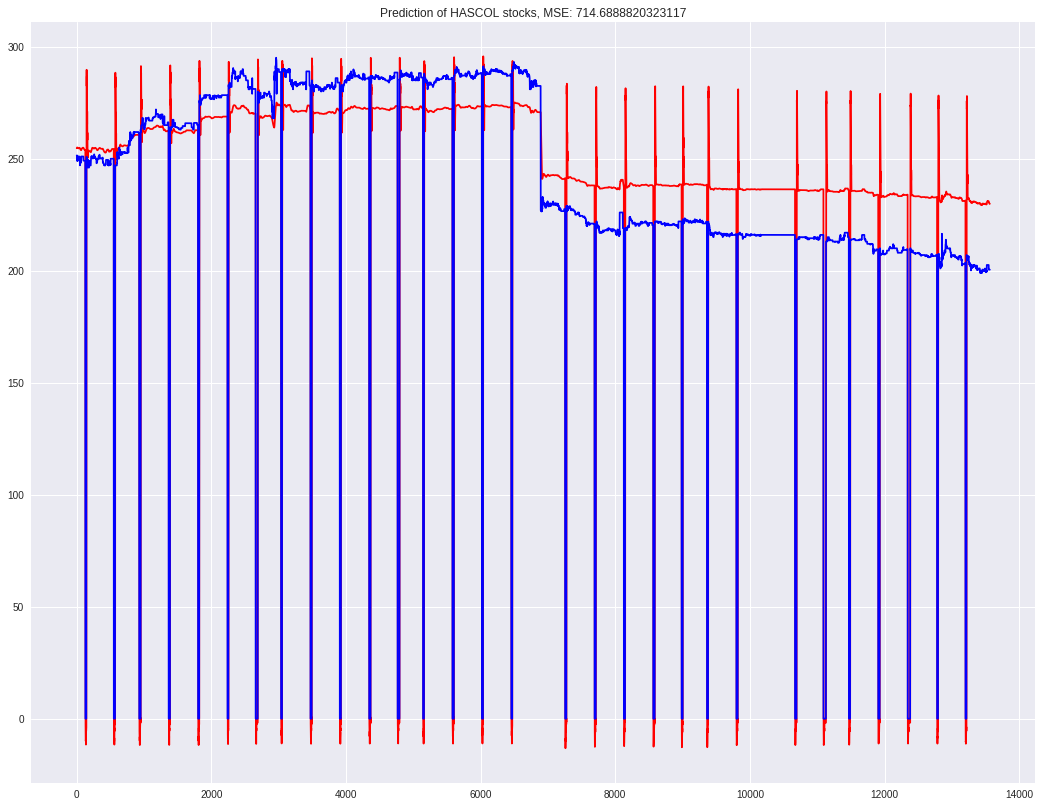

HBL
Train on 40696 samples, validate on 13566 samples
Epoch 1/30
40696/40696 [==============================] - 12s 284us/step - loss: 0.2876 - val_loss: 0.4786
Epoch 2/30
40696/40696 [==============================] - 1s 20us/step - loss: 0.1293 - val_loss: 0.2639
Epoch 3/30
40696/40696 [==============================] - 1s 20us/step - loss: 0.0862 - val_loss: 0.1090
Epoch 4/30
40696/40696 [==============================] - 1s 20us/step - loss: 0.0771 - val_loss: 0.0732
Epoch 5/30
40696/40696 [==============================] - 1s 20us/step - loss: 0.0683 - val_loss: 0.0482
Epoch 6/30
40696/40696 [==============================] - 1s 20us/step - loss: 0.0633 - val_loss: 0.0430
Epoch 7/30
40696/40696 [==============================] - 1s 20us/step - loss: 0.0558 - val_loss: 0.0384
Epoch 8/30
40696/40696 [==============================] - 1s 20us/step - loss: 0.0487 - val_loss: 0.0299
Epoch 9/30
40696/40696 [==============================] - 1s 20us/step - loss: 0.0431 - val_loss: 0.0267

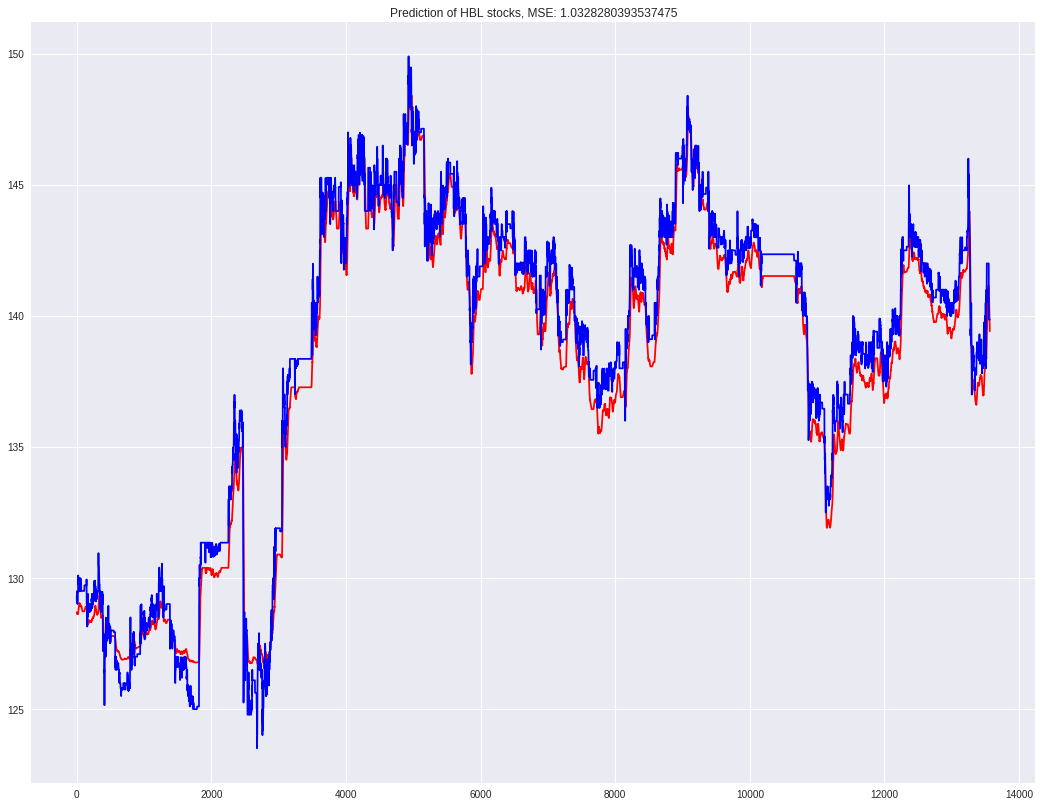

HCAR
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 12s 287us/step - loss: 0.1873 - val_loss: 0.2216
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1427 - val_loss: 0.1497
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0959 - val_loss: 0.0628
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0732 - val_loss: 0.0567
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0531 - val_loss: 0.0323
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0415 - val_loss: 0.0285
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0347 - val_loss: 0.0193
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0374 - val_loss: 0.0309
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0326 - val_loss: 0.019

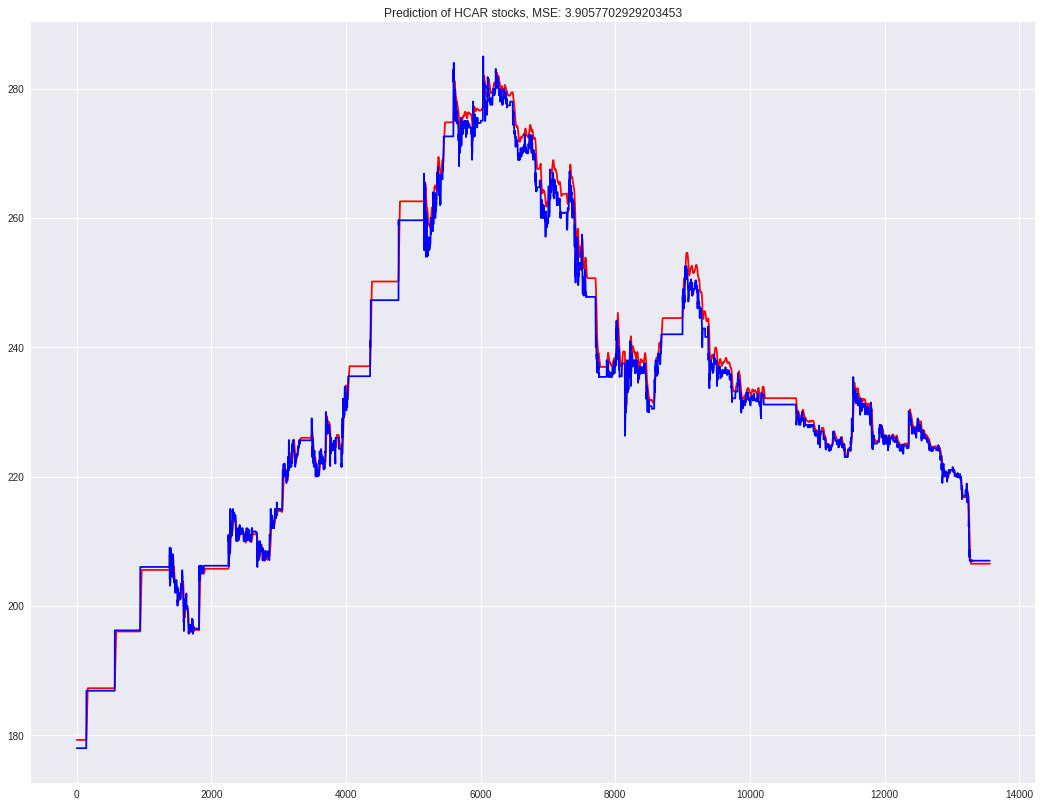

HUBC
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 12s 294us/step - loss: 0.2866 - val_loss: 0.1061
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1046 - val_loss: 0.0533
Epoch 3/30
40694/40694 [==============================] - 1s 19us/step - loss: 0.0757 - val_loss: 0.0440
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0680 - val_loss: 0.0335
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0602 - val_loss: 0.0286
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0560 - val_loss: 0.0247
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0513 - val_loss: 0.0209
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0480 - val_loss: 0.0238
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0449 - val_loss: 0.027

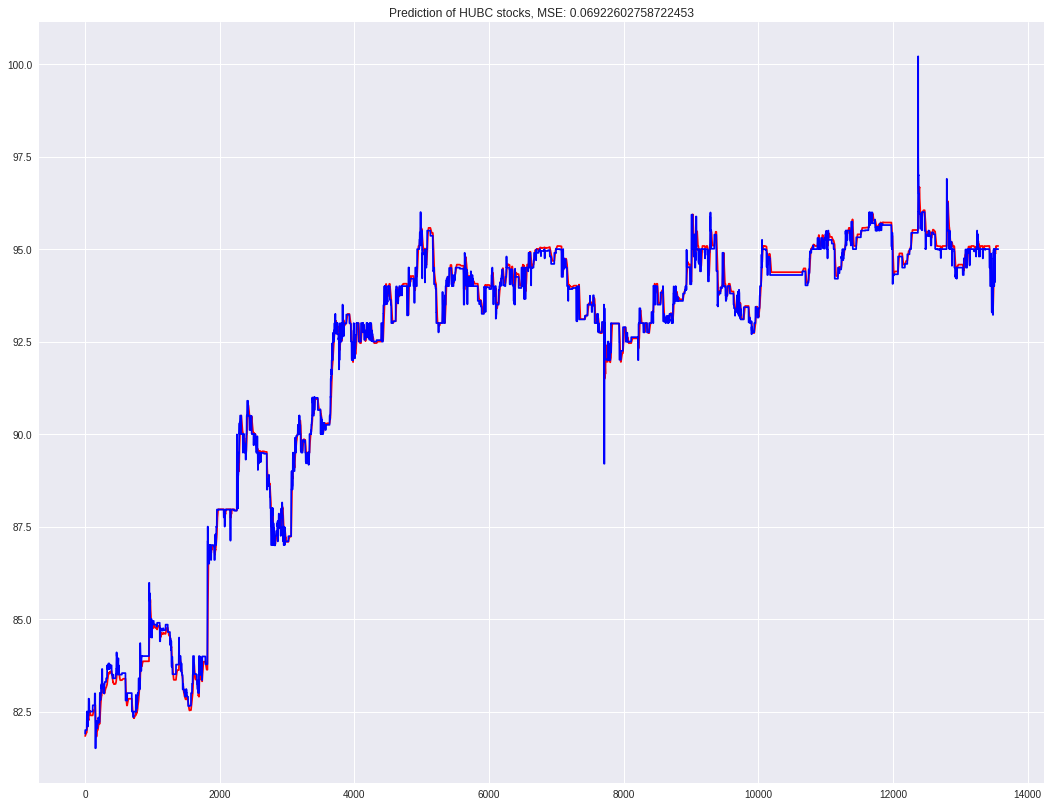

INDU
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 12s 298us/step - loss: 0.5492 - val_loss: 0.1592
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1906 - val_loss: 0.0953
Epoch 3/30
40694/40694 [==============================] - 1s 21us/step - loss: 0.1458 - val_loss: 0.0704
Epoch 4/30
40694/40694 [==============================] - 1s 21us/step - loss: 0.1300 - val_loss: 0.0653
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1218 - val_loss: 0.0583
Epoch 6/30
40694/40694 [==============================] - 1s 21us/step - loss: 0.1152 - val_loss: 0.0537
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1073 - val_loss: 0.0485
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1009 - val_loss: 0.0447
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0949 - val_loss: 0.042

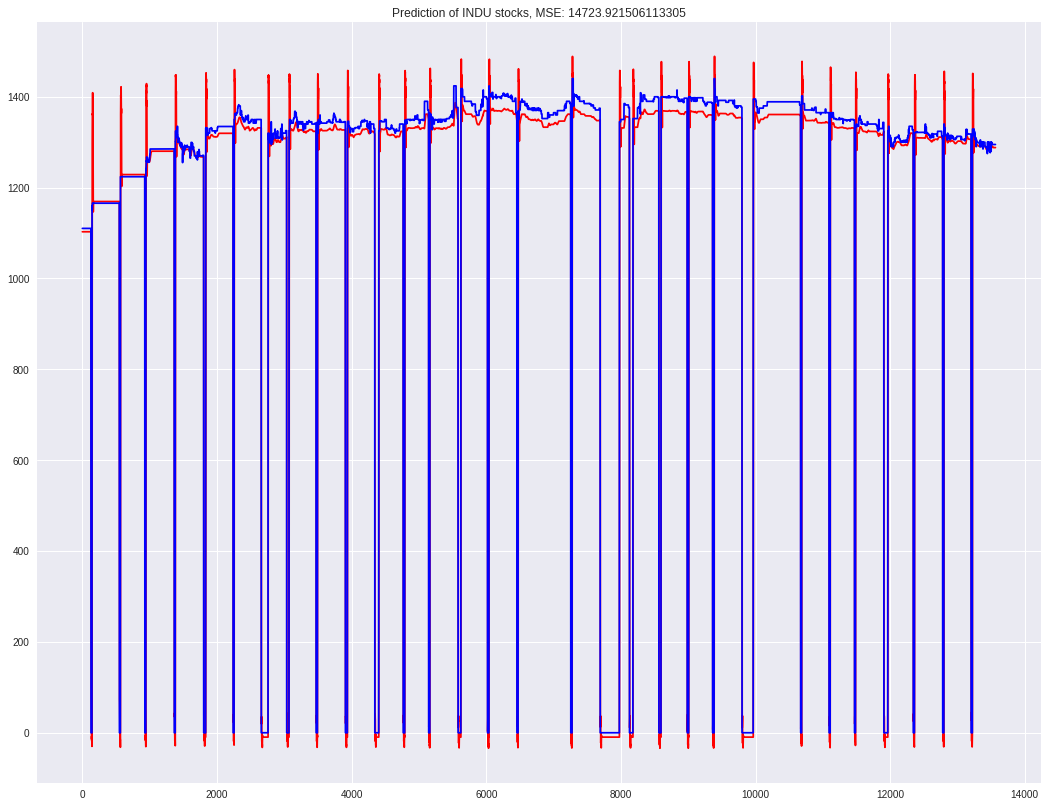

INIL
Train on 40692 samples, validate on 13564 samples
Epoch 1/30
40692/40692 [==============================] - 12s 305us/step - loss: 0.2276 - val_loss: 0.3695
Epoch 2/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0922 - val_loss: 0.1052
Epoch 3/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0699 - val_loss: 0.0465
Epoch 4/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0640 - val_loss: 0.0366
Epoch 5/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0594 - val_loss: 0.0376
Epoch 6/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0574 - val_loss: 0.0348
Epoch 7/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0549 - val_loss: 0.0388
Epoch 8/30
40692/40692 [==============================] - 1s 19us/step - loss: 0.0543 - val_loss: 0.0296
Epoch 9/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0535 - val_loss: 0.040

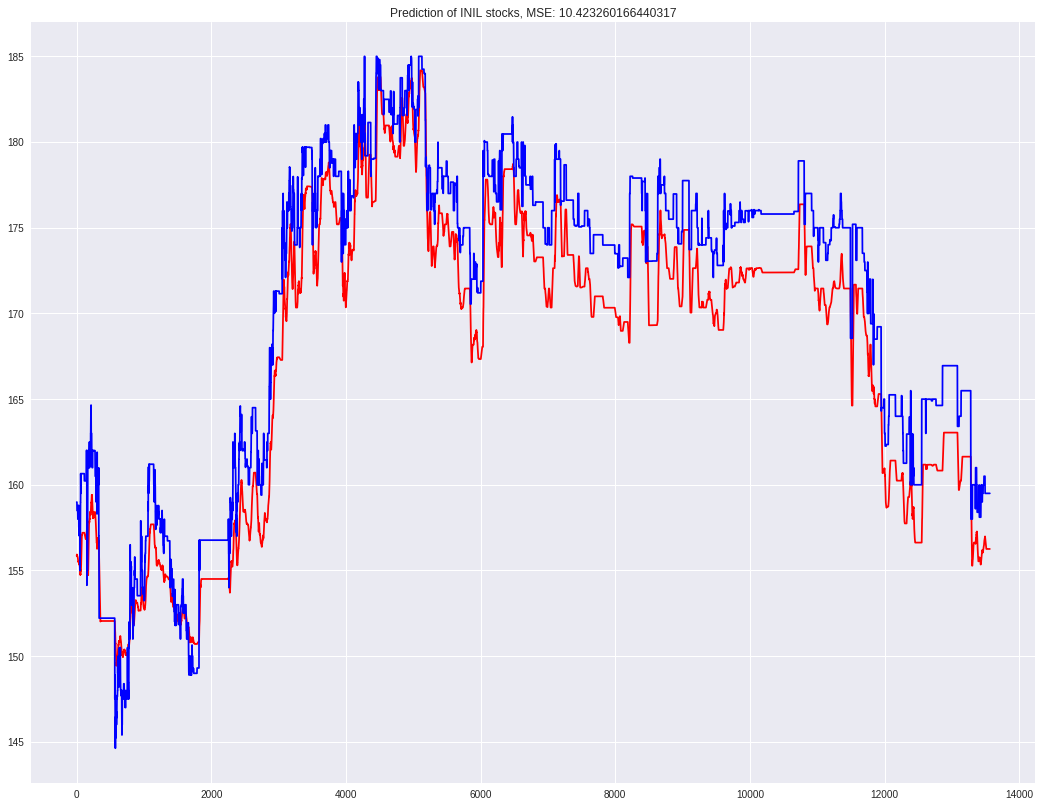

ISL
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 13s 311us/step - loss: 0.3710 - val_loss: 0.3848
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1204 - val_loss: 0.1618
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0721 - val_loss: 0.0477
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0694 - val_loss: 0.0377
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0677 - val_loss: 0.0320
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0629 - val_loss: 0.0373
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0594 - val_loss: 0.0366
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0572 - val_loss: 0.0358
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0557 - val_loss: 0.0373

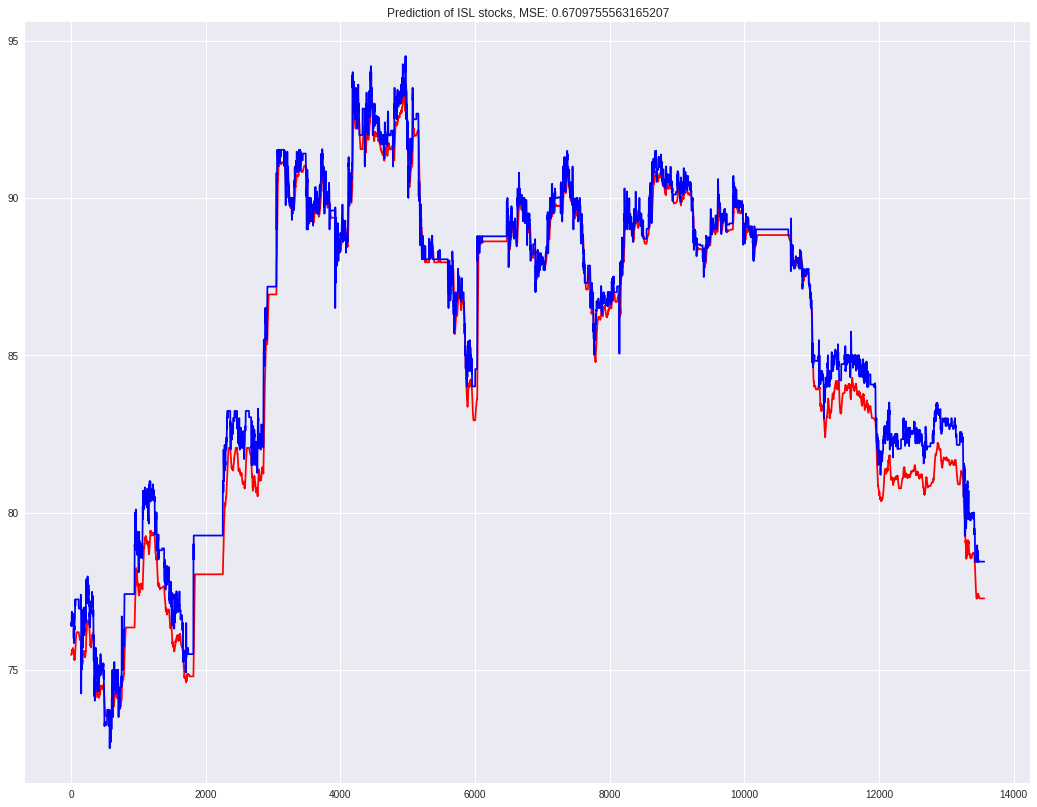

JSBL
Train on 40692 samples, validate on 13564 samples
Epoch 1/30
40692/40692 [==============================] - 13s 317us/step - loss: 0.6549 - val_loss: 0.3409
Epoch 2/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.2036 - val_loss: 0.0906
Epoch 3/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.1133 - val_loss: 0.0896
Epoch 4/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.1006 - val_loss: 0.0818
Epoch 5/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0921 - val_loss: 0.0734
Epoch 6/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0857 - val_loss: 0.0723
Epoch 7/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0815 - val_loss: 0.0688
Epoch 8/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0783 - val_loss: 0.0651
Epoch 9/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0751 - val_loss: 0.063

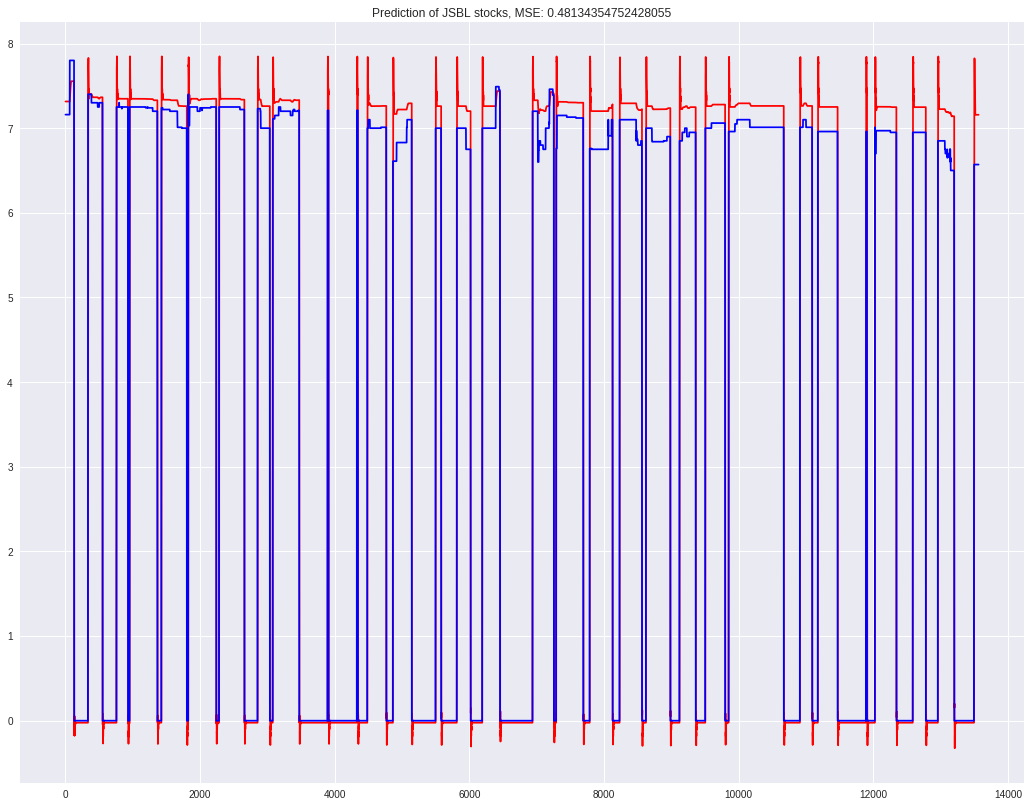

KAPCO
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 13s 322us/step - loss: 0.2360 - val_loss: 0.1502
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1125 - val_loss: 0.0814
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0873 - val_loss: 0.0741
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0805 - val_loss: 0.0662
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0747 - val_loss: 0.0571
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0690 - val_loss: 0.0476
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0634 - val_loss: 0.0325
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0582 - val_loss: 0.0222
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0543 - val_loss: 0.03

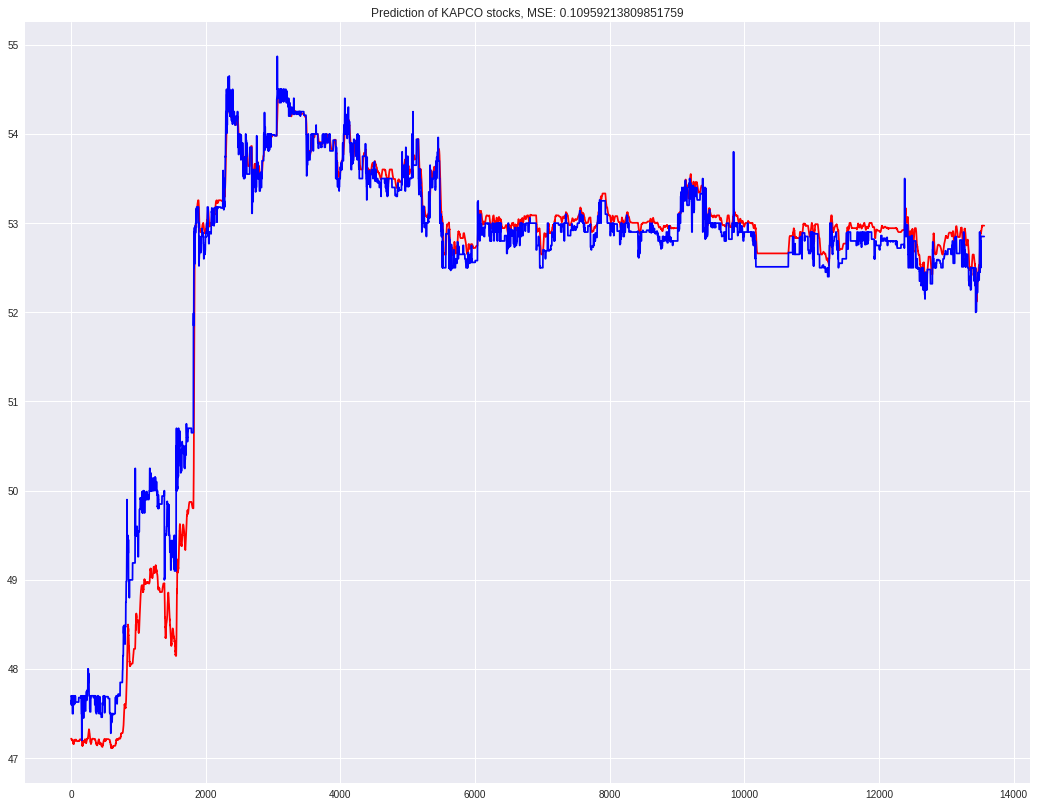

KEL
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 13s 327us/step - loss: 0.1316 - val_loss: 0.2776
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0680 - val_loss: 0.1230
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0484 - val_loss: 0.0902
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0431 - val_loss: 0.0679
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0390 - val_loss: 0.0632
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0362 - val_loss: 0.0535
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0340 - val_loss: 0.0575
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0324 - val_loss: 0.0538
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0309 - val_loss: 0.0481

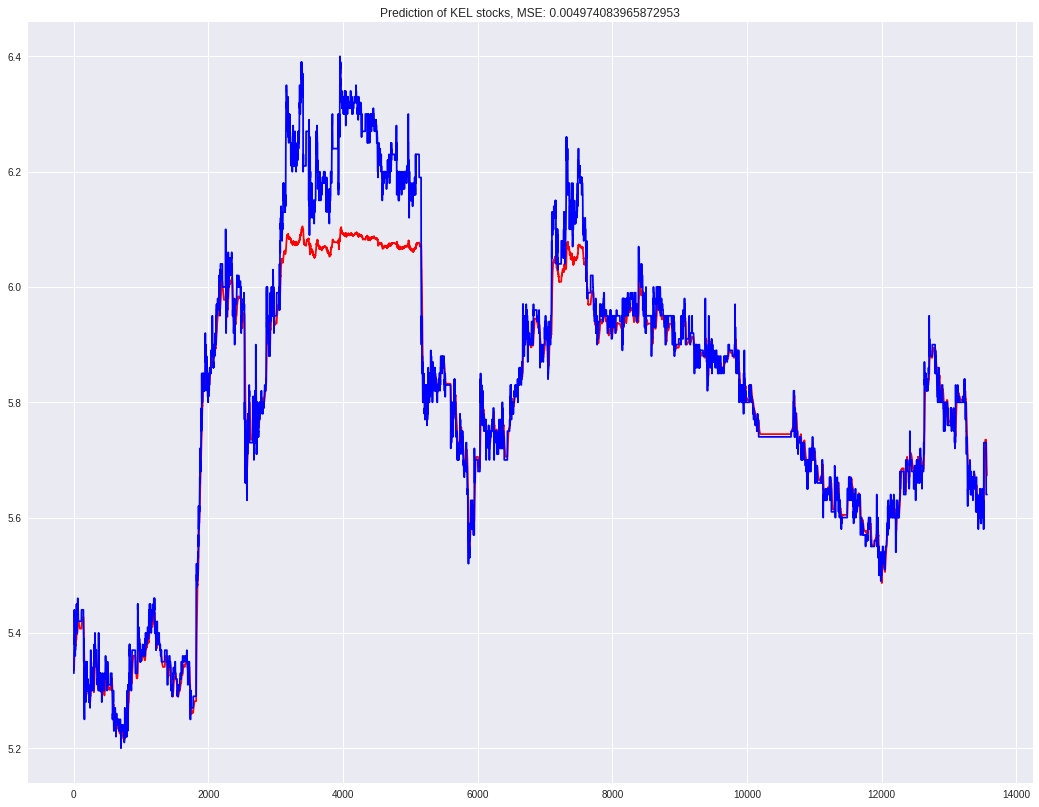

KOHC
Train on 40694 samples, validate on 13565 samples
Epoch 1/30
40694/40694 [==============================] - 14s 335us/step - loss: 0.1979 - val_loss: 0.3568
Epoch 2/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.1050 - val_loss: 0.2755
Epoch 3/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0842 - val_loss: 0.2182
Epoch 4/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0777 - val_loss: 0.1750
Epoch 5/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0752 - val_loss: 0.1511
Epoch 6/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0729 - val_loss: 0.1383
Epoch 7/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0690 - val_loss: 0.1226
Epoch 8/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0666 - val_loss: 0.1022
Epoch 9/30
40694/40694 [==============================] - 1s 20us/step - loss: 0.0634 - val_loss: 0.076

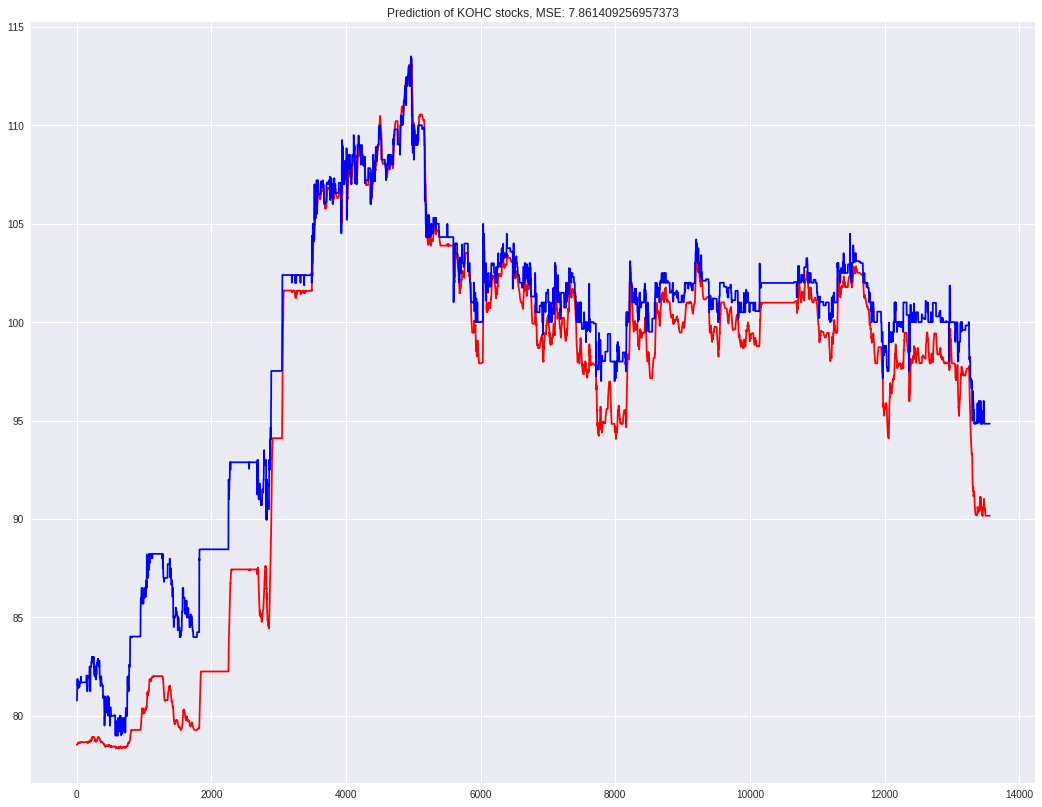

LUCK
Train on 40693 samples, validate on 13565 samples
Epoch 1/30
40693/40693 [==============================] - 14s 339us/step - loss: 0.2112 - val_loss: 0.0807
Epoch 2/30
40693/40693 [==============================] - 1s 21us/step - loss: 0.0796 - val_loss: 0.0603
Epoch 3/30
40693/40693 [==============================] - 1s 21us/step - loss: 0.0720 - val_loss: 0.0408
Epoch 4/30
40693/40693 [==============================] - 1s 21us/step - loss: 0.0601 - val_loss: 0.0212
Epoch 5/30
40693/40693 [==============================] - 1s 20us/step - loss: 0.0538 - val_loss: 0.0176
Epoch 6/30
40693/40693 [==============================] - 1s 20us/step - loss: 0.0484 - val_loss: 0.0182
Epoch 7/30
40693/40693 [==============================] - 1s 20us/step - loss: 0.0456 - val_loss: 0.0172
Epoch 8/30
40693/40693 [==============================] - 1s 20us/step - loss: 0.0445 - val_loss: 0.0186
Epoch 9/30
40693/40693 [==============================] - 1s 20us/step - loss: 0.0433 - val_loss: 0.018

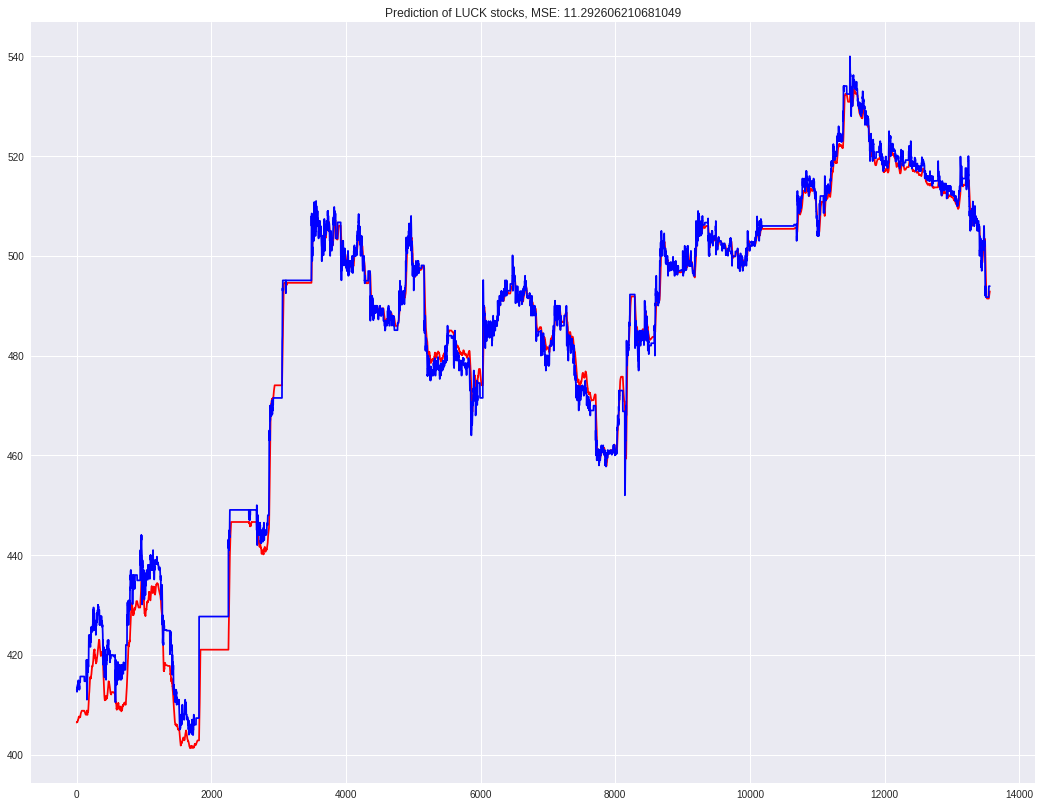

MARI
Train on 40693 samples, validate on 13565 samples
Epoch 1/30
40693/40693 [==============================] - 14s 347us/step - loss: 0.2099 - val_loss: 0.2731
Epoch 2/30
40693/40693 [==============================] - 1s 20us/step - loss: 0.0840 - val_loss: 0.1246
Epoch 3/30
40693/40693 [==============================] - 1s 20us/step - loss: 0.0578 - val_loss: 0.0872
Epoch 4/30
40693/40693 [==============================] - 1s 20us/step - loss: 0.0538 - val_loss: 0.0799
Epoch 5/30
40693/40693 [==============================] - 1s 21us/step - loss: 0.0496 - val_loss: 0.0741
Epoch 6/30
40693/40693 [==============================] - 1s 20us/step - loss: 0.0478 - val_loss: 0.0667
Epoch 7/30
40693/40693 [==============================] - 1s 20us/step - loss: 0.0469 - val_loss: 0.0650
Epoch 8/30
40693/40693 [==============================] - 1s 20us/step - loss: 0.0452 - val_loss: 0.0635
Epoch 9/30
40693/40693 [==============================] - 1s 20us/step - loss: 0.0445 - val_loss: 0.061

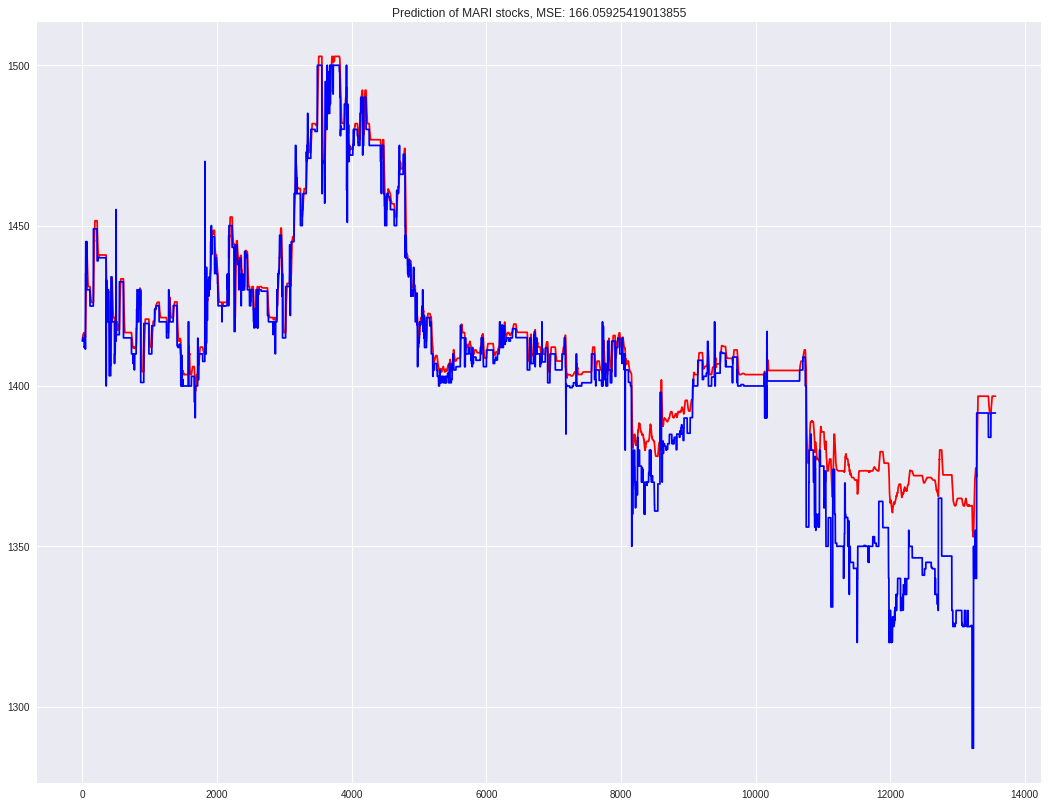

MCB
Train on 40692 samples, validate on 13565 samples
Epoch 1/30
40692/40692 [==============================] - 14s 353us/step - loss: 0.1559 - val_loss: 0.1450
Epoch 2/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0851 - val_loss: 0.1089
Epoch 3/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0673 - val_loss: 0.1040
Epoch 4/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0613 - val_loss: 0.0985
Epoch 5/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0574 - val_loss: 0.0915
Epoch 6/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0547 - val_loss: 0.0837
Epoch 7/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0516 - val_loss: 0.0744
Epoch 8/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0492 - val_loss: 0.0641
Epoch 9/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0462 - val_loss: 0.0537

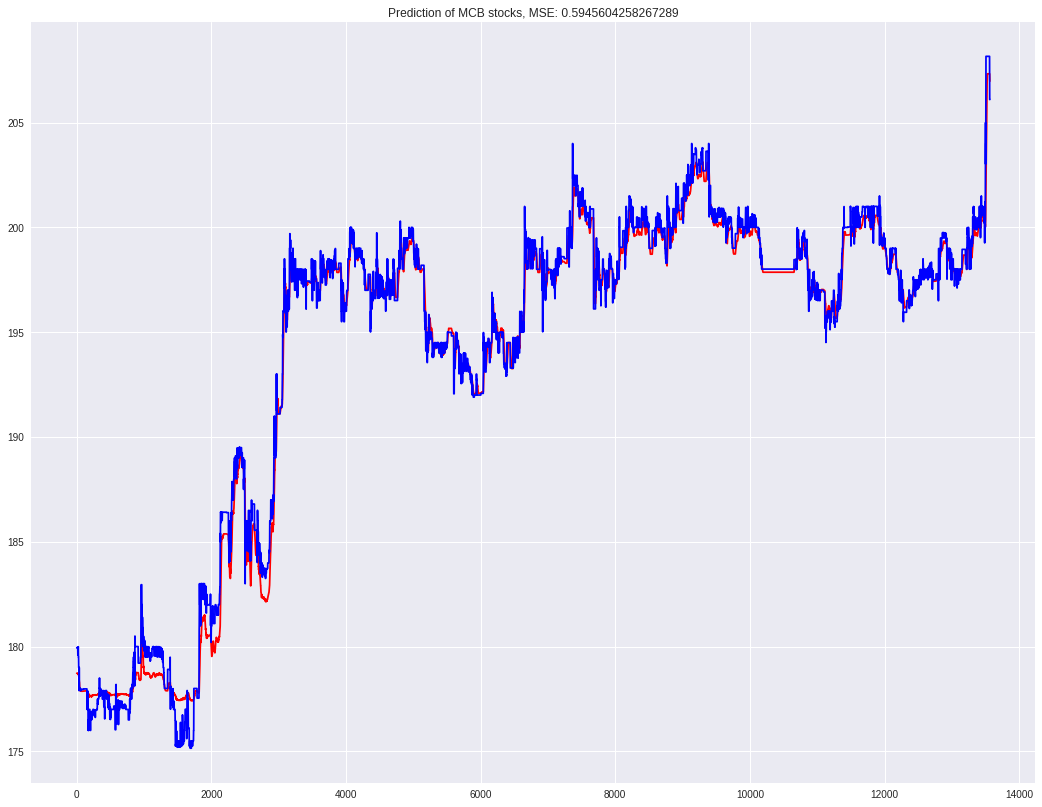

MTL
Train on 40692 samples, validate on 13565 samples
Epoch 1/30
40692/40692 [==============================] - 15s 365us/step - loss: 0.3676 - val_loss: 0.1146
Epoch 2/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.2204 - val_loss: 0.1057
Epoch 3/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.2000 - val_loss: 0.0933
Epoch 4/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1732 - val_loss: 0.0687
Epoch 5/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1427 - val_loss: 0.0589
Epoch 6/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1293 - val_loss: 0.0558
Epoch 7/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1202 - val_loss: 0.0549
Epoch 8/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1137 - val_loss: 0.0539
Epoch 9/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1077 - val_loss: 0.0511

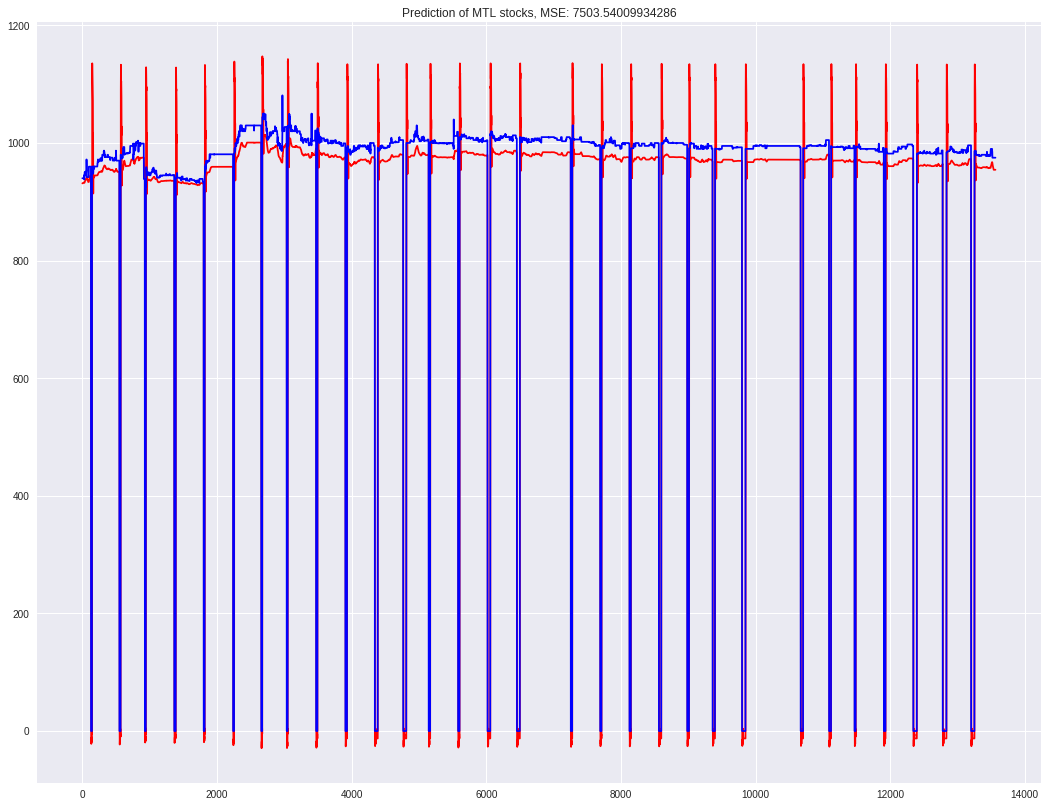

NBP
Train on 40692 samples, validate on 13565 samples
Epoch 1/30
40692/40692 [==============================] - 15s 369us/step - loss: 0.2362 - val_loss: 0.0444
Epoch 2/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0677 - val_loss: 0.0708
Epoch 3/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0674 - val_loss: 0.0442
Epoch 4/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0588 - val_loss: 0.0356
Epoch 5/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0516 - val_loss: 0.0321
Epoch 6/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0470 - val_loss: 0.0302
Epoch 7/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0435 - val_loss: 0.0289
Epoch 8/30
40692/40692 [==============================] - 1s 20us/step - loss: 0.0418 - val_loss: 0.0269
Epoch 9/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0405 - val_loss: 0.0268

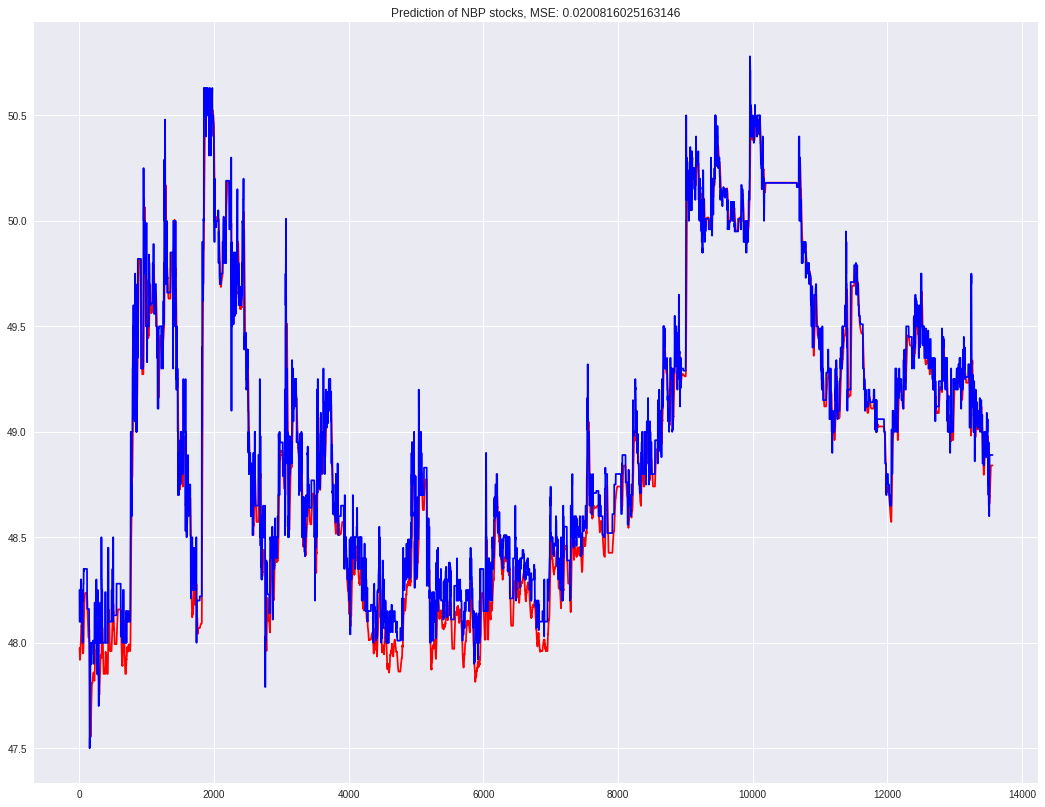

OGDC
Train on 40692 samples, validate on 13565 samples
Epoch 1/30
40692/40692 [==============================] - 15s 378us/step - loss: 0.2487 - val_loss: 0.2182
Epoch 2/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1233 - val_loss: 0.0541
Epoch 3/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0602 - val_loss: 0.0625
Epoch 4/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0455 - val_loss: 0.0446
Epoch 5/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0429 - val_loss: 0.0477
Epoch 6/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0394 - val_loss: 0.0416
Epoch 7/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0371 - val_loss: 0.0416
Epoch 8/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0353 - val_loss: 0.0396
Epoch 9/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0339 - val_loss: 0.037

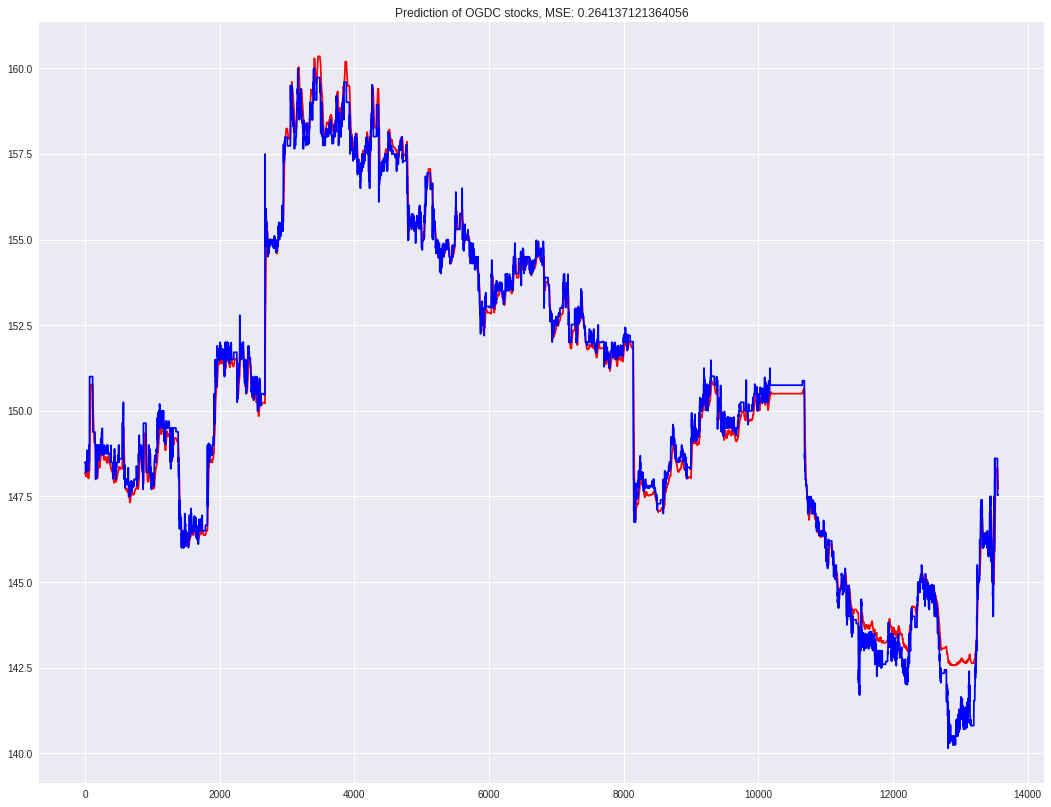

PAEL
Train on 40692 samples, validate on 13565 samples
Epoch 1/30
40692/40692 [==============================] - 16s 387us/step - loss: 0.3016 - val_loss: 0.2153
Epoch 2/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1456 - val_loss: 0.1326
Epoch 3/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1015 - val_loss: 0.1060
Epoch 4/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0888 - val_loss: 0.0876
Epoch 5/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0785 - val_loss: 0.0649
Epoch 6/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0668 - val_loss: 0.0412
Epoch 7/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0527 - val_loss: 0.0304
Epoch 8/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0497 - val_loss: 0.0182
Epoch 9/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0406 - val_loss: 0.019

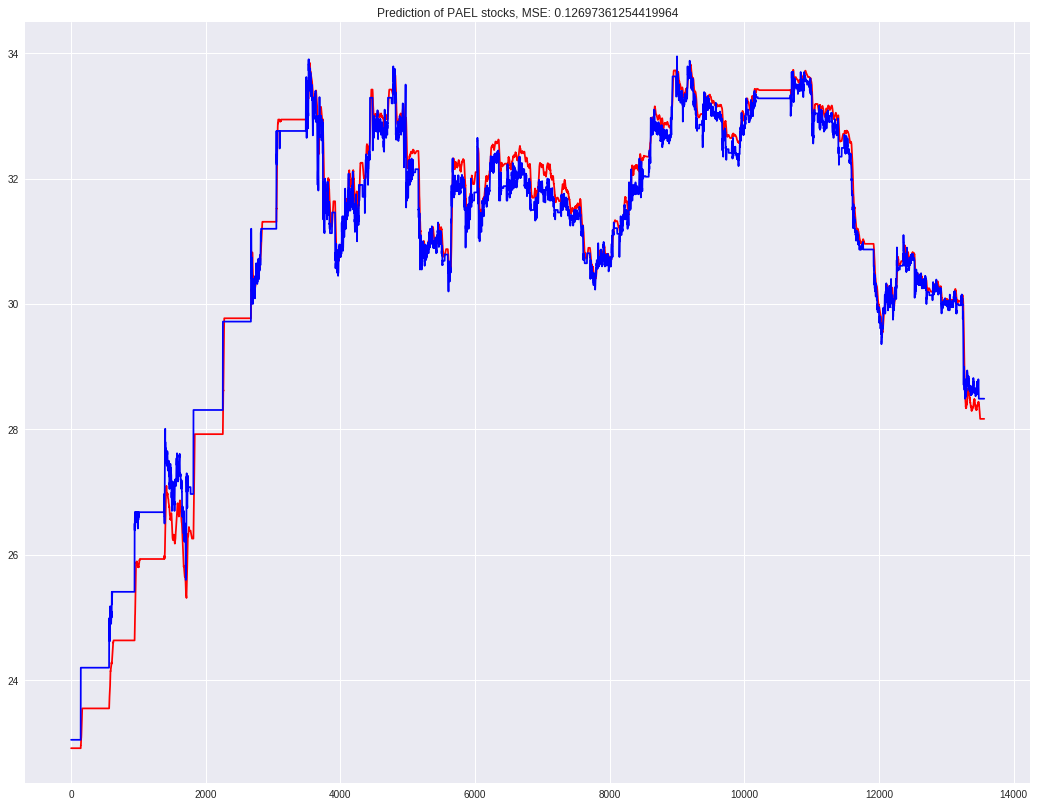

PASL
Train on 40692 samples, validate on 13565 samples
Epoch 1/30
40692/40692 [==============================] - 16s 389us/step - loss: 0.1665 - val_loss: 0.1224
Epoch 2/30
40692/40692 [==============================] - 1s 22us/step - loss: 0.1416 - val_loss: 0.1115
Epoch 3/30
40692/40692 [==============================] - 1s 22us/step - loss: 0.1247 - val_loss: 0.0687
Epoch 4/30
40692/40692 [==============================] - 1s 22us/step - loss: 0.0899 - val_loss: 0.0482
Epoch 5/30
40692/40692 [==============================] - 1s 22us/step - loss: 0.0779 - val_loss: 0.0407
Epoch 6/30
40692/40692 [==============================] - 1s 22us/step - loss: 0.0709 - val_loss: 0.0349
Epoch 7/30
40692/40692 [==============================] - 1s 22us/step - loss: 0.0668 - val_loss: 0.0331
Epoch 8/30
40692/40692 [==============================] - 1s 22us/step - loss: 0.0633 - val_loss: 0.0324
Epoch 9/30
40692/40692 [==============================] - 1s 22us/step - loss: 0.0616 - val_loss: 0.031

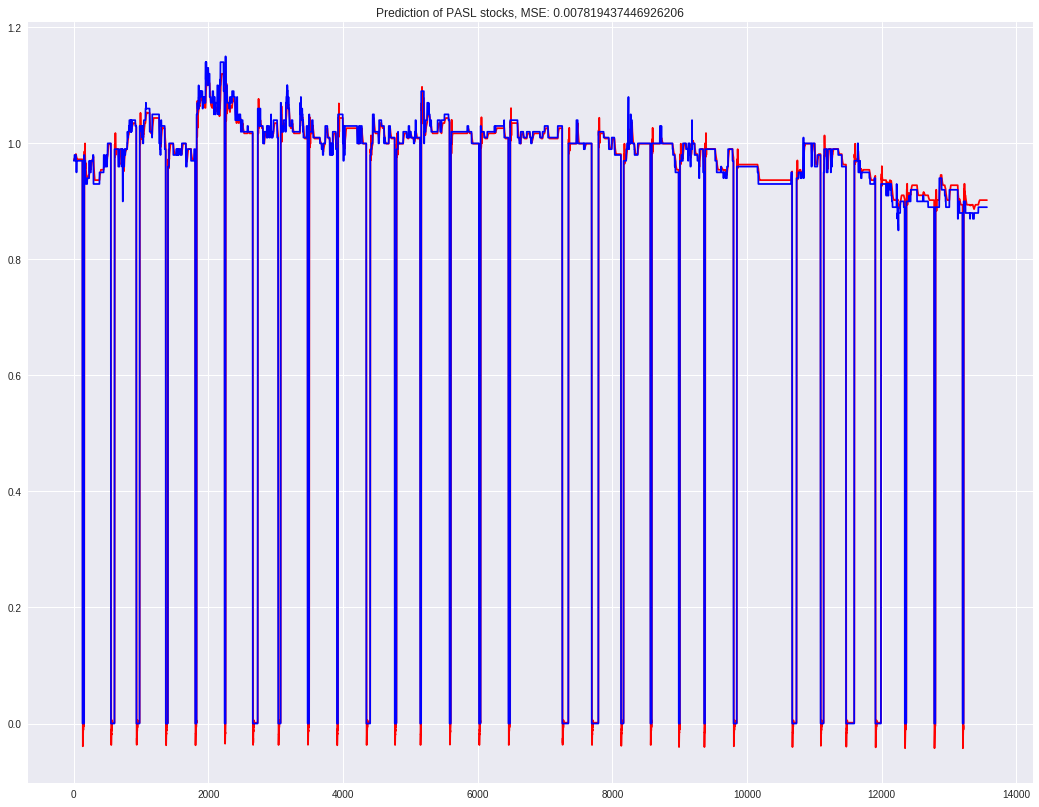

PIAA
Train on 40692 samples, validate on 13565 samples
Epoch 1/30
40692/40692 [==============================] - 16s 393us/step - loss: 0.5069 - val_loss: 0.0573
Epoch 2/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1759 - val_loss: 0.0630
Epoch 3/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1124 - val_loss: 0.0502
Epoch 4/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0966 - val_loss: 0.0446
Epoch 5/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0884 - val_loss: 0.0389
Epoch 6/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0831 - val_loss: 0.0335
Epoch 7/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0788 - val_loss: 0.0316
Epoch 8/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0762 - val_loss: 0.0315
Epoch 9/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0731 - val_loss: 0.030

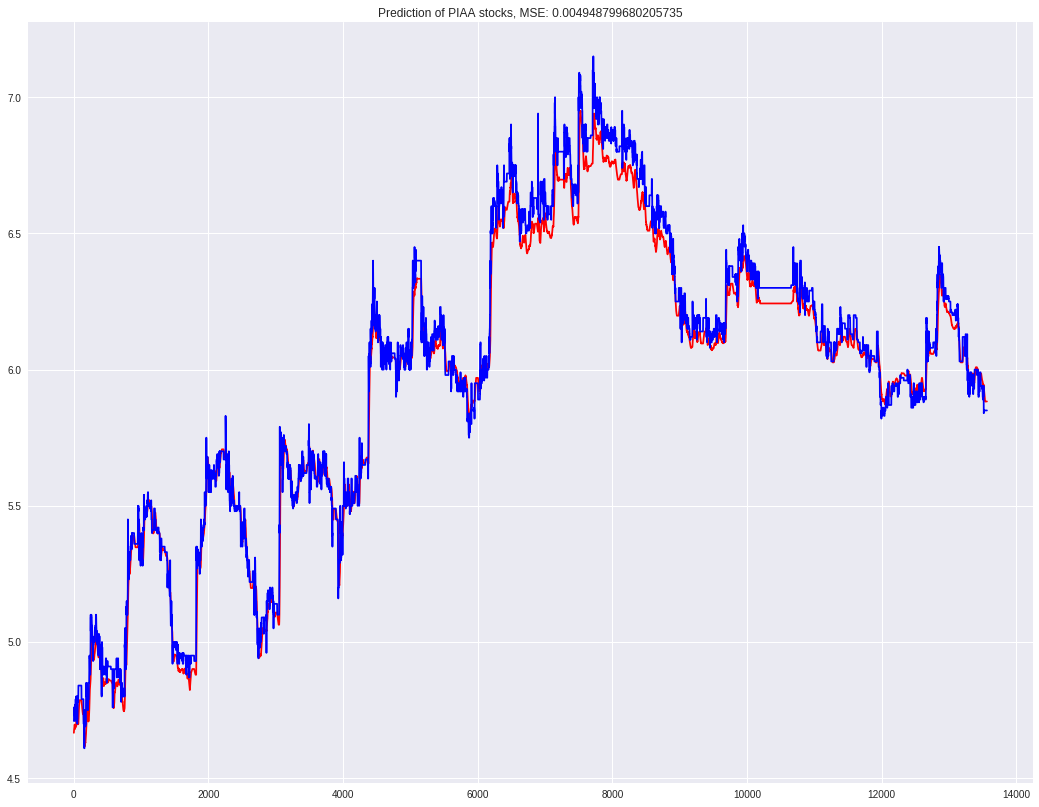

POL
Train on 40692 samples, validate on 13565 samples
Epoch 1/30
40692/40692 [==============================] - 16s 403us/step - loss: 0.4450 - val_loss: 0.4315
Epoch 2/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1215 - val_loss: 0.0824
Epoch 3/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0828 - val_loss: 0.1320
Epoch 4/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0725 - val_loss: 0.1108
Epoch 5/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0660 - val_loss: 0.0920
Epoch 6/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0618 - val_loss: 0.0831
Epoch 7/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0592 - val_loss: 0.0760
Epoch 8/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0571 - val_loss: 0.0773
Epoch 9/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0553 - val_loss: 0.0847

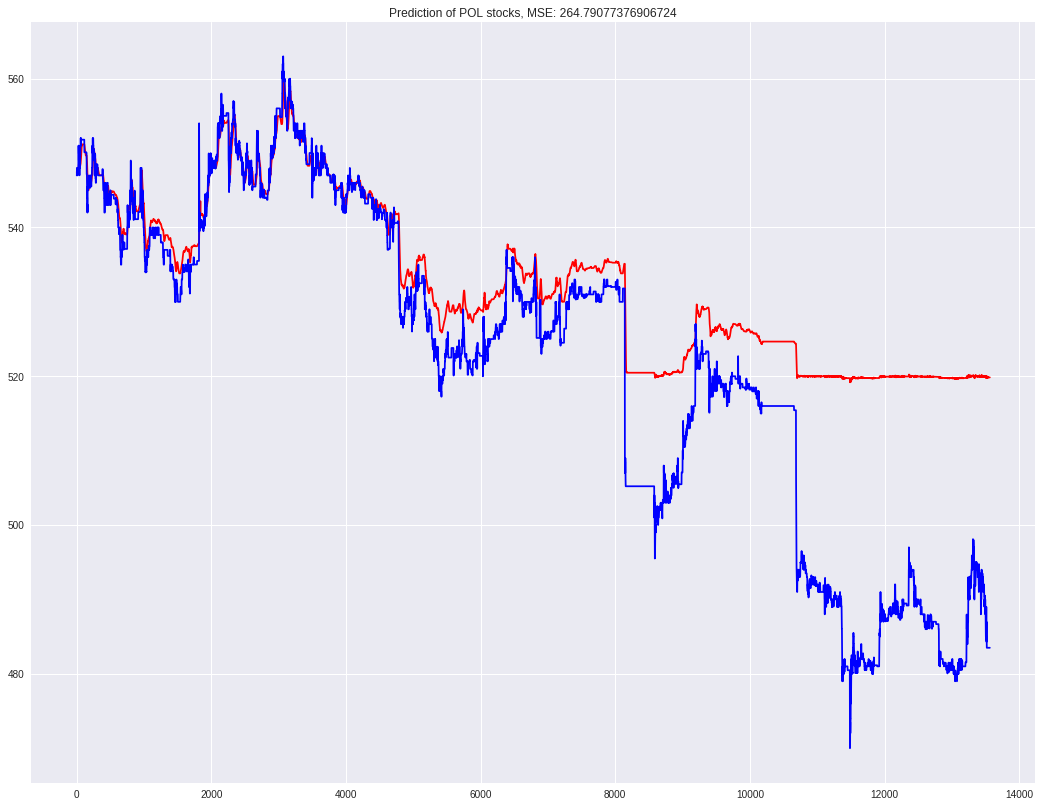

POWER
Train on 40692 samples, validate on 13565 samples
Epoch 1/30
40692/40692 [==============================] - 17s 408us/step - loss: 0.4028 - val_loss: 0.1371
Epoch 2/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1316 - val_loss: 0.1690
Epoch 3/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1256 - val_loss: 0.1540
Epoch 4/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1108 - val_loss: 0.1370
Epoch 5/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1014 - val_loss: 0.1308
Epoch 6/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0969 - val_loss: 0.1278
Epoch 7/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0940 - val_loss: 0.1202
Epoch 8/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0910 - val_loss: 0.1143
Epoch 9/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0872 - val_loss: 0.10

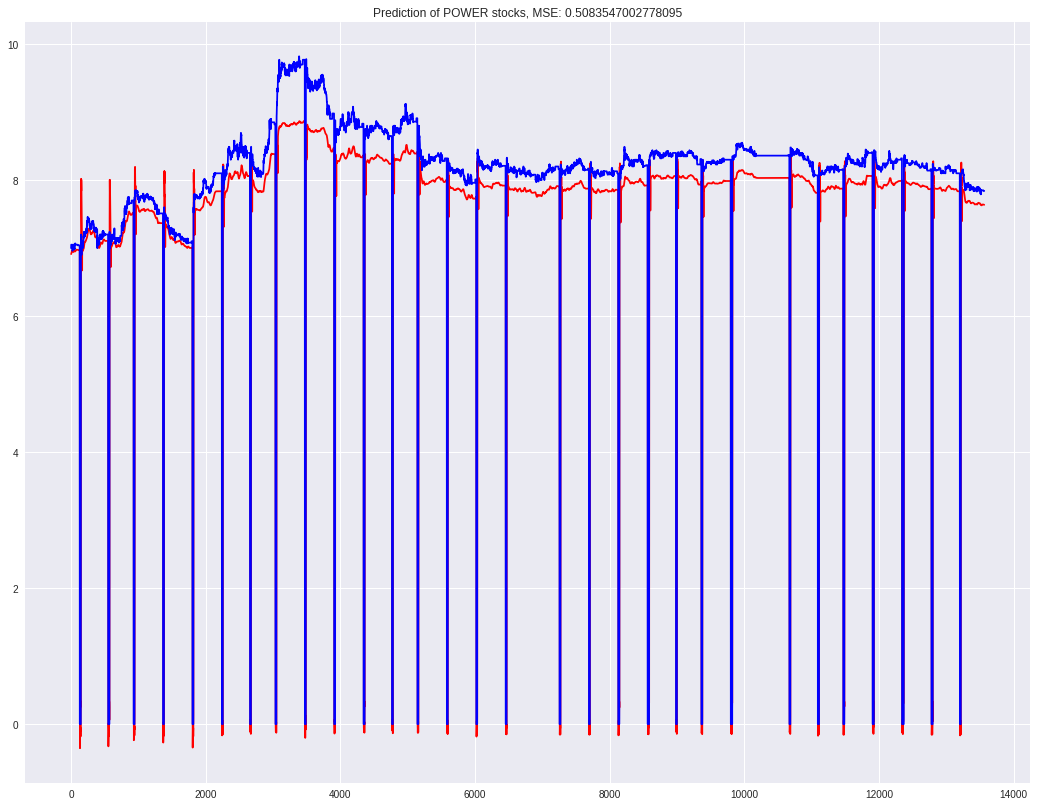

PPL
Train on 40692 samples, validate on 13565 samples
Epoch 1/30
40692/40692 [==============================] - 17s 415us/step - loss: 0.4300 - val_loss: 0.7888
Epoch 2/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1066 - val_loss: 0.7037
Epoch 3/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1011 - val_loss: 0.6396
Epoch 4/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0938 - val_loss: 0.5836
Epoch 5/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0863 - val_loss: 0.5286
Epoch 6/30
40692/40692 [==============================] - 1s 22us/step - loss: 0.0797 - val_loss: 0.4618
Epoch 7/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0726 - val_loss: 0.3753
Epoch 8/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0654 - val_loss: 0.2715
Epoch 9/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0583 - val_loss: 0.1585

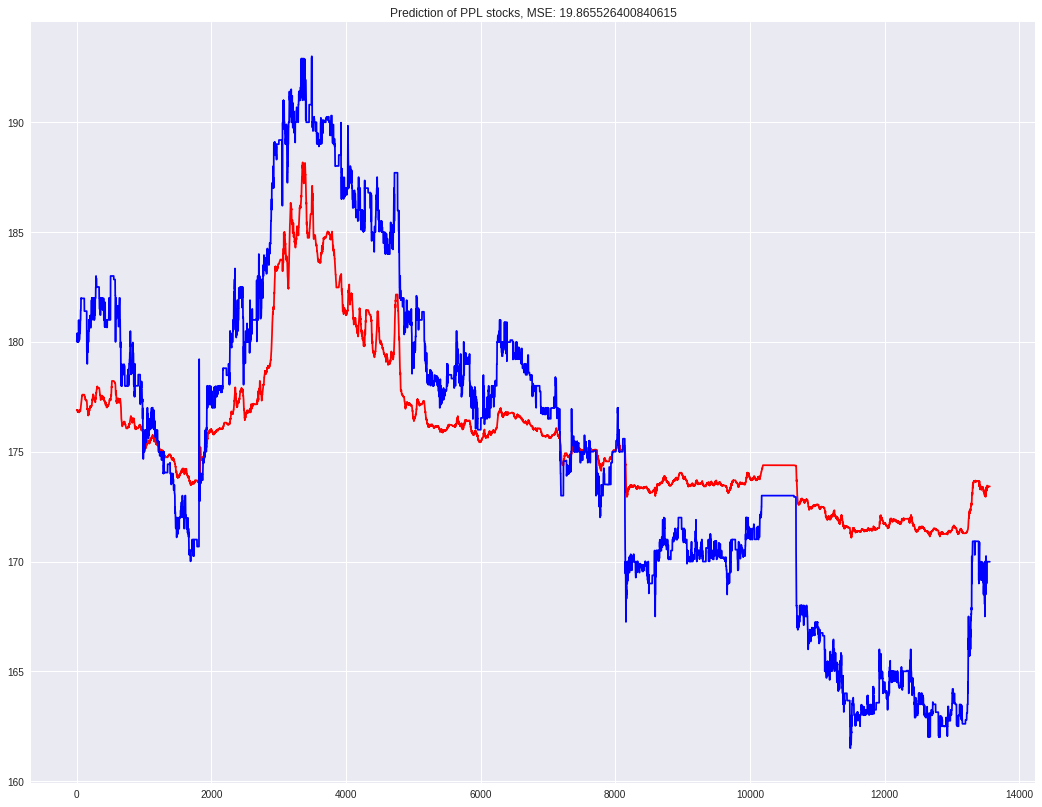

PSX
Train on 40692 samples, validate on 13564 samples
Epoch 1/30
40692/40692 [==============================] - 17s 423us/step - loss: 0.3258 - val_loss: 0.0949
Epoch 2/30
40692/40692 [==============================] - 1s 22us/step - loss: 0.1601 - val_loss: 0.0720
Epoch 3/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1264 - val_loss: 0.0532
Epoch 4/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1037 - val_loss: 0.0463
Epoch 5/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0898 - val_loss: 0.0468
Epoch 6/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0818 - val_loss: 0.0393
Epoch 7/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0746 - val_loss: 0.0371
Epoch 8/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0707 - val_loss: 0.0346
Epoch 9/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0667 - val_loss: 0.0333

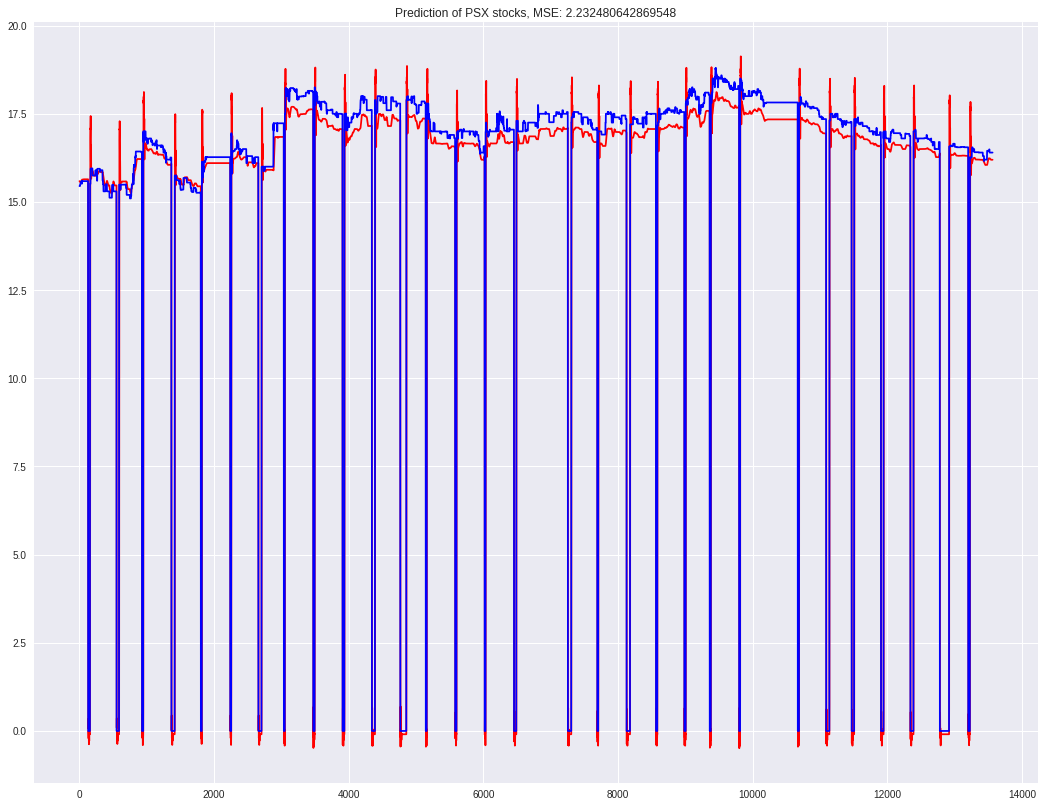

SEARL
Train on 40692 samples, validate on 13565 samples
Epoch 1/30
40692/40692 [==============================] - 18s 435us/step - loss: 0.5321 - val_loss: 0.1824
Epoch 2/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1423 - val_loss: 0.1161
Epoch 3/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1399 - val_loss: 0.0958
Epoch 4/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1159 - val_loss: 0.0773
Epoch 5/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1039 - val_loss: 0.0716
Epoch 6/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0999 - val_loss: 0.0664
Epoch 7/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0953 - val_loss: 0.0623
Epoch 8/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0926 - val_loss: 0.0592
Epoch 9/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0913 - val_loss: 0.05

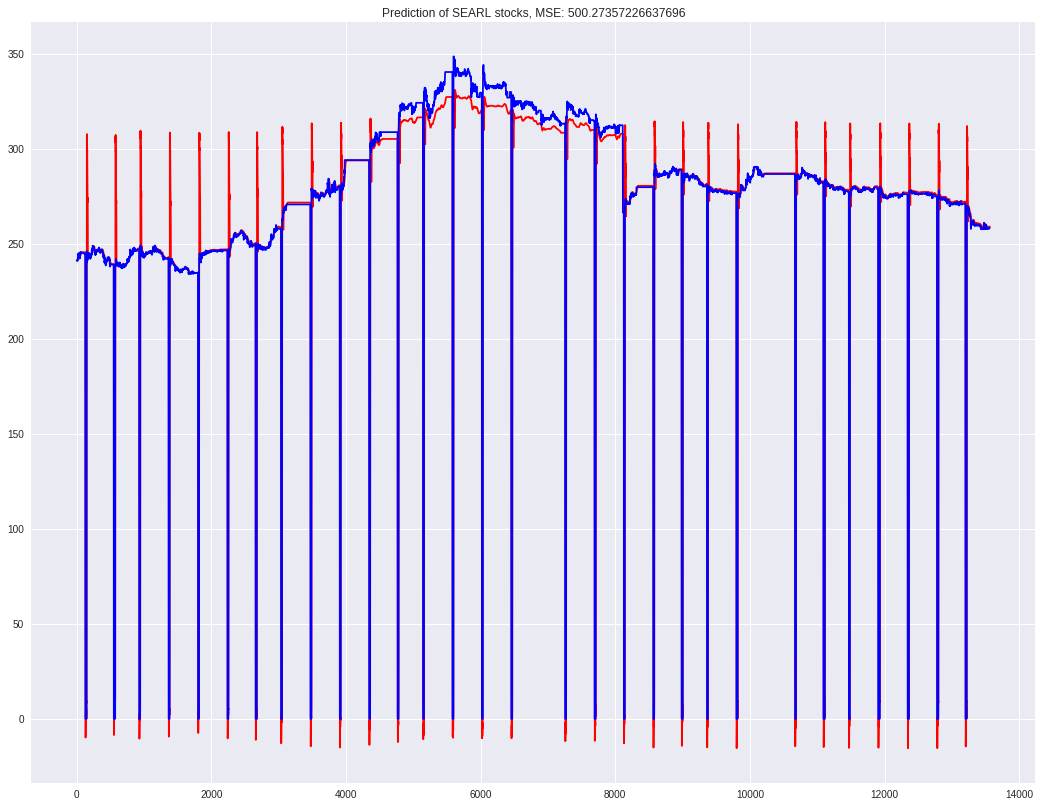

SNGP
Train on 40695 samples, validate on 13565 samples
Epoch 1/30
40695/40695 [==============================] - 18s 443us/step - loss: 0.2885 - val_loss: 0.1234
Epoch 2/30
40695/40695 [==============================] - 1s 22us/step - loss: 0.0877 - val_loss: 0.0338
Epoch 3/30
40695/40695 [==============================] - 1s 22us/step - loss: 0.0756 - val_loss: 0.0242
Epoch 4/30
40695/40695 [==============================] - 1s 22us/step - loss: 0.0611 - val_loss: 0.0216
Epoch 5/30
40695/40695 [==============================] - 1s 21us/step - loss: 0.0490 - val_loss: 0.0218
Epoch 6/30
40695/40695 [==============================] - 1s 21us/step - loss: 0.0448 - val_loss: 0.0212
Epoch 7/30
40695/40695 [==============================] - 1s 22us/step - loss: 0.0429 - val_loss: 0.0203
Epoch 8/30
40695/40695 [==============================] - 1s 22us/step - loss: 0.0413 - val_loss: 0.0222
Epoch 9/30
40695/40695 [==============================] - 1s 22us/step - loss: 0.0412 - val_loss: 0.021

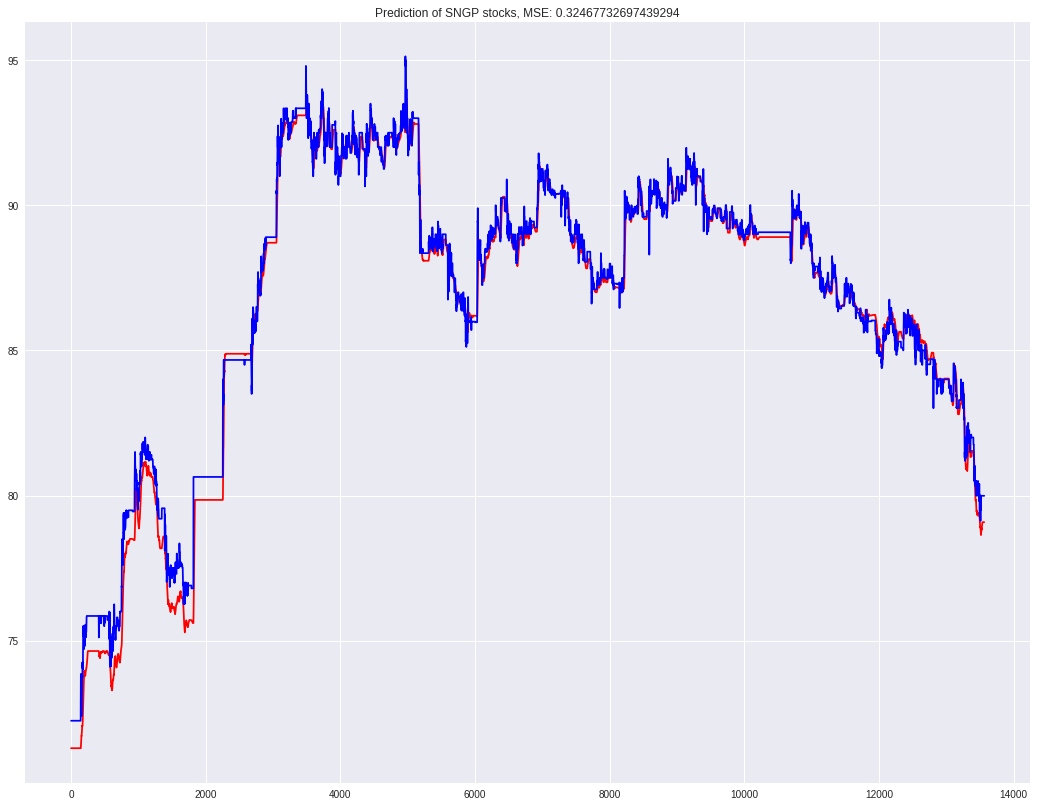

SSGC
Train on 40692 samples, validate on 13565 samples
Epoch 1/30
40692/40692 [==============================] - 18s 448us/step - loss: 0.3051 - val_loss: 0.3978
Epoch 2/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.1575 - val_loss: 0.1804
Epoch 3/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0961 - val_loss: 0.0453
Epoch 4/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0607 - val_loss: 0.0352
Epoch 5/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0537 - val_loss: 0.0168
Epoch 6/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0442 - val_loss: 0.0242
Epoch 7/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0409 - val_loss: 0.0141
Epoch 8/30
40692/40692 [==============================] - 1s 22us/step - loss: 0.0411 - val_loss: 0.0158
Epoch 9/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0387 - val_loss: 0.013

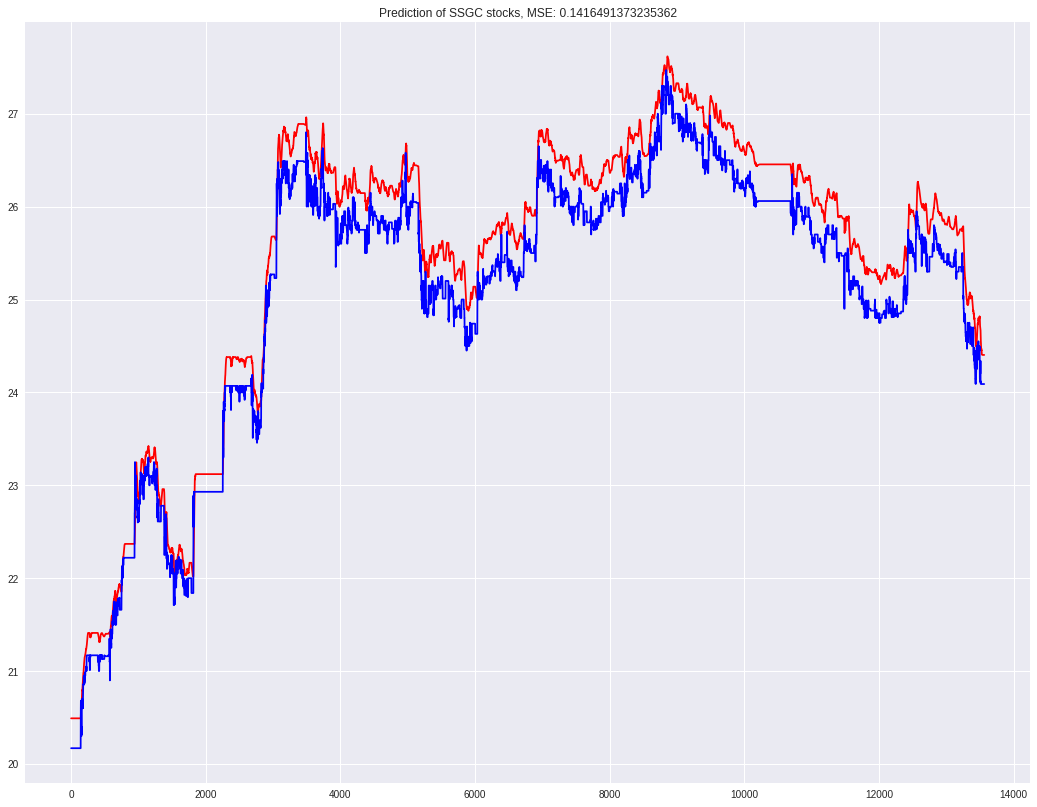

UBL
Train on 40692 samples, validate on 13565 samples
Epoch 1/30
40692/40692 [==============================] - 19s 455us/step - loss: 0.2651 - val_loss: 0.1188
Epoch 2/30
40692/40692 [==============================] - 1s 22us/step - loss: 0.1413 - val_loss: 0.0886
Epoch 3/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0673 - val_loss: 0.0288
Epoch 4/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0594 - val_loss: 0.0319
Epoch 5/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0503 - val_loss: 0.0304
Epoch 6/30
40692/40692 [==============================] - 1s 21us/step - loss: 0.0458 - val_loss: 0.0315
Epoch 7/30
40692/40692 [==============================] - 1s 22us/step - loss: 0.0431 - val_loss: 0.0303
Epoch 8/30
40692/40692 [==============================] - 1s 22us/step - loss: 0.0408 - val_loss: 0.0340
Epoch 9/30
40692/40692 [==============================] - 1s 22us/step - loss: 0.0394 - val_loss: 0.0340

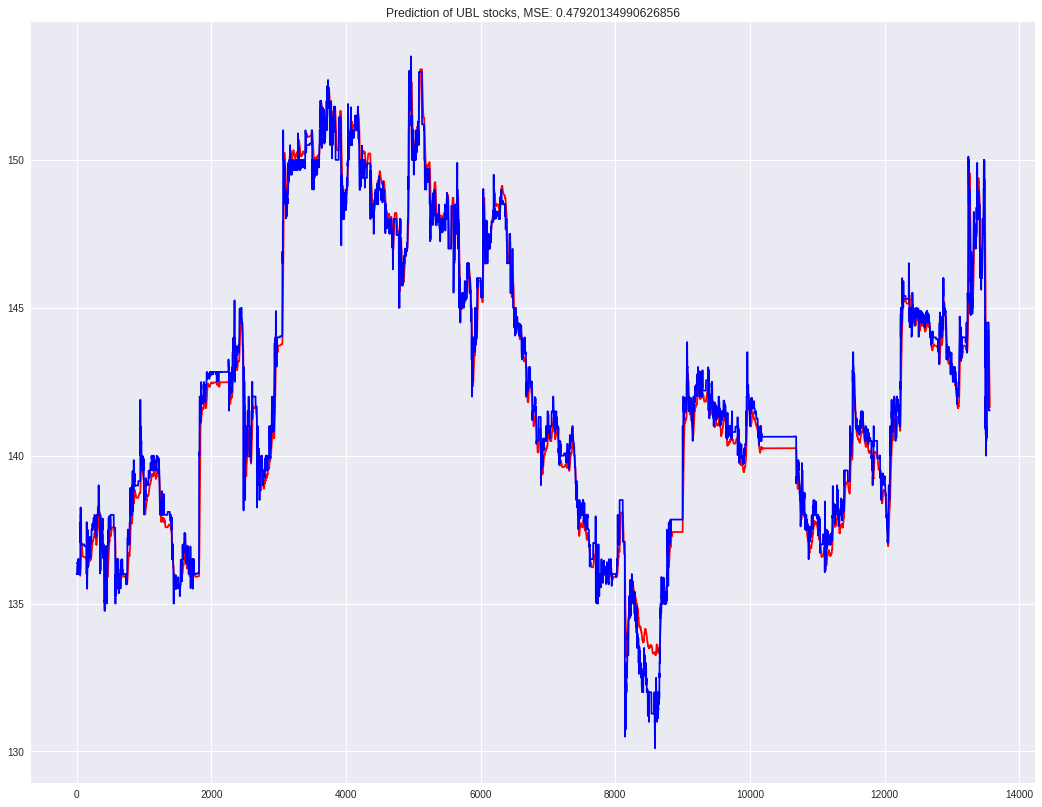

In [0]:
histories = []
for k, v in grouped_stock_data_dfs:
  print(k)
  stk_df = grouped_stock_data_dfs.get_group(k)
  proph_df = stk_df[['last_price']]
  proph_df.columns = ['y']
#   proph_df.head()
  reframed = series_to_supervised(proph_df, 'y', 20, 1)
  
  target_values = reframed['y(t)']
  target_values = np.array([target_values])
#   print("Target values before shapes: {}".format(target_values.shape))
  target_values = target_values.reshape(-1, 1)
  values = proph_df.values
#   print("Target values: {}, {}".format(target_values, len(target_values)))
  # In order to support inverted scaling for the predictions, we'll scale input matrix
  # and target vector with two different scalers.
#   print("Target values after shapes: {}".format(target_values.shape))
#   print("Target values: {}".format(target_values))
  scaler_target = MinMaxScaler(feature_range=(-1 ,1))
  scaled_target = scaler_target.fit_transform(target_values)
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaled = scaler.fit_transform(values)
#   print("Scaled: {}".format(scaled))
#   print("Scaled target: {}".format(scaled_target))
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 'y', 20, 1, True)
  # Drop columns which are not needed to be predicted
  # reframed.drop(columns=cols_to_drop, inplace=True)
  #     reframed.drop(columns=reframed.columns[1: 15], inplace=True)

  # split into train and test sets
  values = reframed.values
#   print(len(values))
  n_train_periods = int(len(values)*0.75)
  train = values[:n_train_periods, :]
  test = values[n_train_periods:, :]
#   print(len(train), len(test), n_train_periods)
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#   print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


  # design network
  model = Sequential()
  model.add(LSTM(8, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False, dropout=0.25))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')

  # filepath = k+'.accidents.best.weights.hdf5'
  # checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

  # fit network
  history = model.fit(train_X, train_y, epochs=30, batch_size=512, validation_data=(test_X, test_y), verbose=1, shuffle=False)
  histories.append(history)
  
  
  preds = model.predict(test_X)
  # print("Preds: {}".format(preds))
  offset_list = [0]*n_train_periods
  t = offset_list+list(preds.flatten())
  # print("t len: {}".format(len(t)))
  preds_inv = scaler_target.inverse_transform([offset_list+list(preds.flatten())])[0].reshape(-1, 1)
  actu_inv = scaler_target.inverse_transform([offset_list+list(test_y)])[0].reshape(-1, 1)
  preds_inv = np.array(preds_inv)[n_train_periods:]
  actu_inv = np.array(actu_inv)[n_train_periods:]
#   print(preds.flatten().shape, test_y.shape, preds_inv.shape, actu_inv.shape)
  # print("predsOnly: {}".format(preds_inv))
  preds_inv = preds_inv.flatten()
  actu_inv = actu_inv.flatten()
  preds = preds.flatten()
  scaled_target = scaled_target.flatten()
  
  
  plt.figure(figsize=(18, 14))
  plt.title("Prediction of {} stocks, MSE: {}".format(k, mean_squared_error(preds_inv, actu_inv)))
  plt.plot(preds_inv, 'r-')
  plt.plot(actu_inv, 'b-')
  plt.show()

In [0]:
hbl_df = grouped_stock_data_dfs.get_group('HBL')

In [0]:
stock_data_df.head(45)

id  symbol  last_price  change  change_percentage  bid_size      bid  \
0   1159171     HBL      170.51   -0.68              -0.40      1000   170.70   
1   1159172    AKBL       22.07    0.00               0.00      1500    21.52   
2   1159173    FABL       25.98    0.00               0.00      5000    25.60   
3   1159174    SNGP       96.70   -0.40              -0.41      1100    96.71   
4   1159175     ANL       13.01   -0.15              -1.14       500    13.02   
5   1159176    BAFL       52.71    0.00               0.00      1000    51.11   
6   1159177     BOP       12.06   -0.04              -0.33      4500    12.06   
7   1159178    BYCO       12.91    0.09               0.70       500    12.83   
8   1159179     DCL       18.60   -0.06              -0.32      2500    18.65   
9   1159180    DFML       31.50   -0.21              -0.66      1000    31.40   
10  1159181    DGKC      126.29   -0.17              -0.13       900   126.01   
11  1159182   ENGRO      303.88    0.96               0.32       400   302.50   
12  1159183   FDIBL        4.49   -0.01              -0.22      2000     4.48   
13  1159184   FEROZ      212.01    3.10               1.48       100   211.01   
14  1159185    FFBL       39.44    0.00               0.00      1500    39.00   
15  1159186    GHNL      192.50    5.29               2.83       300   191.00   
16  1159187  HASCOL        0.00    0.00               0.00       300   303.00   
17  1159188    HCAR      400.01    0.00               0.00        50   399.51   
18  1159189    HUBC       97.21    0.00               0.00      1000    98.50   
19  1159190    INDU        0.00    0.00               0.00       200  1572.00   
20  1159191     ISL      110.11   -1.47              -1.32       500   110.15   
21  1159192   KAPCO       58.52    0.00               0.00      1000    58.60   
22  1159193     KEL        5.95    0.01               0.17     23000     5.95   
23  1159194    KOHC      137.00    0.00               0.00       100   136.02   
24  1159195    LUCK      546.28    0.00               0.00       200   542.00   
25  1159196    MARI     1540.00    0.00               0.00       100  1500.11   
26  1159197     MCB      202.44   -1.75              -0.86       100   202.41   
27  1159198     MTL        0.00    0.00               0.00       100  1220.01   
28  1159199     NBP       49.54    0.00               0.00      2000    49.00   
29  1159200    OGDC      160.06    0.37               0.23       500   160.06   
30  1159201    PAEL       38.21   -0.29              -0.75     10000    38.15   
31  1159202    PASL        1.05    0.03               2.94     16000     0.98   
32  1159203    PIAA        4.55    0.00               0.00      2000     4.51   
33  1159204     POL      678.72    0.00               0.00       100   674.70   
34  1159205   POWER        0.00    0.00               0.00     25000     8.83   
35  1159206     PPL      213.10   -1.30              -0.61       100   213.01   
36  1159207   SEARL      332.00    7.18               2.21      1100   331.50   
37  1159208    SSGC       34.75    0.00               0.00      1000    34.75   
38  1159209     UBL      168.01   -1.11              -0.66       200   168.51   
39  1159210    ATLH        0.00    0.00               0.00        50   601.10   
40  1159211    DAWH      120.97    0.00               0.00       500   120.00   
41  1159212    GHNI      721.26    0.00               0.00        50   720.00   
42  1159213    INIL      248.08    0.00               0.00       500   243.00   
43  1159214    JSBL        0.00    0.00               0.00     10000     7.52   
44  1159215     PSX        0.00    0.00               0.00       500    26.53   

      offer  offer_size  turnover    high     low     open  last_volume  \
0    171.00         400     58800  171.90  165.00   171.19          100   
1     22.60        1000         0    0.00    0.00    22.07            0   
2     26.23        2500         0    0.00    0.00    25.9

In [0]:
df12 = pd.DataFrame(
    {
        'a': [1, 2, 3, 4],
        'b': [2, 3, 4, 5]
    }
)

In [0]:
df12.append(pd.DataFrame(
    {
        'a': [np.nan]*100,
        'b': [np.nan]*100
    }
))

a    b
0   1.0  2.0
1   2.0  3.0
2   3.0  4.0
3   4.0  5.0
0   NaN  NaN
1   NaN  NaN
2   NaN  NaN
3   NaN  NaN
4   NaN  NaN
5   NaN  NaN
6   NaN  NaN
7   NaN  NaN
8   NaN  NaN
9   NaN  NaN
10  NaN  NaN
11  NaN  NaN
12  NaN  NaN
13  NaN  NaN
14  NaN  NaN
15  NaN  NaN
16  NaN  NaN
17  NaN  NaN
18  NaN  NaN
19  NaN  NaN
20  NaN  NaN
21  NaN  NaN
22  NaN  NaN
23  NaN  NaN
24  NaN  NaN
25  NaN  NaN
..  ...  ...
70  NaN  NaN
71  NaN  NaN
72  NaN  NaN
73  NaN  NaN
74  NaN  NaN
75  NaN  NaN
76  NaN  NaN
77  NaN  NaN
78  NaN  NaN
79  NaN  NaN
80  NaN  NaN
81  NaN  NaN
82  NaN  NaN
83  NaN  NaN
84  NaN  NaN
85  NaN  NaN
86  NaN  NaN
87  NaN  NaN
88  NaN  NaN
89  NaN  NaN
90  NaN  NaN
91  NaN  NaN
92  NaN  NaN
93  NaN  NaN
94  NaN  NaN
95  NaN  NaN
96  NaN  NaN
97  NaN  NaN
98  NaN  NaN
99  NaN  NaN

[104 rows x 2 columns]

In [0]:
stock_data_df.tail()

id symbol  last_price  change  change_percentage  bid_size  bid  \
2442510  3603027   DAWH      126.00   -1.20              -0.94         0  0.0   
2442511  3603028   GHNI      295.44  -15.53              -4.99         0  0.0   
2442512  3603029   INIL      159.50   -5.99              -3.62         0  0.0   
2442513  3603030   JSBL        6.57   -0.02              -0.30         0  0.0   
2442514  3603031    PSX       16.40   -0.15              -0.91         0  0.0   

         offer  offer_size  turnover    high     low    open  last_volume  \
2442510    0.0           0    359200  128.00  126.00  127.20          100   
2442511    0.0           0     91200  311.99  295.43  310.97          150   
2442512    0.0           0     10600  161.00  158.00  165.49          100   
2442513    0.0           0      6000    6.57    6.57    6.59         1000   
2442514    0.0           0     72000   16.55   16.16   16.55         7000   

         total_trades last_trade            timestamp  
2442510            55   16:07:40  2018-11-30 17:30:25  
2442511           525   16:29:33  2018-11-30 17:30:25  
2442512            29   16:05:16  2018-11-30 17:30:25  
2442513             2   16:20:59  2018-11-30 17:30:25  
2442514            39   16:29:52  2018-11-30 17:30:25

In [0]:
hbl_df.head(10)

id symbol  last_price  change  change_percentage  bid_size     bid  \
0    1159171    HBL      170.51   -0.68              -0.40      1000  170.70   
45   1159216    HBL      171.00   -0.19              -0.11      1000  170.70   
90   1159261    HBL      170.60   -0.59              -0.34       200  170.50   
135  1159306    HBL      170.15   -0.94              -0.55      3500  170.15   
180  1159351    HBL      170.00   -1.19              -0.70      1000  170.00   
225  1159396    HBL      170.00   -1.19              -0.70       500  169.61   
270  1159441    HBL      168.00   -3.19              -1.86      1000  167.30   
315  1159486    HBL      168.25   -2.94              -1.72       500  168.25   
360  1159531    HBL      167.01   -4.18              -2.44      1100  167.00   
405  1159576    HBL      168.00   -3.19              -1.86       400  168.00   

      offer  offer_size  turnover   high    low    open  last_volume  \
0    171.00         400     58800  171.9  165.0  171.19          100   
45   170.98         500     60200  171.9  165.0  171.19          500   
90   170.60        2600     73100  171.9  165.0  171.19          400   
135  170.48         100     77800  171.9  165.0  171.19         1500   
180  170.48         100     89500  171.9  165.0  171.19          500   
225  170.00        8000     94000  171.9  165.0  171.19         1000   
270  168.00        4400    127600  171.9  165.0  171.19          600   
315  168.50        2000    144600  171.9  165.0  171.19         2000   
360  167.01         400    179200  171.9  165.0  171.19          500   
405  168.45        2000    189500  171.9  165.0  171.19          100   

     total_trades last_trade            timestamp  
0              63   09:00:11  2018-06-01 09:00:54  
45             66   09:01:00  2018-06-01 09:01:25  
90             79   09:02:19  2018-06-01 09:02:28  
135            87   09:03:16  2018-06-01 09:03:25  
180            95   09:03:59  2018-06-01 09:04:26  
225            98   09:05:17  2018-06-01 09:05:27  
270           133   09:06:25  2018-06-01 09:06:28  
315           153   09:07:27  2018-06-01 09:07:28  
360           207   09:08:25  2018-06-01 09:08:27  
405           225   09:09:21  2018-06-01 09:09:27

In [0]:
hbl_df.tail(10)

id symbol  last_price  change  change_percentage  bid_size  \
2442065  3602582    HBL      139.86   -2.75              -1.93     78100   
2442110  3602627    HBL      139.86   -2.75              -1.93     78100   
2442155  3602672    HBL      139.86   -2.75              -1.93     78100   
2442200  3602717    HBL      139.86   -2.75              -1.93     78100   
2442245  3602762    HBL      139.86   -2.75              -1.93     12700   
2442290  3602807    HBL      139.86   -2.75              -1.93     22700   
2442335  3602852    HBL      139.86   -2.75              -1.93     22700   
2442380  3602897    HBL      139.86   -2.75              -1.93     22700   
2442425  3602942    HBL      139.86   -2.75              -1.93     22700   
2442470  3602987    HBL      139.86   -2.75              -1.93     22700   

            bid  offer  offer_size  turnover   high     low    open  \
2442065  139.86    0.0           0   7486500  146.0  136.99  142.61   
2442110  139.86    0.0           0   7486500  146.0  136.99  142.61   
2442155  139.86    0.0           0   7486500  146.0  136.99  142.61   
2442200  139.86    0.0           0   7486500  146.0  136.99  142.61   
2442245  139.86    0.0           0   7556700  146.0  136.99  142.61   
2442290  139.86    0.0           0   7556700  146.0  136.99  142.61   
2442335  139.86    0.0           0   7556700  146.0  136.99  142.61   
2442380  139.86    0.0           0   7556700  146.0  136.99  142.61   
2442425  139.86    0.0           0   7556700  146.0  136.99  142.61   
2442470  139.86    0.0           0   7556700  146.0  136.99  142.61   

         last_volume  total_trades last_trade            timestamp  
2442065          500          3701   17:01:01  2018-11-30 17:07:27  
2442110          500          3701   17:01:01  2018-11-30 17:08:24  
2442155          500          3701   17:01:01  2018-11-30 17:09:24  
2442200          500          3701   17:01:01  2018-11-30 17:10:24  
2442245        15900          3704   17:11:01  2018-11-30 17:11:24  
2442290        15900          3704   17:11:01  2018-11-30 17:12:24  
2442335        15900          3704   17:11:01  2018-11-30 17:13:24  
2442380        15900          3704   17:11:01  2018-11-30 17:14:24  
2442425        15900          3704   17:11:01  2018-11-30 17:15:25  
2442470        15900          3704   17:11:01  2018-11-30 17:30:24

In [0]:
print(len(hbl_df))
hbl_train, hbl_test = train_test_split(hbl_df, shuffle=False, train_size=0.5)
print(len(hbl_train), len(hbl_test))

54282
27141 27141


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [0]:
hbl_train.tail(10)

id symbol  last_price  change  change_percentage  bid_size  \
1220770  2381287    HBL      150.55   -0.48              -0.32       400   
1220815  2381332    HBL      150.54   -0.49              -0.32      1000   
1220860  2381377    HBL      150.54   -0.49              -0.32      1000   
1220905  2381422    HBL      150.54   -0.49              -0.32      1000   
1220950  2381467    HBL      150.54   -0.49              -0.32      1000   
1220995  2381512    HBL      150.54   -0.49              -0.32      1000   
1221040  2381557    HBL      150.54   -0.49              -0.32      1000   
1221085  2381602    HBL      150.54   -0.49              -0.32      1000   
1221130  2381647    HBL      150.95   -0.08              -0.05      1000   
1221175  2381692    HBL      150.95   -0.08              -0.05      1000   

           bid   offer  offer_size  turnover   high     low    open  \
1220770  150.7  150.95         800    242200  151.5  150.51  151.03   
1220815  150.6  150.95         800    244900  151.5  150.51  151.03   
1220860  150.6  150.95         800    244900  151.5  150.51  151.03   
1220905  150.6  150.95         800    244900  151.5  150.51  151.03   
1220950  150.6  150.95         800    244900  151.5  150.51  151.03   
1220995  150.6  150.95         800    244900  151.5  150.51  151.03   
1221040  150.6  150.95         800    244900  151.5  150.51  151.03   
1221085  150.6  150.95         800    244900  151.5  150.51  151.03   
1221130  150.6  150.95         700    245000  151.5  150.51  151.03   
1221175  150.6  150.95         700    245000  151.5  150.51  151.03   

         last_volume  total_trades last_trade            timestamp  
1220770          100           288   13:25:08  2018-09-03 13:36:25  
1220815          200           293   13:36:59  2018-09-03 13:37:25  
1220860          200           293   13:36:59  2018-09-03 13:38:25  
1220905          200           293   13:36:59  2018-09-03 13:39:25  
1220950          200           293   13:36:59  2018-09-03 13:40:25  
1220995          200           293   13:36:59  2018-09-03 13:41:25  
1221040          200           293   13:36:59  2018-09-03 13:42:25  
1221085          200           293   13:36:59  2018-09-03 13:43:28  
1221130          100           294   13:44:06  2018-09-03 13:44:25  
1221175          100           294   13:44:06  2018-09-03 13:45:26

In [0]:
hbl_test.head(10)

id symbol  last_price  change  change_percentage  bid_size  \
1221220  2381737    HBL      150.95   -0.08              -0.05      1000   
1221265  2381782    HBL      150.95   -0.08              -0.05      1000   
1221310  2381827    HBL      150.95   -0.08              -0.05      1000   
1221355  2381872    HBL      150.95   -0.08              -0.05      1000   
1221400  2381917    HBL      150.95   -0.08              -0.05      2000   
1221445  2381962    HBL      150.95   -0.08              -0.05      2000   
1221490  2382007    HBL      150.95   -0.08              -0.05      2000   
1221535  2382052    HBL      150.95   -0.08              -0.05      2100   
1221580  2382097    HBL      151.00   -0.03              -0.02      2100   
1221625  2382142    HBL      151.00   -0.03              -0.02       600   

           bid   offer  offer_size  turnover   high     low    open  \
1221220  150.6  150.95         700    245000  151.5  150.51  151.03   
1221265  150.6  150.95         700    245000  151.5  150.51  151.03   
1221310  150.6  150.95         700    245000  151.5  150.51  151.03   
1221355  150.6  150.95         700    245000  151.5  150.51  151.03   
1221400  150.6  150.95         700    245000  151.5  150.51  151.03   
1221445  150.6  150.95         700    245000  151.5  150.51  151.03   
1221490  150.7  150.95         700    245000  151.5  150.51  151.03   
1221535  150.7  150.95         700    245000  151.5  150.51  151.03   
1221580  150.7  151.00        3300    265000  151.5  150.51  151.03   
1221625  151.0  151.05         100    273400  151.5  150.51  151.03   

         last_volume  total_trades last_trade            timestamp  
1221220          100           294   13:44:06  2018-09-03 13:46:24  
1221265          100           294   13:44:06  2018-09-03 13:47:25  
1221310          100           294   13:44:06  2018-09-03 13:48:25  
1221355          100           294   13:44:06  2018-09-03 13:49:25  
1221400          100           294   13:44:06  2018-09-03 13:50:24  
1221445          100           294   13:44:06  2018-09-03 13:51:28  
1221490          100           294   13:44:06  2018-09-03 13:52:27  
1221535          100           294   13:44:06  2018-09-03 13:53:27  
1221580         1700           310   13:54:23  2018-09-03 13:54:24  
1221625          100           316   13:54:44  2018-09-03 13:55:27

In [0]:
proph_df = hbl_df[['last_price']]
proph_df.columns = ['y']
proph_df.head()

y
0    170.51
45   171.00
90   170.60
135  170.15
180  170.00

In [0]:
reframed = series_to_supervised(proph_df, 'y', 20, 1)

In [0]:
reframed

y(t-20)  y(t-19)  y(t-18)  y(t-17)  y(t-16)  y(t-15)  y(t-14)  \
900       170.51   171.00   170.60   170.15   170.00   170.00   168.00   
945       171.00   170.60   170.15   170.00   170.00   168.00   168.25   
990       170.60   170.15   170.00   170.00   168.00   168.25   167.01   
1035      170.15   170.00   170.00   168.00   168.25   167.01   168.00   
1080      170.00   170.00   168.00   168.25   167.01   168.00   167.75   
1125      170.00   168.00   168.25   167.01   168.00   167.75   167.00   
1170      168.00   168.25   167.01   168.00   167.75   167.00   168.40   
1215      168.25   167.01   168.00   167.75   167.00   168.40   169.00   
1260      167.01   168.00   167.75   167.00   168.40   169.00   169.00   
1305      168.00   167.75   167.00   168.40   169.00   169.00   169.40   
1350      167.75   167.00   168.40   169.00   169.00   169.40   169.00   
1395      167.00   168.40   169.00   169.00   169.40   169.00   168.50   
1440      168.40   169.00   169.00   169.40   169.00   168.50   168.50   
1485      169.00   169.00   169.40   169.00   168.50   168.50   168.50   
1530      169.00   169.40   169.00   168.50   168.50   168.50   169.00   
1575      169.40   169.00   168.50   168.50   168.50   169.00   169.00   
1620      169.00   168.50   168.50   168.50   169.00   169.00   169.40   
1665      168.50   168.50   168.50   169.00   169.00   169.40   169.60   
1710      168.50   168.50   169.00   169.00   169.40   169.60   170.50   
1755      168.50   169.00   169.00   169.40   169.60   170.50   170.00   
1800      169.00   169.00   169.40   169.60   170.50   170.00   169.95   
1845      169.00   169.40   169.60   170.50   170.00   169.95   169.95   
1890      169.40   169.60   170.50   170.00   169.95   169.95   169.95   
1935      169.60   170.50   170.00   169.95   169.95   169.95   170.00   
1980      170.50   170.00   169.95   169.95   169.95   170.00   170.00   
2025      170.00   169.95   169.95   169.95   170.00   170.00   170.00   
2070      169.95   169.95   169.95   170.00   170.00   170.00   169.70   
2115      169.95   169.95   170.00   170.00   170.00   169.70   169.70   
2160      169.95   170.00   170.00   170.00   169.70   169.70   169.70   
2205      170.00   170.00   170.00   169.70   169.70   169.70   170.00   
...          ...      ...      ...      ...      ...      ...      ...   
2441165   141.00   140.51   141.49   142.00   142.00   142.00   142.00   
2441210   140.51   141.49   142.00   142.00   142.00   142.00   142.00   
2441255   141.49   142.00   142.00   142.00   142.00   142.00   142.00   
2441300   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2441345   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2441390   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2441435   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2441480   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2441525   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2441570   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2441615   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2441660   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2441705   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2441750   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2441795   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2441840   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2441885   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2441930   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2441975   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2442020   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2442065   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2442110   142.00   142.00   142.00   142.00   142.00   142.00   142.00   
2442155   142

In [0]:
cols12 = reframed.columns
# reframed.append(pd.DataFrame(
#     {
#         cols12[0]: [np.nan]*27000,
#         cols12[1]: [np.nan]*27000,
#         cols12[2]: [np.nan]*27000,
#         cols12[3]: [np.nan]*27000,
#         cols12[4]: [np.nan]*27000,
#         cols12[5]: [np.nan]*27000,
#         cols12[6]: [np.nan]*27000,
#         cols12[7]: [np.nan]*27000,
#         cols12[8]: [np.nan]*27000,
#         cols12[9]: [np.nan]*27000,
#         cols12[10]: [np.nan]*27000,
#         cols12[11]: [np.nan]*27000,
#         cols12[12]: [np.nan]*27000,
#         cols12[13]: [np.nan]*27000,
#         cols12[14]: [np.nan]*27000,
#         cols12[15]: [np.nan]*27000,
#         cols12[16]: [np.nan]*27000,
#         cols12[17]: [np.nan]*27000,
#         cols12[18]: [np.nan]*27000,
#         cols12[19]: [np.nan]*27000,
#         cols12[20]: [np.nan]*27000,
#     }
# ))

In [0]:
reframed = reframed.append(pd.DataFrame(
    {
        cols12[0]: [np.nan]*27000,
        cols12[1]: [np.nan]*27000,
        cols12[2]: [np.nan]*27000,
        cols12[3]: [np.nan]*27000,
        cols12[4]: [np.nan]*27000,
        cols12[5]: [np.nan]*27000,
        cols12[6]: [np.nan]*27000,
        cols12[7]: [np.nan]*27000,
        cols12[8]: [np.nan]*27000,
        cols12[9]: [np.nan]*27000,
        cols12[10]: [np.nan]*27000,
        cols12[11]: [np.nan]*27000,
        cols12[12]: [np.nan]*27000,
        cols12[13]: [np.nan]*27000,
        cols12[14]: [np.nan]*27000,
        cols12[15]: [np.nan]*27000,
        cols12[16]: [np.nan]*27000,
        cols12[17]: [np.nan]*27000,
        cols12[18]: [np.nan]*27000,
        cols12[19]: [np.nan]*27000,
        cols12[20]: [np.nan]*27000,
    }
))

In [0]:
reframed.interpolate(method='linear', axis=0, inplace=True)

In [0]:
reframed

y(t-20)  y(t-19)  y(t-18)  y(t-17)  y(t-16)  y(t-15)  y(t-14)  y(t-13)  \
900     170.51   171.00   170.60   170.15   170.00   170.00   168.00   168.25   
945     171.00   170.60   170.15   170.00   170.00   168.00   168.25   167.01   
990     170.60   170.15   170.00   170.00   168.00   168.25   167.01   168.00   
1035    170.15   170.00   170.00   168.00   168.25   167.01   168.00   167.75   
1080    170.00   170.00   168.00   168.25   167.01   168.00   167.75   167.00   
1125    170.00   168.00   168.25   167.01   168.00   167.75   167.00   168.40   
1170    168.00   168.25   167.01   168.00   167.75   167.00   168.40   169.00   
1215    168.25   167.01   168.00   167.75   167.00   168.40   169.00   169.00   
1260    167.01   168.00   167.75   167.00   168.40   169.00   169.00   169.40   
1305    168.00   167.75   167.00   168.40   169.00   169.00   169.40   169.00   
1350    167.75   167.00   168.40   169.00   169.00   169.40   169.00   168.50   
1395    167.00   168.40   169.00   169.00   169.40   169.00   168.50   168.50   
1440    168.40   169.00   169.00   169.40   169.00   168.50   168.50   168.50   
1485    169.00   169.00   169.40   169.00   168.50   168.50   168.50   169.00   
1530    169.00   169.40   169.00   168.50   168.50   168.50   169.00   169.00   
1575    169.40   169.00   168.50   168.50   168.50   169.00   169.00   169.40   
1620    169.00   168.50   168.50   168.50   169.00   169.00   169.40   169.60   
1665    168.50   168.50   168.50   169.00   169.00   169.40   169.60   170.50   
1710    168.50   168.50   169.00   169.00   169.40   169.60   170.50   170.00   
1755    168.50   169.00   169.00   169.40   169.60   170.50   170.00   169.95   
1800    169.00   169.00   169.40   169.60   170.50   170.00   169.95   169.95   
1845    169.00   169.40   169.60   170.50   170.00   169.95   169.95   169.95   
1890    169.40   169.60   170.50   170.00   169.95   169.95   169.95   170.00   
1935    169.60   170.50   170.00   169.95   169.95   169.95   170.00   170.00   
1980    170.50   170.00   169.95   169.95   169.95   170.00   170.00   170.00   
2025    170.00   169.95   169.95   169.95   170.00   170.00   170.00   169.70   
2070    169.95   169.95   169.95   170.00   170.00   170.00   169.70   169.70   
2115    169.95   169.95   170.00   170.00   170.00   169.70   169.70   169.70   
2160    169.95   170.00   170.00   170.00   169.70   169.70   169.70   170.00   
2205    170.00   170.00   170.00   169.70   169.70   169.70   170.00   170.00   
...        ...      ...      ...      ...      ...      ...      ...      ...   
26970   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26971   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26972   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26973   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26974   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26975   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26976   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26977   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26978   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26979   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26980   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26981   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26982   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26983   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26984   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26985   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26986   142.00   142.00   142.00   142.00   142.00   139.86   139.86   139.86   
26987   142.00   142.00   142.00   142

In [0]:
target_values = reframed['y(t)']
target_values = np.array([target_values])
print("Target values before shapes: {}".format(target_values.shape))
target_values = target_values.reshape(-1, 1)
values = proph_df.values
print("Target values: {}, {}".format(target_values, len(target_values)))
# In order to support inverted scaling for the predictions, we'll scale input matrix
# and target vector with two different scalers.
print("Target values after shapes: {}".format(target_values.shape))
print("Target values: {}".format(target_values))
scaler_target = MinMaxScaler(feature_range=(-1 ,1))
scaled_target = scaler_target.fit_transform(target_values)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)
print("Scaled: {}".format(scaled))
print("Scaled target: {}".format(scaled_target))
# frame as supervised learning
reframed = series_to_supervised(scaled, 'y', 20, 1, True)
# Drop columns which are not needed to be predicted
# reframed.drop(columns=cols_to_drop, inplace=True)
#     reframed.drop(columns=reframed.columns[1: 15], inplace=True)

# split into train and test sets
values = reframed.values
print(len(values))
n_train_periods = int(len(values)*0.75)
train = values[:n_train_periods, :]
test = values[n_train_periods:, :]
print(len(train), len(test), n_train_periods)
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Target values before shapes: (1, 54256)
Target values: [[120.97]
 [120.97]
 [120.97]
 ...
 [126.  ]
 [126.  ]
 [126.  ]], 54256
Target values after shapes: (54256, 1)
Target values: [[120.97]
 [120.97]
 [120.97]
 ...
 [126.  ]
 [126.  ]
 [126.  ]]
Scaled: [[0.41947368]
 [0.41947368]
 [0.41947368]
 ...
 [0.68421053]
 [0.68421053]
 [0.68421053]]
Scaled target: [[0.41947368]
 [0.41947368]
 [0.41947368]
 ...
 [0.68421053]
 [0.68421053]
 [0.68421053]]
54256
40692 13564 40692
(40692, 1, 20) (40692,) (13564, 1, 20) (13564,)


In [0]:
# train_y

In [0]:
# design network
model = Sequential()
model.add(LSTM(8, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False, dropout=0.25))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# filepath = k+'.accidents.best.weights.hdf5'
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=512, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# histories.append(history)

Train on 40692 samples, validate on 13564 samples
Epoch 1/30
40692/40692 [==============================] - 4s 91us/step - loss: 0.2476 - val_loss: 0.1150
Epoch 2/30
40692/40692 [==============================] - 1s 19us/step - loss: 0.0876 - val_loss: 0.1076
Epoch 3/30
40692/40692 [==============================] - 1s 19us/step - loss: 0.0745 - val_loss: 0.1052
Epoch 4/30
40692/40692 [==============================] - 1s 18us/step - loss: 0.0714 - val_loss: 0.1064
Epoch 5/30
40692/40692 [==============================] - 1s 19us/step - loss: 0.0671 - val_loss: 0.1231
Epoch 6/30
40692/40692 [==============================] - 1s 19us/step - loss: 0.0648 - val_loss: 0.1322
Epoch 7/30
40692/40692 [==============================] - 1s 19us/step - loss: 0.0626 - val_loss: 0.1415
Epoch 8/30
40692/40692 [==============================] - 1s 18us/step - loss: 0.0606 - val_loss: 0.1371
Epoch 9/30
40692/40692 [==============================] - 1s 19us/step - loss: 0.0584 - val_loss: 0.1337
Epoch

In [0]:
preds = model.predict(test_X)
# print("Preds: {}".format(preds))
offset_list = [0]*n_train_periods
t = offset_list+list(preds.flatten())
# print("t len: {}".format(len(t)))
preds_inv = scaler_target.inverse_transform([offset_list+list(preds.flatten())])[0].reshape(-1, 1)
actu_inv = scaler_target.inverse_transform([offset_list+list(test_y)])[0].reshape(-1, 1)
preds_inv = np.array(preds_inv)[n_train_periods:]
actu_inv = np.array(actu_inv)[n_train_periods:]
print(preds.flatten().shape, test_y.shape, preds_inv.shape, actu_inv.shape)
# print("predsOnly: {}".format(preds_inv))
preds_inv = preds_inv.flatten()
actu_inv = actu_inv.flatten()
preds = preds.flatten()
scaled_target = scaled_target.flatten()
for i, j, k, l in zip(preds_inv, actu_inv, preds, scaled_target):
    print("Predicted: {}\tActual: {}\tPredicted scaled: {}\tActual scaled: {}".format(i, j, k, l))

(13564,) (13564,) (13564, 1) (13564, 1)
Predicted: 100.04979074001312	Actual: 101.00000000000001	Predicted scaled: -0.6815899610519409	Actual scaled: 0.41947368421052644
Predicted: 100.07431590557098	Actual: 101.00000000000001	Predicted scaled: -0.6802991628646851	Actual scaled: 0.41947368421052644
Predicted: 100.11151474714279	Actual: 101.15	Predicted scaled: -0.6783413290977478	Actual scaled: 0.41947368421052644
Predicted: 100.1528902053833	Actual: 101.15	Predicted scaled: -0.6761636734008789	Actual scaled: 0.41947368421052644
Predicted: 100.18688863515854	Actual: 101.32	Predicted scaled: -0.6743742823600769	Actual scaled: 0.41947368421052644
Predicted: 100.25064319372177	Actual: 101.32	Predicted scaled: -0.6710187792778015	Actual scaled: 0.41947368421052644
Predicted: 100.31386548280716	Actual: 101.32	Predicted scaled: -0.6676912903785706	Actual scaled: 0.41947368421052644
Predicted: 100.38287705183029	Actual: 101.32	Predicted scaled: -0.6640591025352478	Actual scaled: 0.41947368421

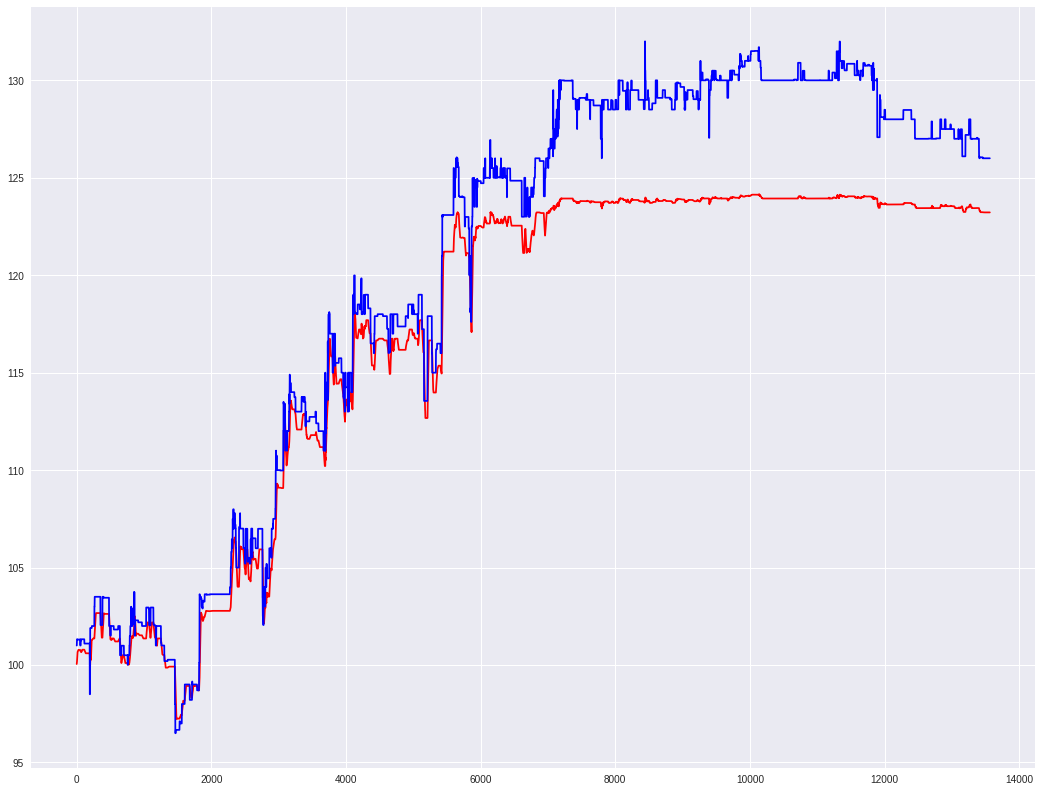

In [0]:
plt.figure(figsize=(18, 14))
plt.plot(preds_inv, 'r-')
plt.plot(actu_inv, 'b-')

In [0]:
mean_squared_error(preds_inv, actu_inv)

15.485411335073374

In [0]:
# plt.figure(figsize=(20, 12))
# plt.plot_date(x=proph_df.head(1000)['ds'], y=proph_df.head(1000)['y'], linestyle='-')

In [0]:
proph_df.tail()

ds       y
1220995  2018-09-03 13:41:25  150.54
1221040  2018-09-03 13:42:25  150.54
1221085  2018-09-03 13:43:28  150.54
1221130  2018-09-03 13:44:25  150.95
1221175  2018-09-03 13:45:26  150.95

In [0]:
# Python
m = Prophet(growth='linear', mcmc_samples=150)
m.add_country_holidays(country_name='Pakistan')
m.fit(proph_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [0]:
proph_df.head(10)

ds       y
0    2018-06-01 09:00:54  170.51
45   2018-06-01 09:01:25  171.00
90   2018-06-01 09:02:28  170.60
135  2018-06-01 09:03:25  170.15
180  2018-06-01 09:04:26  170.00
225  2018-06-01 09:05:27  170.00
270  2018-06-01 09:06:28  168.00
315  2018-06-01 09:07:28  168.25
360  2018-06-01 09:08:27  167.01
405  2018-06-01 09:09:27  168.00

In [0]:
# Python
future = m.make_future_dataframe(periods=len(hbl_test), freq='T')[len(hbl_test):]
future.head()

ds
27141 2018-09-03 13:46:26
27142 2018-09-03 13:47:26
27143 2018-09-03 13:48:26
27144 2018-09-03 13:49:26
27145 2018-09-03 13:50:26

In [0]:
future.tail()

ds
54277 2018-09-22 10:02:26
54278 2018-09-22 10:03:26
54279 2018-09-22 10:04:26
54280 2018-09-22 10:05:26
54281 2018-09-22 10:06:26

In [0]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10)

ds        yhat  yhat_lower  yhat_upper
0 2018-09-03 13:46:26  157.369366   33.706255  306.594112
1 2018-09-03 13:47:26  157.373743   20.516785  299.345165
2 2018-09-03 13:48:26  157.378085   20.785663  292.422019
3 2018-09-03 13:49:26  157.382391   35.257699  293.180224
4 2018-09-03 13:50:26  157.386657   30.516143  307.827752
5 2018-09-03 13:51:26  157.390882   27.728842  307.403041
6 2018-09-03 13:52:26  157.395064   29.283426  289.461004
7 2018-09-03 13:53:26  157.399202   42.644259  295.291826
8 2018-09-03 13:54:26  157.403293   27.632170  297.627852
9 2018-09-03 13:55:26  157.407335   20.784690  290.088520

In [0]:
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].(100)

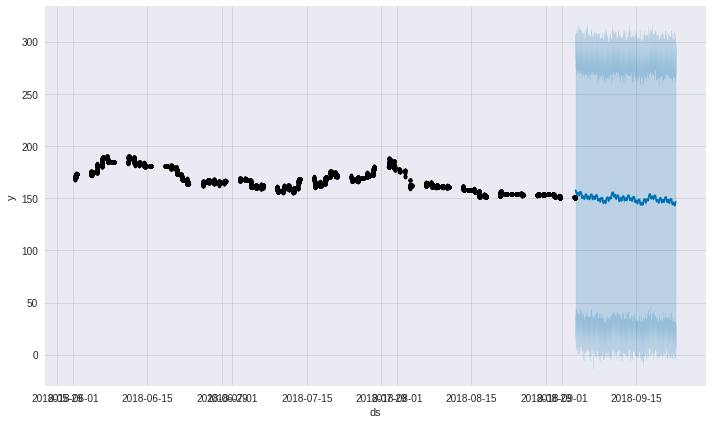

In [0]:
# plt.figure(figsize=(18, 30))
fig1 = m.plot(forecast)

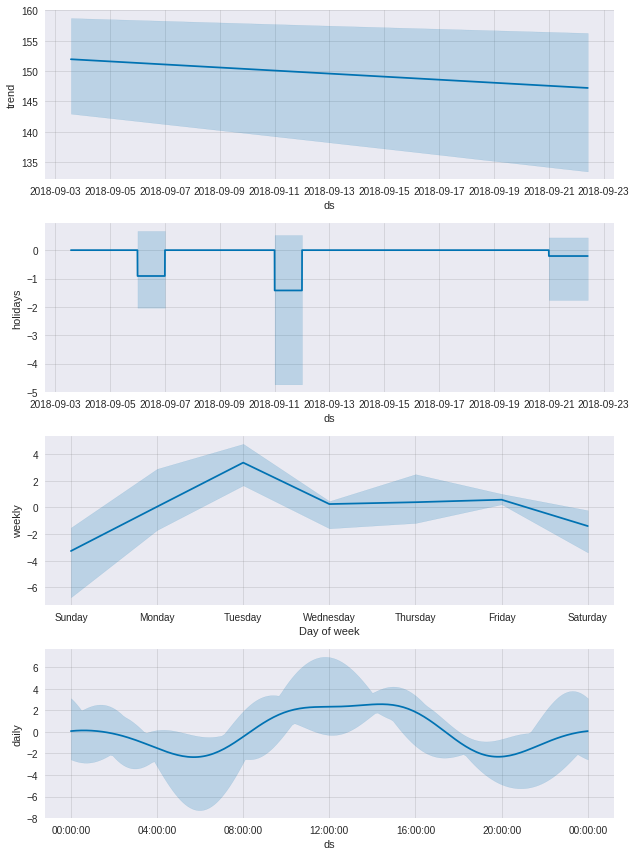

In [0]:
fig2 = m.plot_components(forecast)

In [0]:
len(hbl_test['last_price']), len(forecast['yhat'])

(27141, 27141)

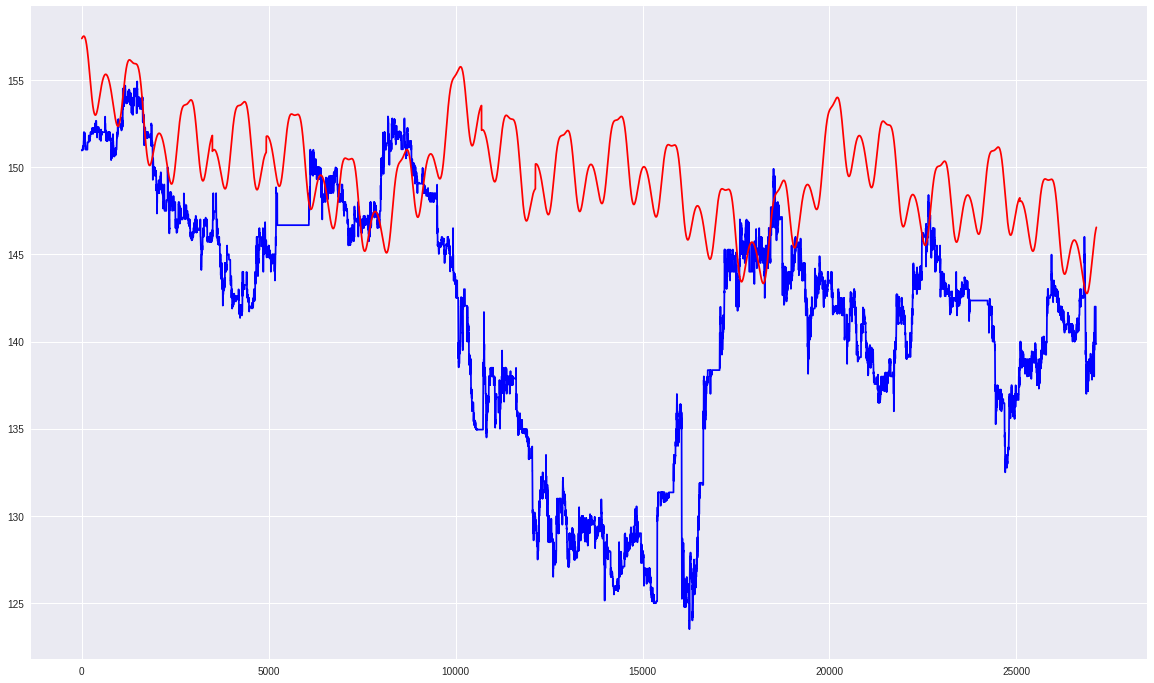

In [0]:
plt.figure(figsize=(20, 12))
plt.plot(hbl_test['last_price'].values, 'b-')
plt.plot(forecast['yhat'].values, 'r-')

In [0]:
mean_squared_error(y_true = hbl_test['last_price'], y_pred = forecast['yhat'])

117.9883802271957

AKBL
Train on 53717 samples, validate on 543 samples
Epoch 1/30
53717/53717 [==============================] - 6s 121us/step - loss: 0.1637 - val_loss: 0.0460
Epoch 2/30
53717/53717 [==============================] - 1s 17us/step - loss: 0.0912 - val_loss: 0.1245
Epoch 3/30
53717/53717 [==============================] - 1s 17us/step - loss: 0.0668 - val_loss: 0.1216
Epoch 4/30
53717/53717 [==============================] - 1s 18us/step - loss: 0.0519 - val_loss: 0.1091
Epoch 5/30
53717/53717 [==============================] - 1s 18us/step - loss: 0.0460 - val_loss: 0.1067
Epoch 6/30
53717/53717 [==============================] - 1s 17us/step - loss: 0.0433 - val_loss: 0.1021
Epoch 7/30
53717/53717 [==============================] - 1s 17us/step - loss: 0.0410 - val_loss: 0.0976
Epoch 8/30
53717/53717 [==============================] - 1s 17us/step - loss: 0.0400 - val_loss: 0.0980
Epoch 9/30
53717/53717 [==============================] - 1s 17us/step - loss: 0.0385 - val_loss: 0.0879
E

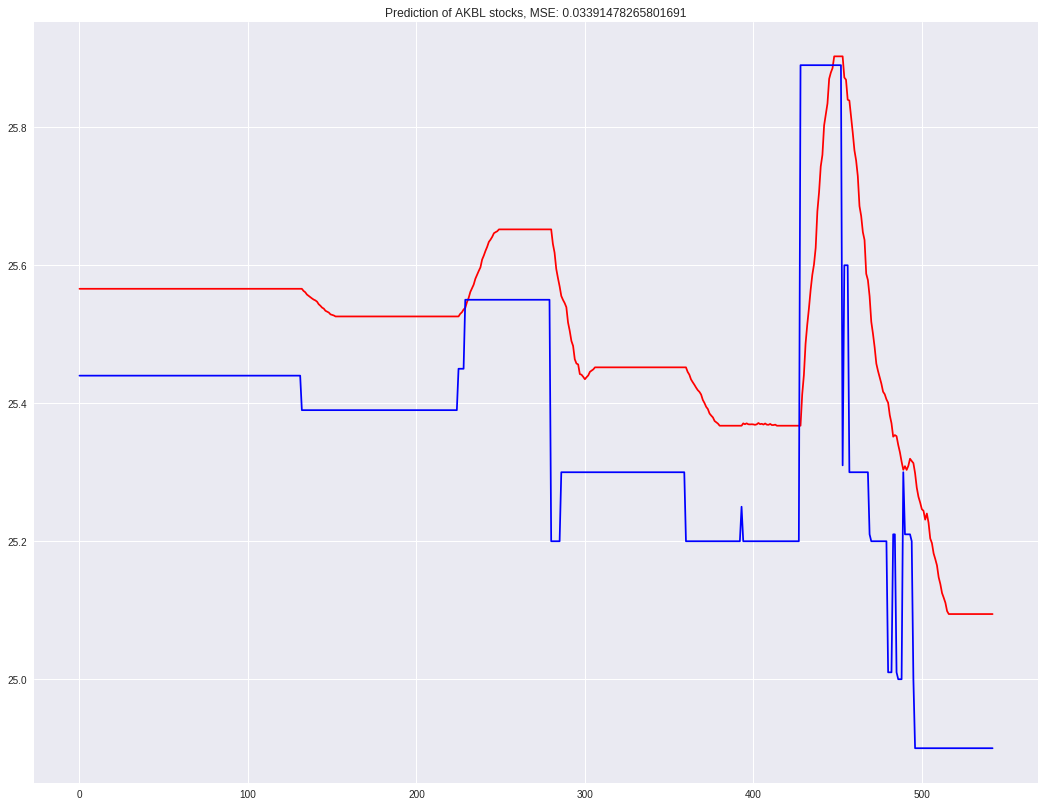

ANL
Train on 53716 samples, validate on 543 samples
Epoch 1/30
53716/53716 [==============================] - 7s 126us/step - loss: 0.2364 - val_loss: 0.0289
Epoch 2/30
53716/53716 [==============================] - 1s 17us/step - loss: 0.0900 - val_loss: 0.0195
Epoch 3/30
53716/53716 [==============================] - 1s 17us/step - loss: 0.0711 - val_loss: 0.0177
Epoch 4/30
53716/53716 [==============================] - 1s 17us/step - loss: 0.0658 - val_loss: 0.0162
Epoch 5/30
53716/53716 [==============================] - 1s 17us/step - loss: 0.0604 - val_loss: 0.0156
Epoch 6/30
53716/53716 [==============================] - 1s 18us/step - loss: 0.0547 - val_loss: 0.0156
Epoch 7/30
53716/53716 [==============================] - 1s 18us/step - loss: 0.0496 - val_loss: 0.0164
Epoch 8/30
53716/53716 [==============================] - 1s 18us/step - loss: 0.0450 - val_loss: 0.0159
Epoch 9/30
53716/53716 [==============================] - 1s 17us/step - loss: 0.0419 - val_loss: 0.0168
Ep

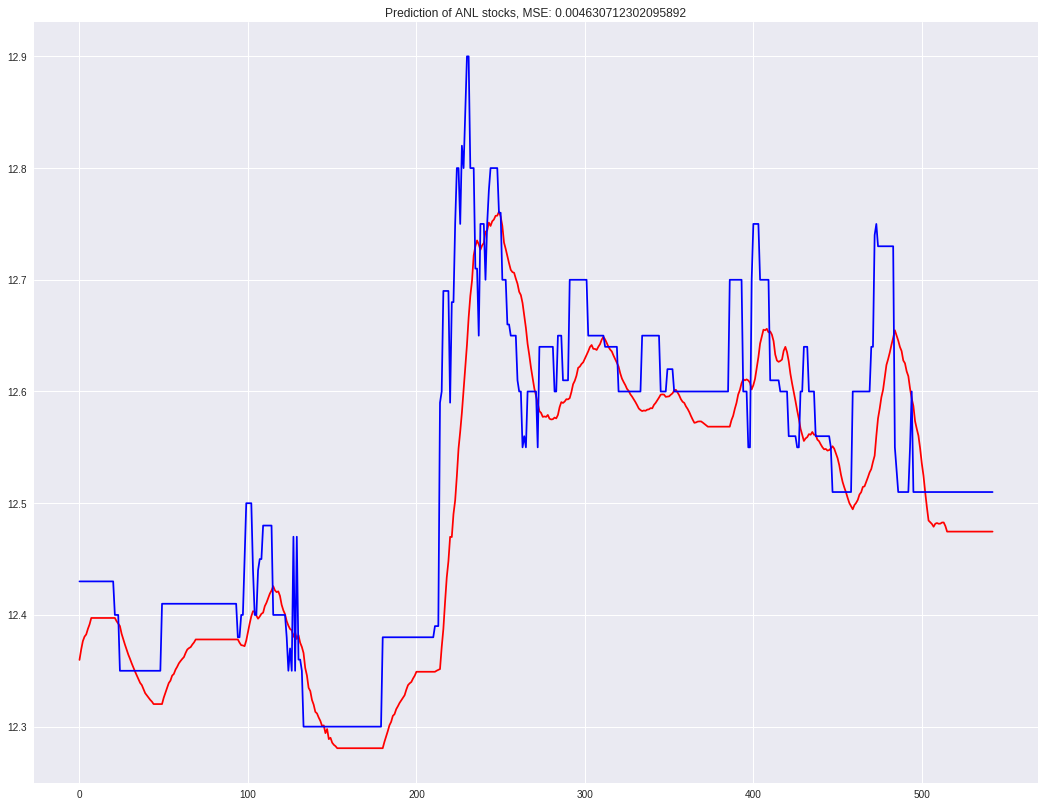

ATLH
Train on 53713 samples, validate on 543 samples
Epoch 1/30
53713/53713 [==============================] - 7s 127us/step - loss: 0.3463 - val_loss: 0.1106
Epoch 2/30
53713/53713 [==============================] - 1s 17us/step - loss: 0.1539 - val_loss: 0.0961
Epoch 3/30
53713/53713 [==============================] - 1s 18us/step - loss: 0.1326 - val_loss: 0.0850
Epoch 4/30
53713/53713 [==============================] - 1s 17us/step - loss: 0.1155 - val_loss: 0.0767
Epoch 5/30
53713/53713 [==============================] - 1s 17us/step - loss: 0.1022 - val_loss: 0.0657
Epoch 6/30
53713/53713 [==============================] - 1s 18us/step - loss: 0.0901 - val_loss: 0.0631
Epoch 7/30
53713/53713 [==============================] - 1s 17us/step - loss: 0.0807 - val_loss: 0.0609
Epoch 8/30
53713/53713 [==============================] - 1s 17us/step - loss: 0.0751 - val_loss: 0.0576
Epoch 9/30
53713/53713 [==============================] - 1s 17us/step - loss: 0.0705 - val_loss: 0.0577
E

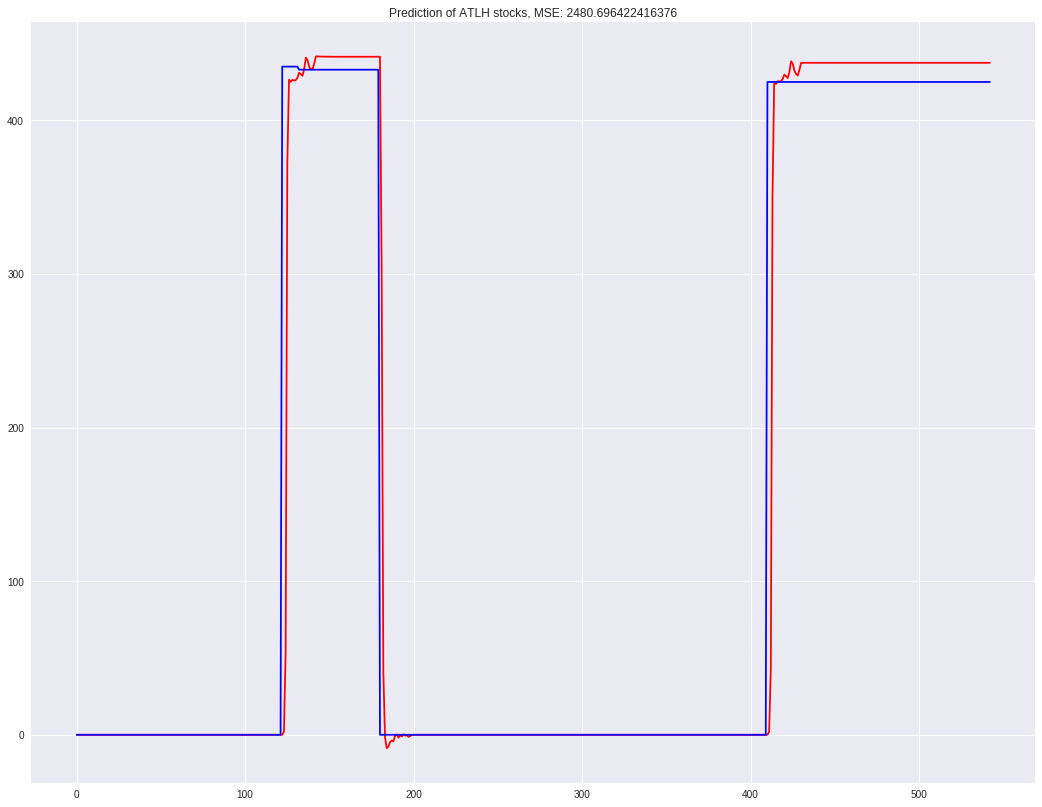

BAFL
Train on 53716 samples, validate on 543 samples
Epoch 1/30
53716/53716 [==============================] - 7s 132us/step - loss: 0.2331 - val_loss: 0.0299
Epoch 2/30
53716/53716 [==============================] - 1s 17us/step - loss: 0.0875 - val_loss: 0.0457
Epoch 3/30
53716/53716 [==============================] - 1s 17us/step - loss: 0.0745 - val_loss: 0.0105
Epoch 4/30
53716/53716 [==============================] - 1s 17us/step - loss: 0.0647 - val_loss: 0.0172
Epoch 5/30
53716/53716 [==============================] - 1s 17us/step - loss: 0.0575 - val_loss: 0.0164
Epoch 6/30
53716/53716 [==============================] - 1s 17us/step - loss: 0.0536 - val_loss: 0.0123
Epoch 7/30
53716/53716 [==============================] - 1s 17us/step - loss: 0.0506 - val_loss: 0.0104
Epoch 8/30
53716/53716 [==============================] - 1s 17us/step - loss: 0.0489 - val_loss: 0.0117
Epoch 9/30
53716/53716 [==============================] - 1s 17us/step - loss: 0.0473 - val_loss: 0.0113
E

In [0]:
histories = []
for k, v in grouped_stock_data_dfs:
  print(k)
  stk_df = grouped_stock_data_dfs.get_group(k)
  proph_df = stk_df[['last_price']]
  proph_df.columns = ['y']
#   proph_df.head()
  reframed = series_to_supervised(proph_df, 'y', 20, 1)
  target_values = reframed['y(t)']
  target_values = np.array([target_values])
#   print("Target values before shapes: {}".format(target_values.shape))
  target_values = target_values.reshape(-1, 1)
  values = proph_df.values
#   print("Target values: {}, {}".format(target_values, len(target_values)))
  # In order to support inverted scaling for the predictions, we'll scale input matrix
  # and target vector with two different scalers.
#   print("Target values after shapes: {}".format(target_values.shape))
#   print("Target values: {}".format(target_values))
  scaler_target = MinMaxScaler(feature_range=(-1 ,1))
  scaled_target = scaler_target.fit_transform(target_values)
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaled = scaler.fit_transform(values)
#   print("Scaled: {}".format(scaled))
#   print("Scaled target: {}".format(scaled_target))
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 'y', 20, 1, True)

  # Drop columns which are not needed to be predicted
  # reframed.drop(columns=cols_to_drop, inplace=True)
  #     reframed.drop(columns=reframed.columns[1: 15], inplace=True)

  # split into train and test sets
  values = reframed.values
#   print(len(values))
  n_train_periods = int(len(values)*0.99)
  train = values[:n_train_periods, :]
  test = values[n_train_periods:, :]
#   print(len(train), len(test), n_train_periods)
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#   print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


  dz = {
      'AKBL': 17158,
     'ANL': 17157,
     'ATLH': 7601,
     'BAFL': 17157,
     'BOP': 17157,
     'BYCO': 17156,
     'DAWH': 17156,
     'DCL': 17156,
     'DFML': 17156,
     'DGKC': 17156,
     'ENGRO': 17156,
     'FABL': 17158,
     'FDIBL': 15451,
     'FEROZ': 17156,
     'FFBL': 17156,
     'GHNI': 17156,
     'GHNL': 17156,
     'HASCOL': 16412,
     'HBL': 17158,
     'HCAR': 17156,
     'HUBC': 17156,
     'INDU': 15462,
     'INIL': 17156,
     'ISL': 17156,
     'JSBL': 9126,
     'KAPCO': 17156,
     'KEL': 17156,
     'KOHC': 17156,
     'LUCK': 17156,
     'MARI': 17156,
     'MCB': 17156,
     'MTL': 15906,
     'NBP': 17156,
     'OGDC': 17156,
     'PAEL': 17156,
     'PASL': 15144,
     'PIAA': 17156,
     'POL': 17156,
     'POWER': 16318,
     'PPL': 17156,
     'PSX': 15204,
     'SEARL': 16487,
     'SNGP': 17157,
     'SSGC': 17156,
     'UBL': 17156
  }


  # design network
  model = Sequential()
  model.add(LSTM(8, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False, dropout=0.25))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')

  # filepath = k+'.accidents.best.weights.hdf5'
  # checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

  # fit network
  history = model.fit(train_X, train_y, epochs=30, batch_size=512, validation_data=(test_X, test_y), verbose=1, shuffle=False)
  histories.append(history)
  
  
  preds = model.predict(test_X)
  # print("Preds: {}".format(preds))
  offset_list = [0]*n_train_periods
  t = offset_list+list(preds.flatten())
  # print("t len: {}".format(len(t)))
  preds_inv = scaler_target.inverse_transform([offset_list+list(preds.flatten())])[0].reshape(-1, 1)
  actu_inv = scaler_target.inverse_transform([offset_list+list(test_y)])[0].reshape(-1, 1)
  preds_inv = np.array(preds_inv)[n_train_periods:]
  actu_inv = np.array(actu_inv)[n_train_periods:]
#   print(preds.flatten().shape, test_y.shape, preds_inv.shape, actu_inv.shape)
  # print("predsOnly: {}".format(preds_inv))
  preds_inv = preds_inv.flatten()
  actu_inv = actu_inv.flatten()
  preds = preds.flatten()
  scaled_target = scaled_target.flatten()
  outs = gen_next_data(test_X[-1][0], model, scaler_target, dz[k], len(offset_list+list(preds.flatten())))
  
  pd.DataFrame(
      {
          'preds': outs
      }
  ).to_csv(k+'_preds.csv')
  
  plt.figure(figsize=(18, 14))
  plt.title("Prediction of {} stocks, MSE: {}".format(k, mean_squared_error(preds_inv, actu_inv)))
  plt.plot(preds_inv, 'r-')
  plt.plot(actu_inv, 'b-')
  plt.show()

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
stk_df = grouped_stock_data_dfs.get_group(k)

In [0]:
x = list(range(len(stk_df)))
y = stk_df.last_price.values

In [0]:
reg = LinearRegression()
tr_x, ts_x, tr_y, ts_y = train_test_split(x, y, shuffle=False)
tr_x = np.array(tr_x).reshape(-1, 1)
ts_x = np.array(ts_x).reshape(-1, 1)

In [0]:
reg.fit(tr_x, tr_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [0]:
reg.score(ts_x, ts_y)

-0.7600422451836096

In [0]:
tr_x, tr_y

(array([[    0],
        [    1],
        [    2],
        ...,
        [40707],
        [40708],
        [40709]]), array([22.07, 22.07, 22.07, ..., 22.12, 22.12, 22.12]))